### gCDMI: Causal Discovery in Groups of Multivariate Timeseries

Notebook written by Wasim Ahmad <br> Computer Vision Group (CVG) <br> FSU Jena, Germany <br> Last updated on: May 02, 2024


The purpose of this notebook is to provide a simple usage example of the `gCDMI` for generating causal graph for mulativariate time series. Higher-dimensional time series may require additional computational time or the availaibility of a graphical processing unit.

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

#### Load Dependencies

In [3]:
import pickle
import time
import pathlib
import parameters
import renyiDAG
import numpy as np
import mxnet as mx
import preprocessing as prep
import matplotlib.pyplot as plt
from knockoffs import Knockoffs
from gctest2 import groupCause
from gluonts.trainer import Trainer
from scms import StructuralCausalModel
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput

In [4]:
np.random.seed(1)
mx.random.seed(2)

#### Load Model Parameters

The parameters for model archicture varies from application to application depends on data dimensionality mainly

In [5]:
start_time = time.time()

# Parameters
pars = parameters.get_rivernet_params_gc()
freq = pars.get('freq')
epochs = pars.get('epochs')
win_size = pars.get('win_size')
slidingwin_size = pars.get('slidingwin_size')
training_length = pars.get('train_len')
prediction_length = pars.get('pred_len')
num_samples = pars.get('num_samples')
num_layers = pars.get('num_layers')
num_cells = pars.get('num_cells')
dropout_rate = pars.get('dropout_rate')
batch_size = pars.get('batch_size')
plot_path = pars.get('plot_path')
model_name = pars.get('model_name')

In [7]:
# data = prep.load_flux_data(0, 96)
# data.head()
river = prep.load_river_data()

<Axes: xlabel='Date'>

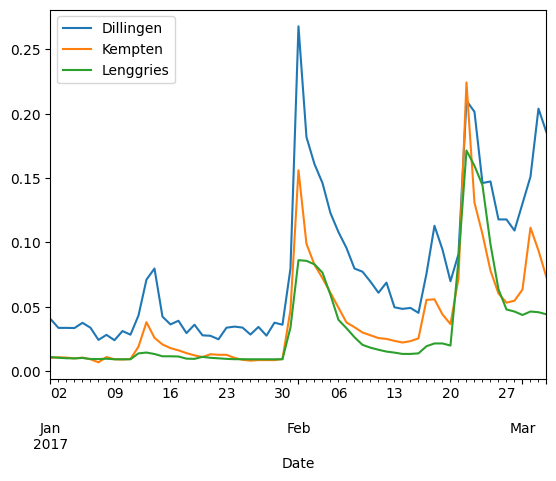

In [8]:
river.iloc[0:63].plot()

In [9]:
df, ground_truth, _ = prep.load_rivernet(0)

Before Nans shape: (175296, 5)
Before Nas mean: 553      0.272922
1144    13.266971
1145    10.828980
1146     8.696505
1147     8.112889
dtype: float64
Shape of river data: (7305, 5)
Ground truth: 
 [[0 1 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]
Shape of river data: (7029, 5)
Mean of the data: 553      0.272982
1144    13.294056
1145    10.833642
1146     8.701201
1147     8.109974
dtype: float64
                          553       1144       1145       1146       1147
dt                                                                       
2019-03-11 00:00:00  0.326000  38.225000  42.975000  44.300000  39.850000
2019-03-11 06:00:00  0.326000  43.130435  45.247826  41.408696  37.734783
2019-03-11 12:00:00  0.398080  46.504000  43.460000  40.780000  37.460000
2019-03-11 18:00:00  0.382522  46.495652  43.321739  38.595652  36.343478
2019-03-12 00:00:00  0.494000  46.360000  42.024000  37.436000  34.676000
...                       ...        ...        ...        ...

In [10]:
df.describe()

553         1144         1145         1146         1147
count  7029.000000  7029.000000  7029.000000  7029.000000  7029.000000
mean      0.272982    13.294056    10.833642     8.701201     8.109974
std       0.354199    12.008351    10.997120     8.696380     8.124520
min       0.046000     1.865217     1.698261     1.235696     1.524000
25%       0.088000     5.805600     4.368800     3.580000     3.301600
50%       0.166261     9.170000     6.980870     5.750400     5.106800
75%       0.326000    16.600000    13.064000    10.678261    10.080000
max       9.168400   182.760000   171.120000   133.320000   116.680000

#### Load Dataset

In [11]:
# df = prep.load_syn_data()
# df = df.iloc[:, :]
# df[:100].plot(figsize=(9, 4), linewidth=0.66, use_index=True)
# plt.show()
# # func.corr_heatmap(df)
# df.head()

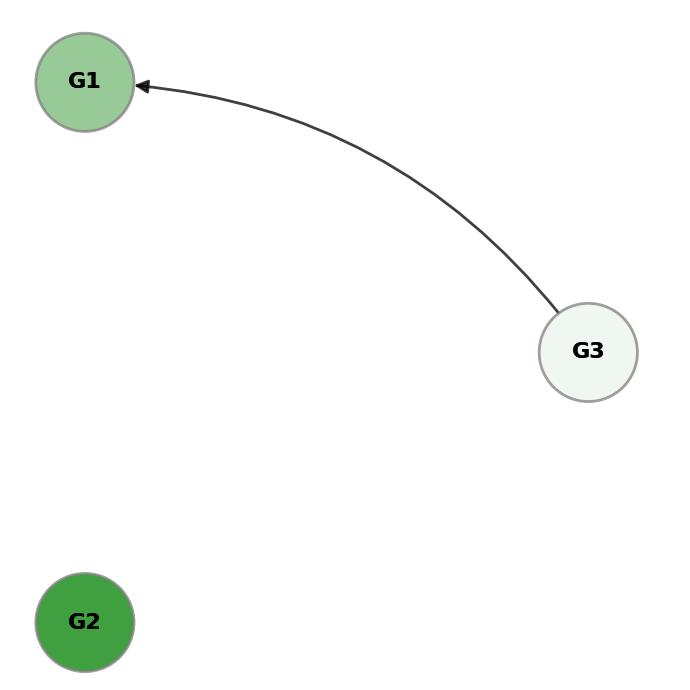

In [18]:
# --------------------------------------
#           Erdos-Renyi DAG
# --------------------------------------
np.random.seed(1)
nodes = 3
num_groups = 3
group_size = int(nodes/num_groups)
nonlinearity_factor = 0.10
interaction_density = 0.2
timesteps = 100

df, causalgraph, complete_graph = renyiDAG.generate_dag_and_time_series(nodes, interaction_density, nonlinearity_factor, timesteps, num_groups, group_size)

<Axes: >

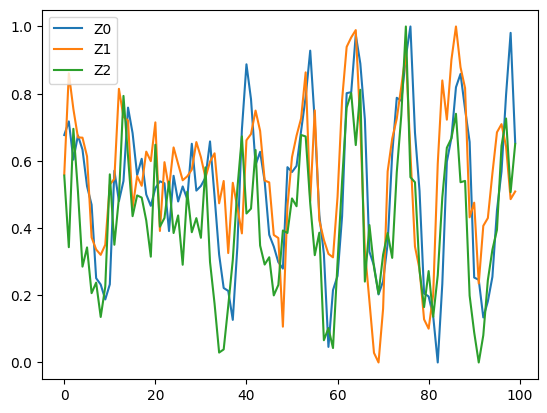

In [19]:
df.plot()

#### Generate Training Dataset

In [341]:
original_data = []
dim, columns = len(df.columns), df.columns
for col in df:
    original_data.append(df[col])

original_data = np.array(original_data)
# training set
train_ds = ListDataset(
    [
        {'start': "01/03/2015 00:00:00",
         'target': original_data[:, 0: training_length].tolist()
         }
    ],
    freq=freq,
    one_dim_target=False
)

#### DeepAR Estimator

In [342]:
# create estimator
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=prediction_length,
    freq=freq,
    num_layers=num_layers,
    num_cells=num_cells,
    dropout_rate=dropout_rate,
    trainer=Trainer(
        ctx="cpu",
        epochs=epochs,
        hybridize=False,
        batch_size=32
    ),
    distr_output=MultivariateGaussianOutput(dim=dim)
)

### Load/Train Model

In [343]:
path = pars.get('model_path')
model_name = 'rivernet_0.sav'
model_path = pathlib.Path(path + model_name)
# model_path = "../models/trained_model_georegime_cli9.sav"
# model_path = "../models/trained_model_syn22Sep.sav"
# model_path = "../models/trained_model_river16Jun.sav"

filename = pathlib.Path(model_path)
print(f'Model: {filename}')
if not filename.exists():
    print('Training DeepAR model....')
    predictor = estimator.train(train_ds)
    # save the model to disk
    pickle.dump(predictor, open(filename, 'wb'))

Model: /home/ahmad/Projects/gCause/models/gc/rivernet_0.sav


#### Generate Knockoffs

In [344]:
data_actual = np.array(original_data[:, :]).transpose()
n = len(original_data[:, 0])
obj = Knockoffs()
pars.update({'length': n, 'dim': dim, 'col': columns})
knockoffs = obj.Generate_Knockoffs(data_actual, pars)

#### Esimate Causal Links

Select number of groups: 5


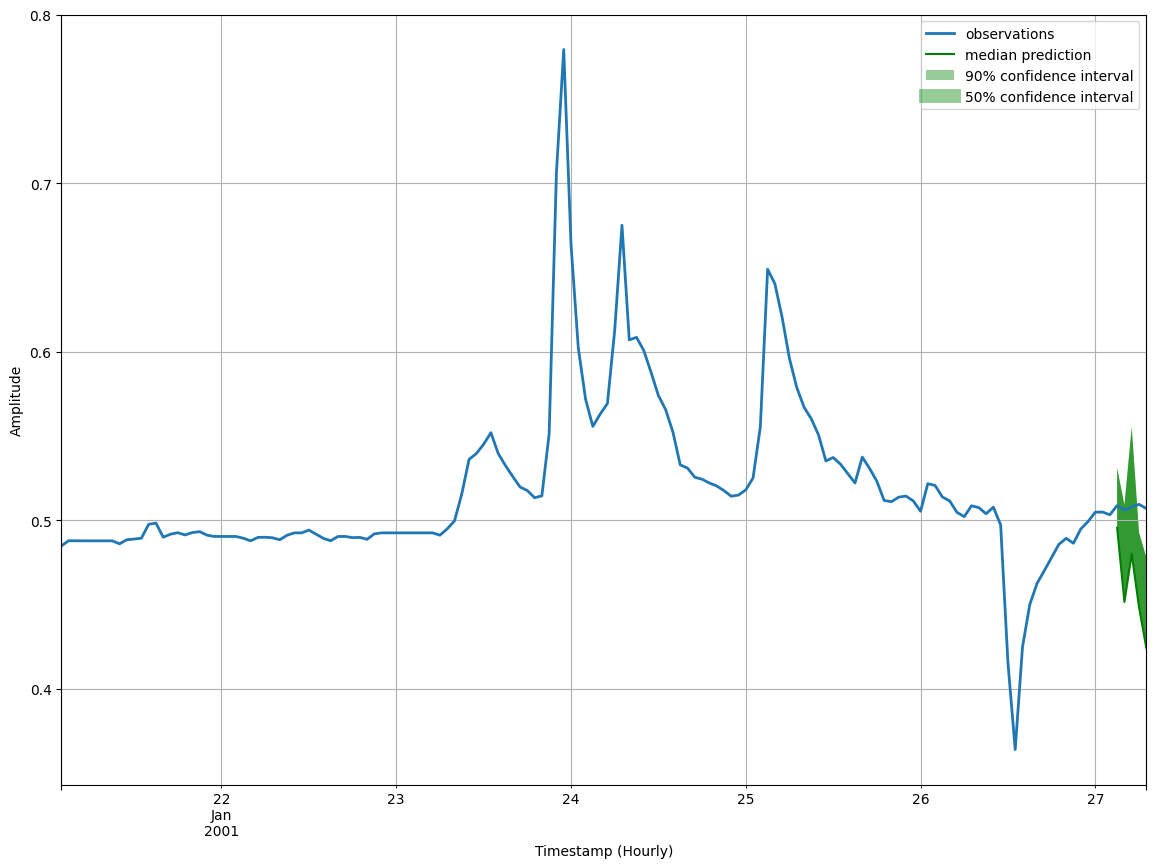

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Performance metrics {'MSE': 0.001079268753528595, 'abs_error': 0.23903530836105347, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 2.8564117408107936, 'MAPE': 0.09419188589488678, 'sMAPE': 0.10020747404689734, 'OWA': nan, 'MSIS': 24.97245696444288, 'QuantileLoss[0.1]': 0.04780706167221069, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.23903530836105347, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.09658145308494567, 'Coverage[0.9]': 0.6, 'RMSE': 0.03285222600568483, 'NRMSE': 0.06469864456885166, 'ND': 0.09415045697287913, 'wQuantileLoss[0.1]': 0.018830091394575824, 'wQuantileLoss[0.5]': 0.09415045697287913, 'wQuantileLoss[0.9]': 0.038041191510157224, 'mean_wQuantileLoss': 0.05034057995920407, 'MAE_Coverage': 0.3}


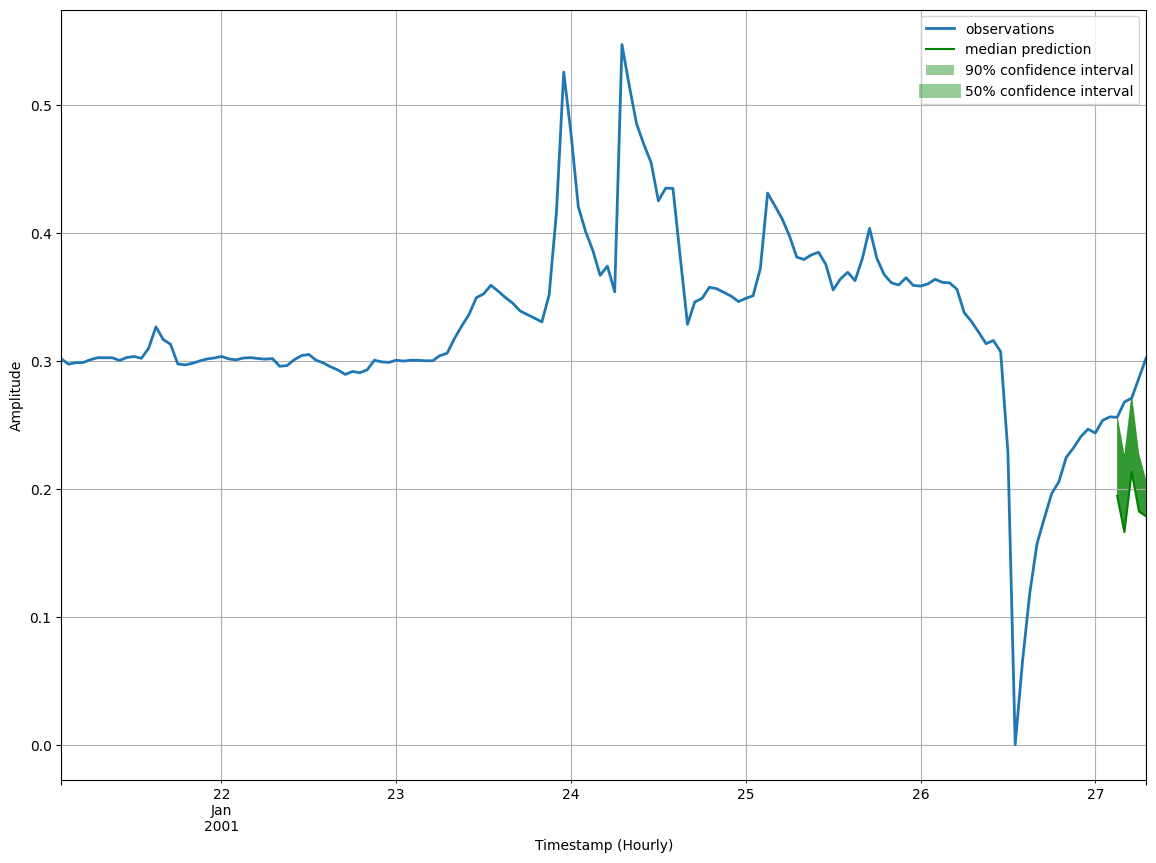

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Performance metrics {'MSE': 0.005087794363498687, 'abs_error': 0.4488297700881958, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 2.7704523082256296, 'MAPE': 0.3213010019874329, 'sMAPE': 0.3880832996272839, 'OWA': nan, 'MSIS': 49.98868125686778, 'QuantileLoss[0.1]': 0.08976595997810365, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.4488297998905182, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.3540248990058899, 'Coverage[0.9]': 0.4, 'RMSE': 0.07132877654564591, 'NRMSE': 0.25790920340016393, 'ND': 0.32457399123241076, 'wQuantileLoss[0.1]': 0.06491480255682848, 'wQuantileLoss[0.5]': 0.32457401278414233, 'wQuantileLoss[0.9]': 0.25601526931561014, 'mean_wQuantileLoss': 0.2151680282188603, 'MAE_Coverage': 0.3666666666666667}


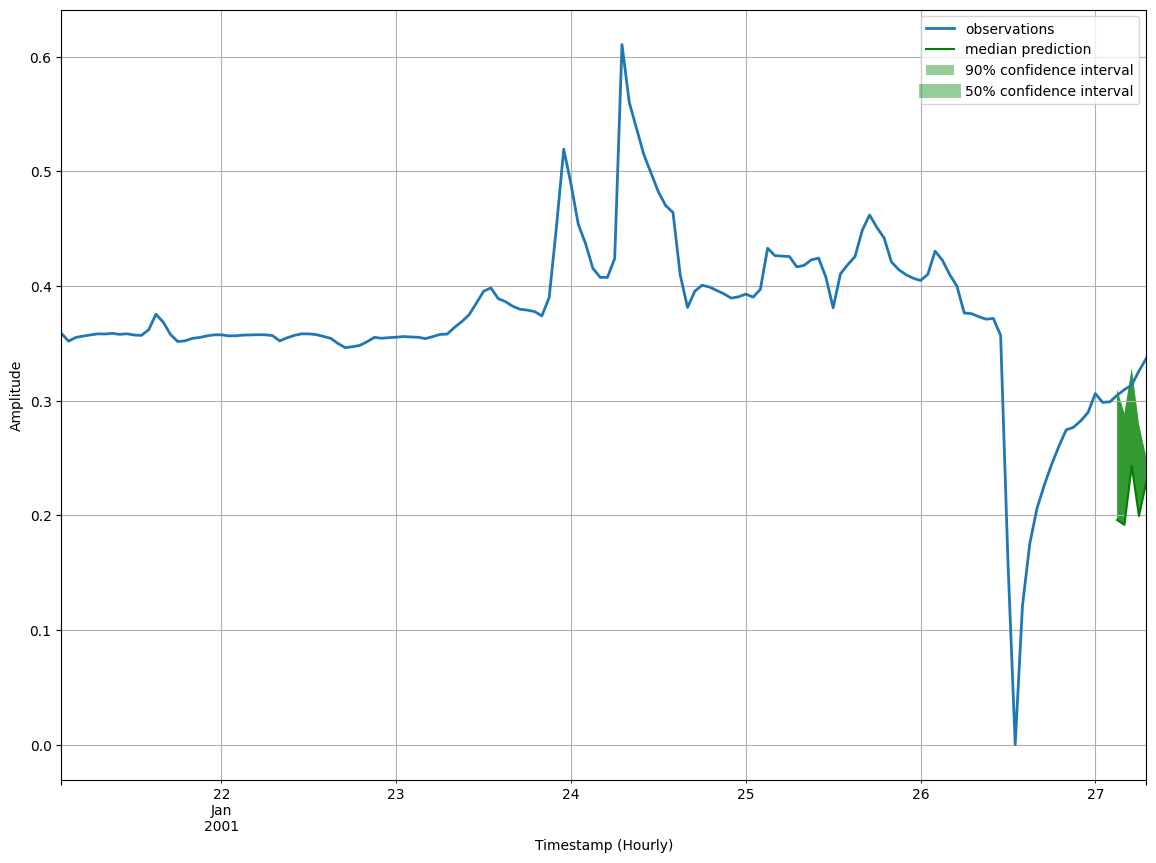

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Performance metrics {'MSE': 0.005047416687011719, 'abs_error': 0.5317081809043884, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 3.5572331364861762, 'MAPE': 0.3342642894959035, 'sMAPE': 0.404335817575716, 'OWA': nan, 'MSIS': 43.857537349062596, 'QuantileLoss[0.1]': 0.10634163916110993, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.5317081958055496, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.2810308635234833, 'Coverage[0.9]': 0.4, 'RMSE': 0.07104517356592015, 'NRMSE': 0.22329163640081473, 'ND': 0.33422675698492016, 'wQuantileLoss[0.1]': 0.06684535327032996, 'wQuantileLoss[0.5]': 0.33422676635164983, 'wQuantileLoss[0.9]': 0.1766533551700526, 'mean_wQuantileLoss': 0.1925751582640108, 'MAE_Coverage': 0.3666666666666667}


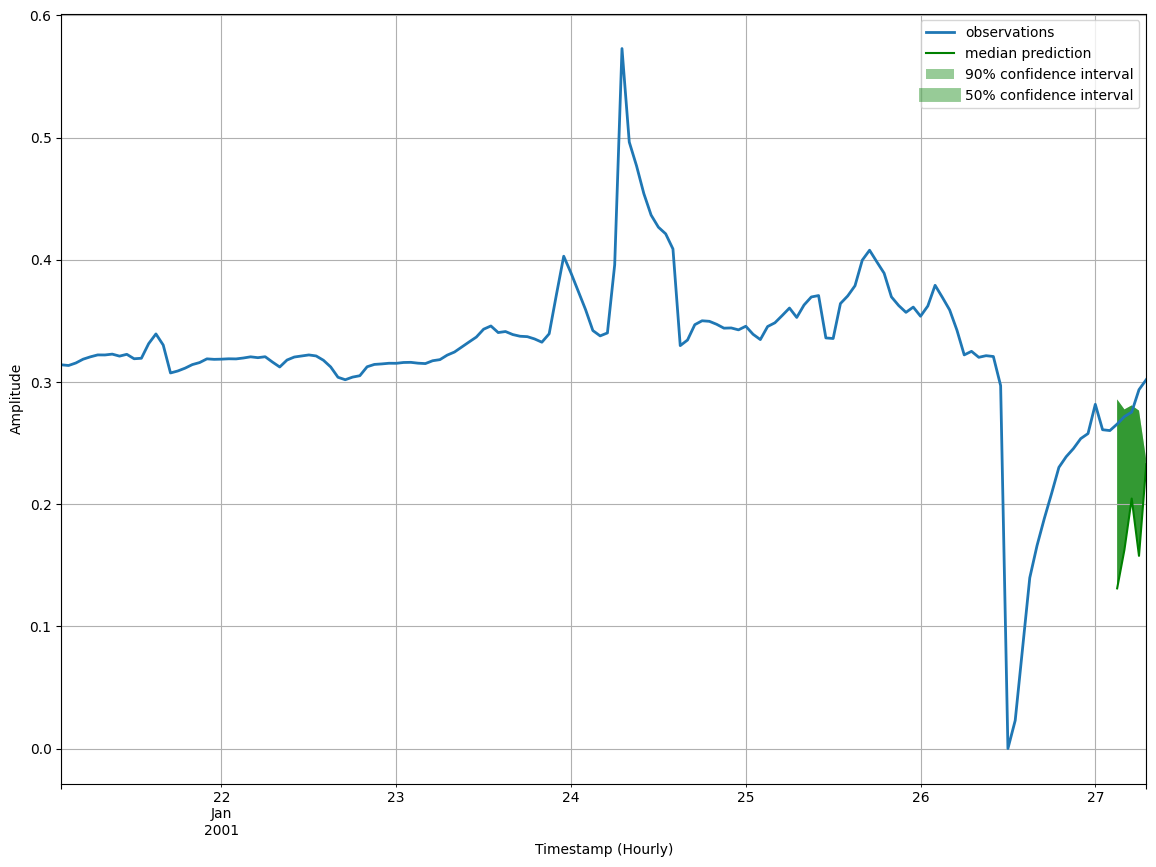

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Performance metrics {'MSE': 0.0034861043095588684, 'abs_error': 0.519416332244873, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 3.507715218342089, 'MAPE': 0.3713572194319103, 'sMAPE': 0.4672346562897422, 'OWA': nan, 'MSIS': 25.651269838613075, 'QuantileLoss[0.1]': 0.1038832575082779, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.5194162875413895, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.15618700087070464, 'Coverage[0.9]': 0.6, 'RMSE': 0.05904324101502956, 'NRMSE': 0.2096406049025447, 'ND': 0.36885087002713146, 'wQuantileLoss[0.1]': 0.07377016765640806, 'wQuantileLoss[0.5]': 0.3688508382820403, 'wQuantileLoss[0.9]': 0.11091239836279983, 'mean_wQuantileLoss': 0.18451113476708272, 'MAE_Coverage': 0.3}


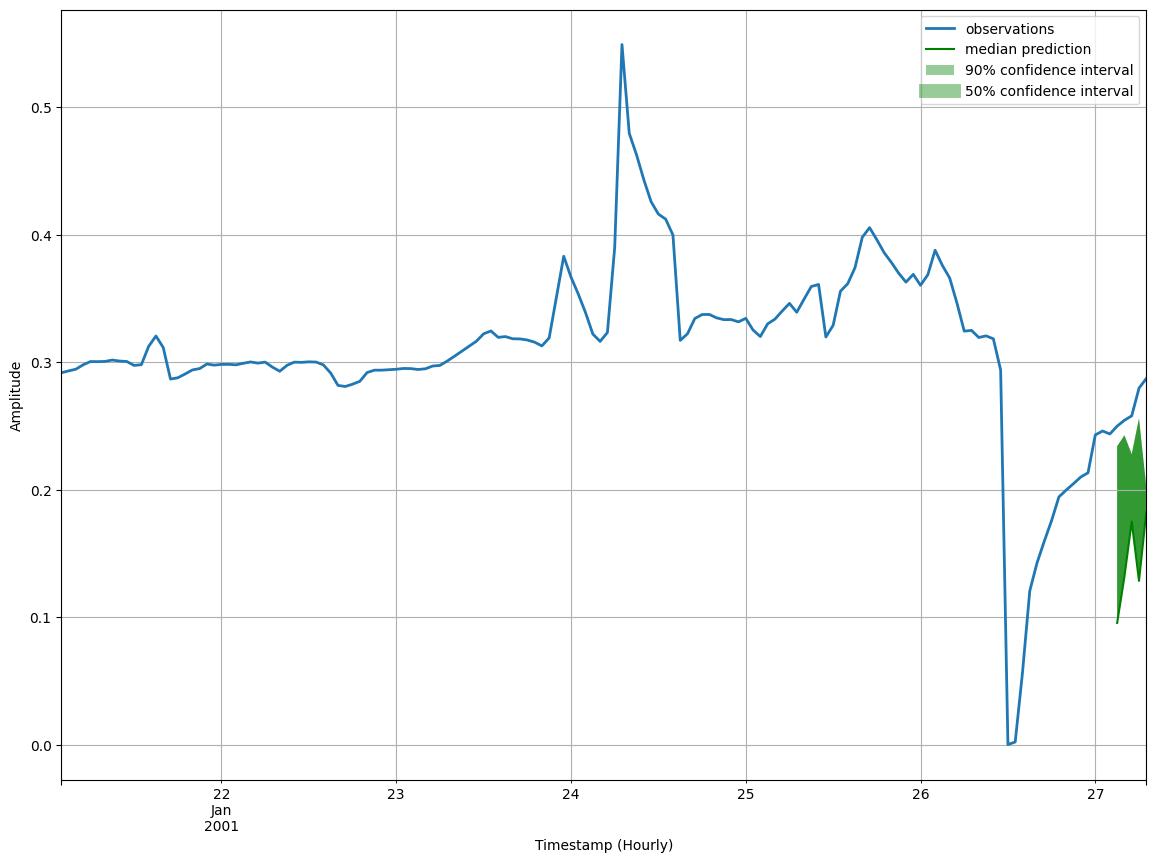

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Performance metrics {'MSE': 0.0063219331204891205, 'abs_error': 0.6159979701042175, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 3.7581192070335576, 'MAPE': 0.4655837274876883, 'sMAPE': 0.6202489645799709, 'OWA': nan, 'MSIS': 43.34699226766254, 'QuantileLoss[0.1]': 0.12319959700107576, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.6159979850053787, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.29949513673782346, 'Coverage[0.9]': 0.0, 'RMSE': 0.07951058495879099, 'NRMSE': 0.29921893765079366, 'ND': 0.4636320014628453, 'wQuantileLoss[0.1]': 0.09272640253564632, 'wQuantileLoss[0.5]': 0.46363201267823156, 'wQuantileLoss[0.9]': 0.2254155637081943, 'mean_wQuantileLoss': 0.2605913263073574, 'MAE_Coverage': 0.5}


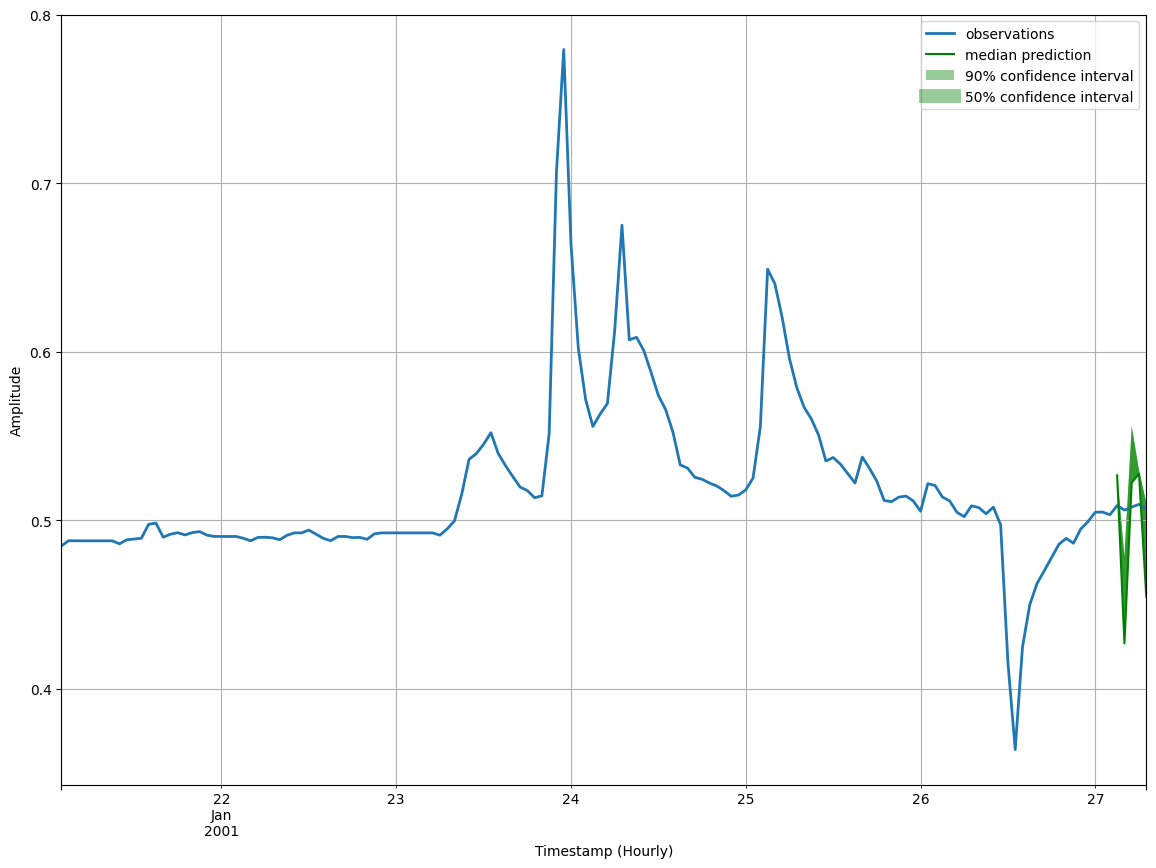

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Performance metrics {'MSE': 0.0010232013650238515, 'abs_error': 0.18186646699905396, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 2.1732584828481234, 'MAPE': 0.0717402358888467, 'sMAPE': 0.07518739707109527, 'OWA': nan, 'MSIS': 38.9580251288722, 'QuantileLoss[0.1]': 0.11715055704116821, 'Coverage[0.1]': 0.6, 'QuantileLoss[0.5]': 0.18186646699905396, 'Coverage[0.5]': 0.6, 'QuantileLoss[0.9]': 0.06754388213157654, 'Coverage[0.9]': 0.8, 'RMSE': 0.0319875188944665, 'NRMSE': 0.06299570431648664, 'ND': 0.07163297796215376, 'wQuantileLoss[0.1]': 0.046142883893091145, 'wQuantileLoss[0.5]': 0.07163297796215376, 'wQuantileLoss[0.9]': 0.026603966635777347, 'mean_wQuantileLoss': 0.04812660949700742, 'MAE_Coverage': 0.2333333333333333}


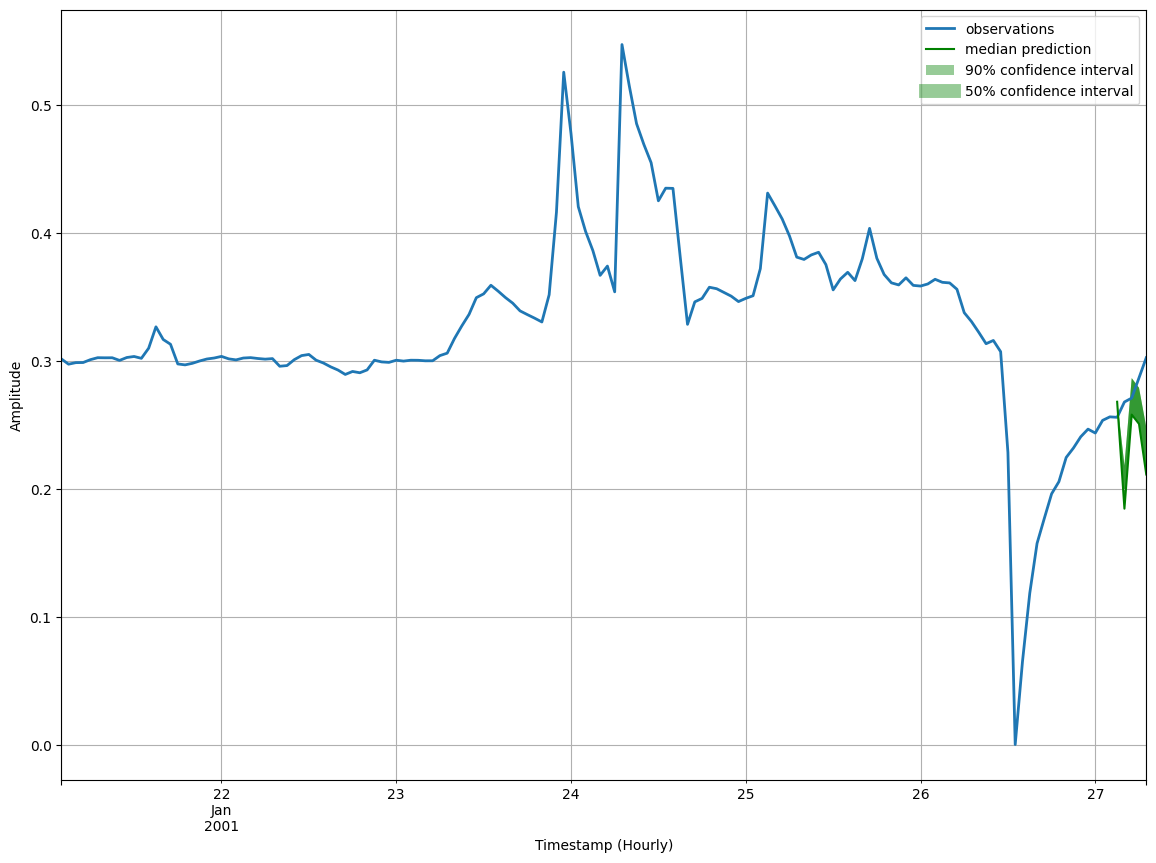

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Performance metrics {'MSE': 0.0020728504285216333, 'abs_error': 0.23568077385425568, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 1.4547661216871173, 'MAPE': 0.16684178438418412, 'sMAPE': 0.1907667982806825, 'OWA': nan, 'MSIS': 31.361881246402593, 'QuantileLoss[0.1]': 0.06657165586948395, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.23568077385425568, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.20673892199993135, 'Coverage[0.9]': 0.4, 'RMSE': 0.04552856716965331, 'NRMSE': 0.16462130796764546, 'ND': 0.17043399195999723, 'wQuantileLoss[0.1]': 0.048141699790241306, 'wQuantileLoss[0.5]': 0.17043399195999723, 'wQuantileLoss[0.9]': 0.14950451491535, 'mean_wQuantileLoss': 0.12269340222186283, 'MAE_Coverage': 0.3}


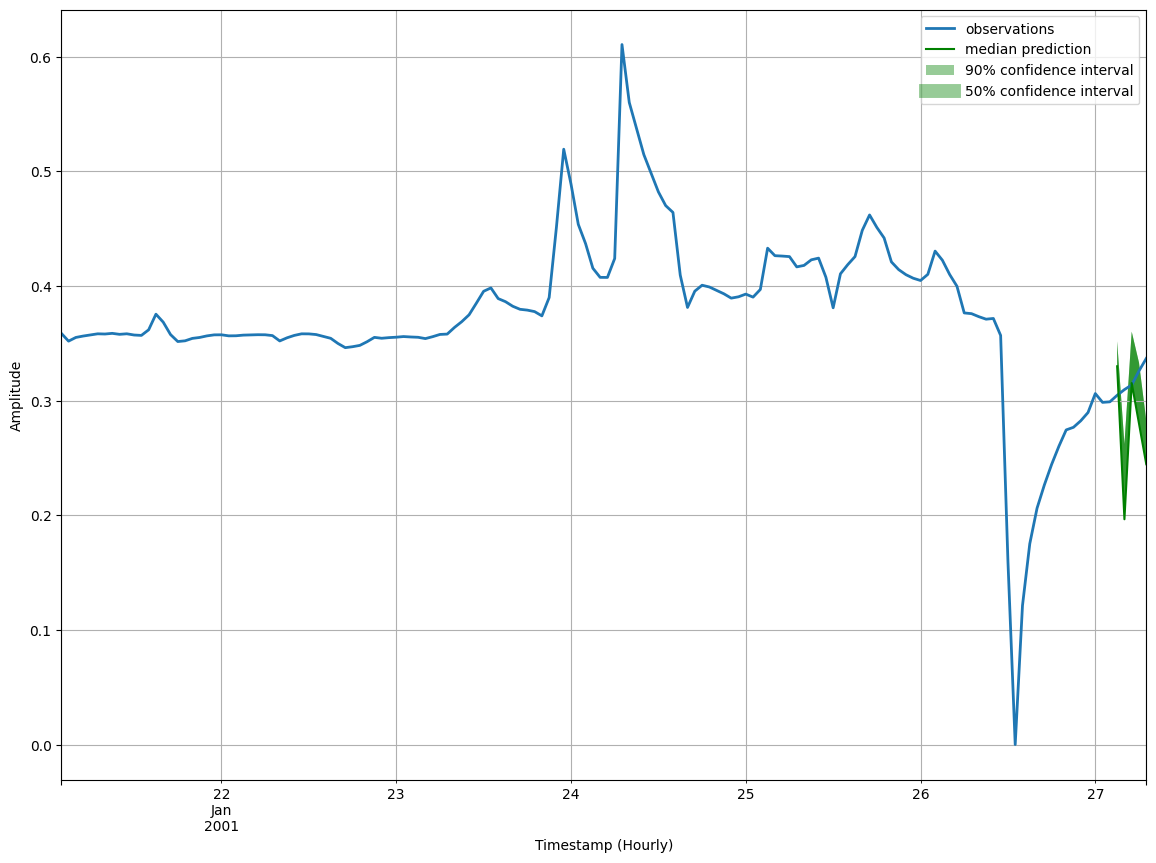

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Performance metrics {'MSE': 0.00281760860234499, 'abs_error': 0.27834057807922363, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 1.8621536457987573, 'MAPE': 0.1737306102226203, 'sMAPE': 0.20023605495010757, 'OWA': nan, 'MSIS': 35.934938870462666, 'QuantileLoss[0.1]': 0.0987805813550949, 'Coverage[0.1]': 0.4, 'QuantileLoss[0.5]': 0.27834056317806244, 'Coverage[0.5]': 0.4, 'QuantileLoss[0.9]': 0.20332696437835693, 'Coverage[0.9]': 0.6, 'RMSE': 0.053081151102297976, 'NRMSE': 0.1668315593693844, 'ND': 0.1749622670662938, 'wQuantileLoss[0.1]': 0.06209254351370457, 'wQuantileLoss[0.5]': 0.17496225769956417, 'wQuantileLoss[0.9]': 0.1278094156764285, 'mean_wQuantileLoss': 0.1216214056298991, 'MAE_Coverage': 0.23333333333333336}


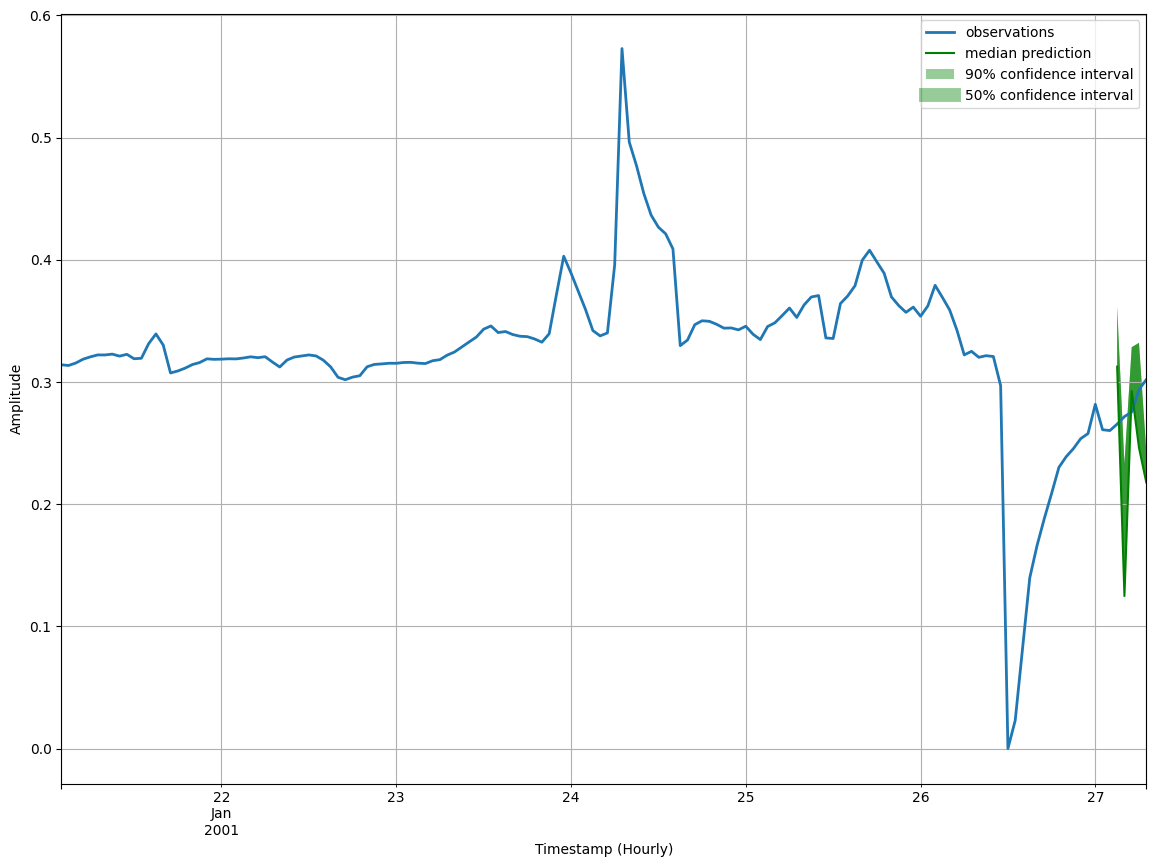

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Performance metrics {'MSE': 0.004003985971212387, 'abs_error': 0.34274643659591675, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 2.3146305132223457, 'MAPE': 0.2441175839875493, 'sMAPE': 0.29278344842094994, 'OWA': nan, 'MSIS': 45.50982715873292, 'QuantileLoss[0.1]': 0.171253764629364, 'Coverage[0.1]': 0.4, 'QuantileLoss[0.5]': 0.34274643659591675, 'Coverage[0.5]': 0.4, 'QuantileLoss[0.9]': 0.21147009134292605, 'Coverage[0.9]': 0.6, 'RMSE': 0.06327705722623633, 'NRMSE': 0.22467331273336405, 'ND': 0.24339304232255551, 'wQuantileLoss[0.1]': 0.12161169404504417, 'wQuantileLoss[0.5]': 0.24339304232255551, 'wQuantileLoss[0.9]': 0.15017033992643605, 'mean_wQuantileLoss': 0.17172502543134524, 'MAE_Coverage': 0.23333333333333336}


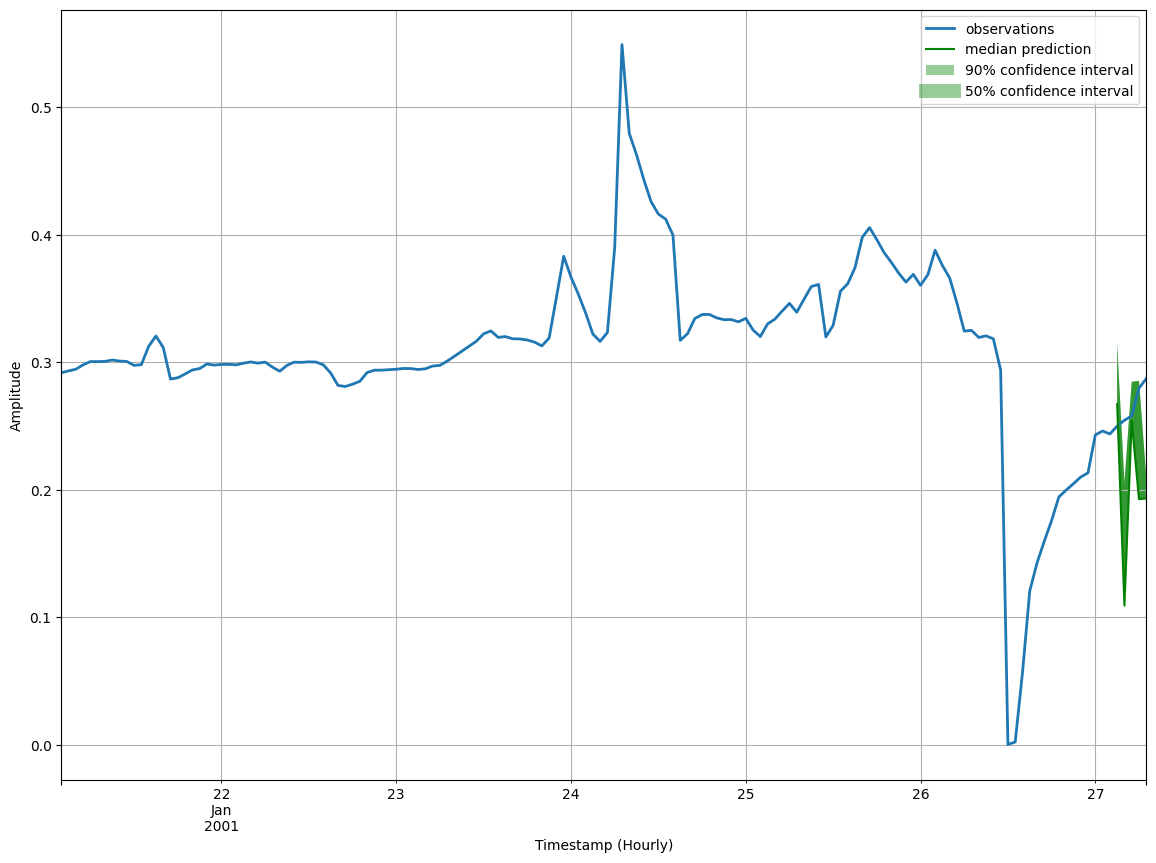

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Performance metrics {'MSE': 0.004055770486593247, 'abs_error': 0.34764015674591064, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 2.1209049600957743, 'MAPE': 0.2589440796387228, 'sMAPE': 0.3285148791431256, 'OWA': nan, 'MSIS': 36.84575027143552, 'QuantileLoss[0.1]': 0.09732030034065246, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.34764018654823303, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.24719899594783784, 'Coverage[0.9]': 0.6, 'RMSE': 0.06368493139348778, 'NRMSE': 0.23966290181111566, 'ND': 0.2616520012780157, 'wQuantileLoss[0.1]': 0.07324830246156196, 'wQuantileLoss[0.5]': 0.26165202370878826, 'wQuantileLoss[0.9]': 0.18605477747193172, 'mean_wQuantileLoss': 0.17365170121409398, 'MAE_Coverage': 0.23333333333333336}


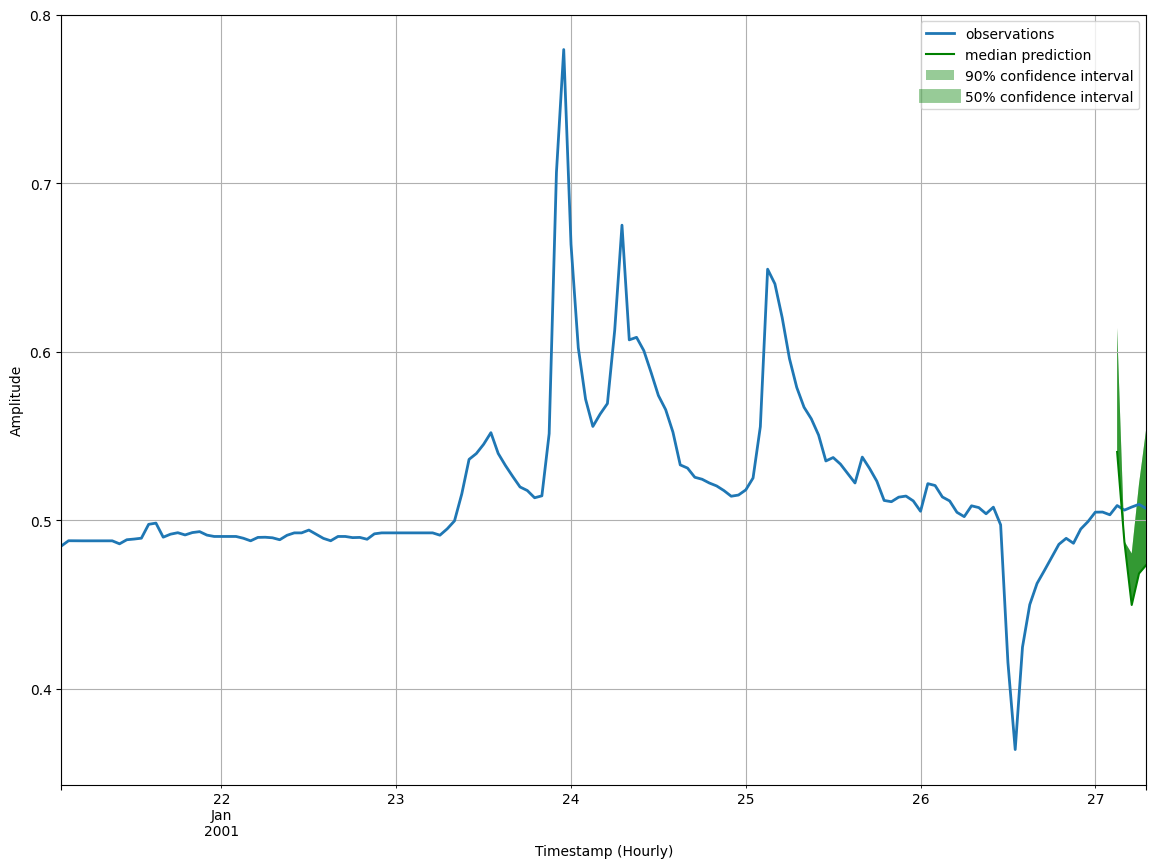

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Performance metrics {'MSE': 0.0014309307560324668, 'abs_error': 0.18349650502204895, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 2.1927370267451534, 'MAPE': 0.07224613797272524, 'sMAPE': 0.074529923902696, 'OWA': nan, 'MSIS': 40.06438220536667, 'QuantileLoss[0.1]': 0.08756123185157777, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.18349650502204895, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.11589305400848389, 'Coverage[0.9]': 0.6, 'RMSE': 0.03782764539371261, 'NRMSE': 0.07449715534590767, 'ND': 0.0722750120859006, 'wQuantileLoss[0.1]': 0.0344883358381605, 'wQuantileLoss[0.5]': 0.0722750120859006, 'wQuantileLoss[0.9]': 0.04564758265084463, 'mean_wQuantileLoss': 0.05080364352496858, 'MAE_Coverage': 0.23333333333333336}


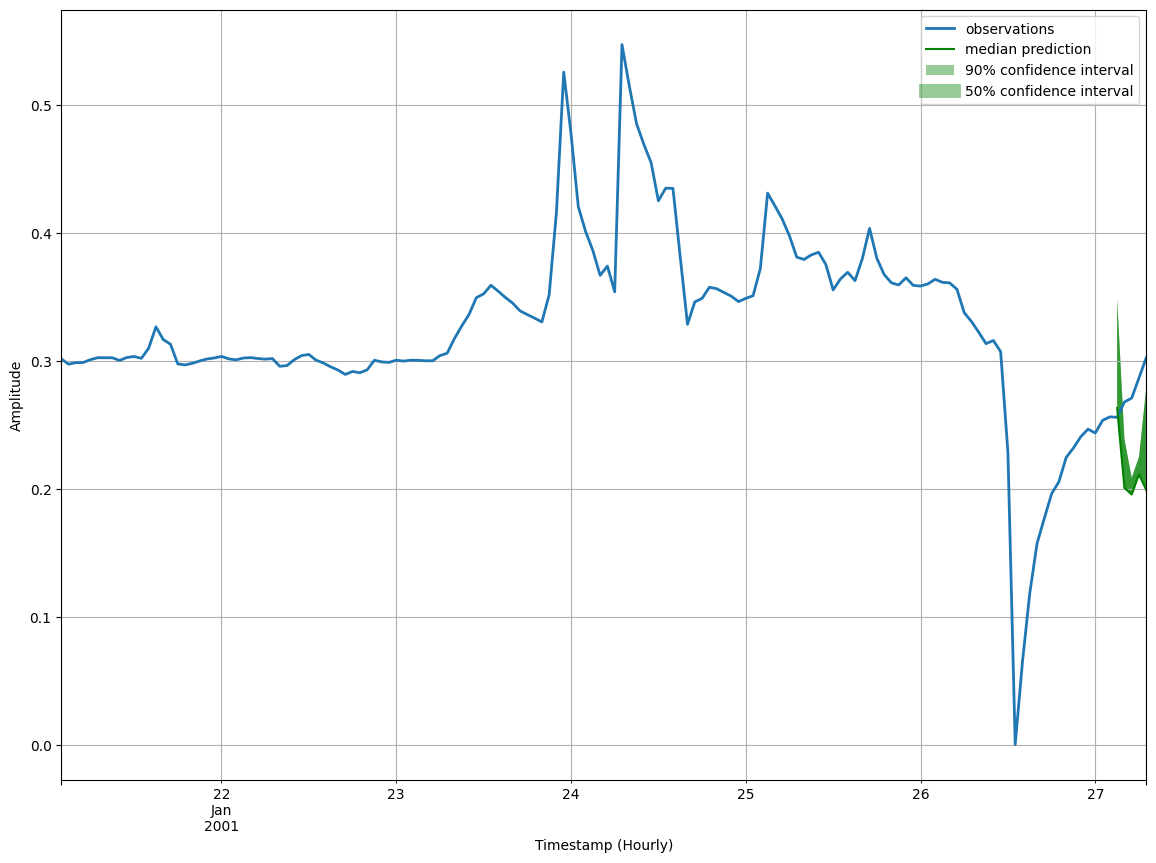

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Performance metrics {'MSE': 0.003651644289493561, 'abs_error': 0.3285025358200073, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 2.027718902072105, 'MAPE': 0.23253529037752937, 'sMAPE': 0.2707142874461369, 'OWA': nan, 'MSIS': 46.73421655067762, 'QuantileLoss[0.1]': 0.07741301357746125, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.3285025507211685, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.3357227712869644, 'Coverage[0.9]': 0.2, 'RMSE': 0.060428836572397795, 'NRMSE': 0.2184974123706201, 'ND': 0.2375586163995229, 'wQuantileLoss[0.1]': 0.05598169387299789, 'wQuantileLoss[0.5]': 0.23755862717538867, 'wQuantileLoss[0.9]': 0.24277997380343924, 'mean_wQuantileLoss': 0.17877343161727524, 'MAE_Coverage': 0.3666666666666667}


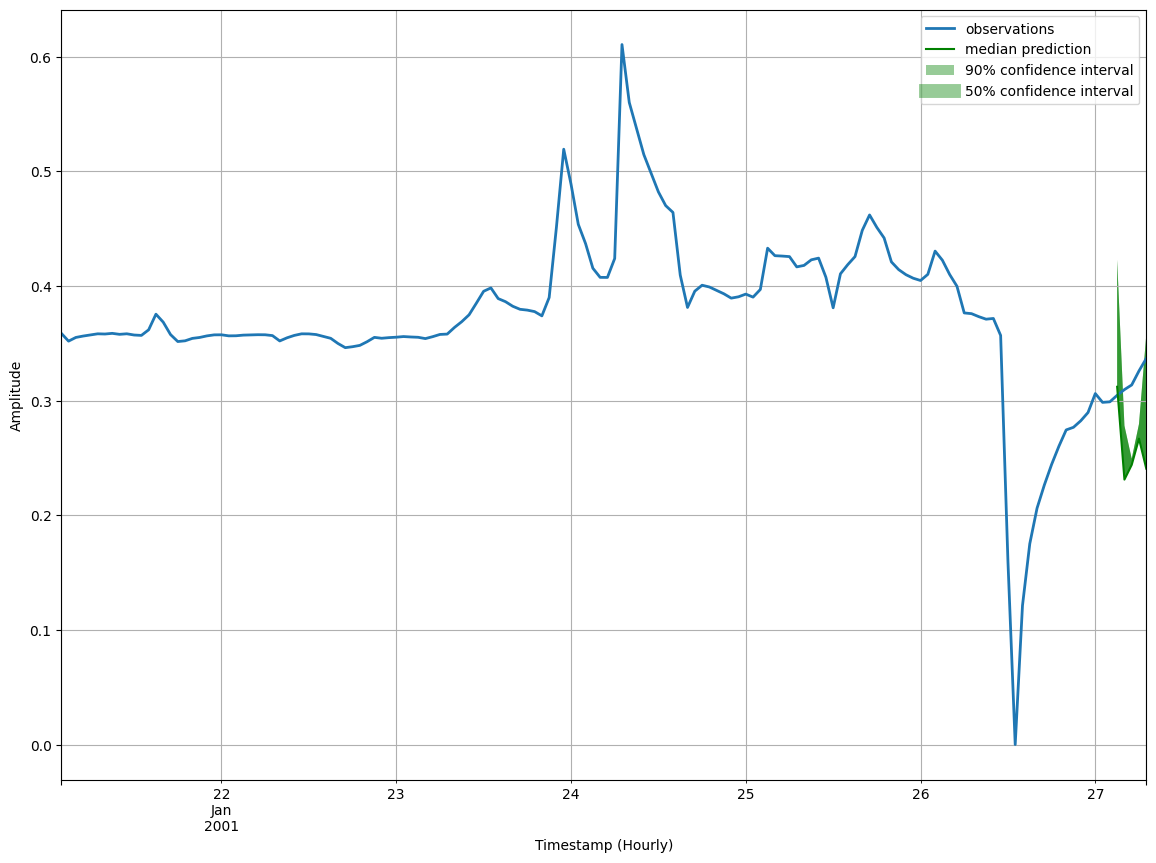

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Performance metrics {'MSE': 0.003135579824447632, 'abs_error': 0.3109419047832489, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 2.080262984360588, 'MAPE': 0.19340288648238307, 'sMAPE': 0.21938994802301987, 'OWA': nan, 'MSIS': 41.991872959567644, 'QuantileLoss[0.1]': 0.07407035231590271, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.3109419047832489, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.2836527913808823, 'Coverage[0.9]': 0.4, 'RMSE': 0.0559962483068967, 'NRMSE': 0.17599357266896948, 'ND': 0.19545515412166828, 'wQuantileLoss[0.1]': 0.04655992616319421, 'wQuantileLoss[0.5]': 0.19545515412166828, 'wQuantileLoss[0.9]': 0.17830147433823307, 'mean_wQuantileLoss': 0.14010551820769854, 'MAE_Coverage': 0.3}


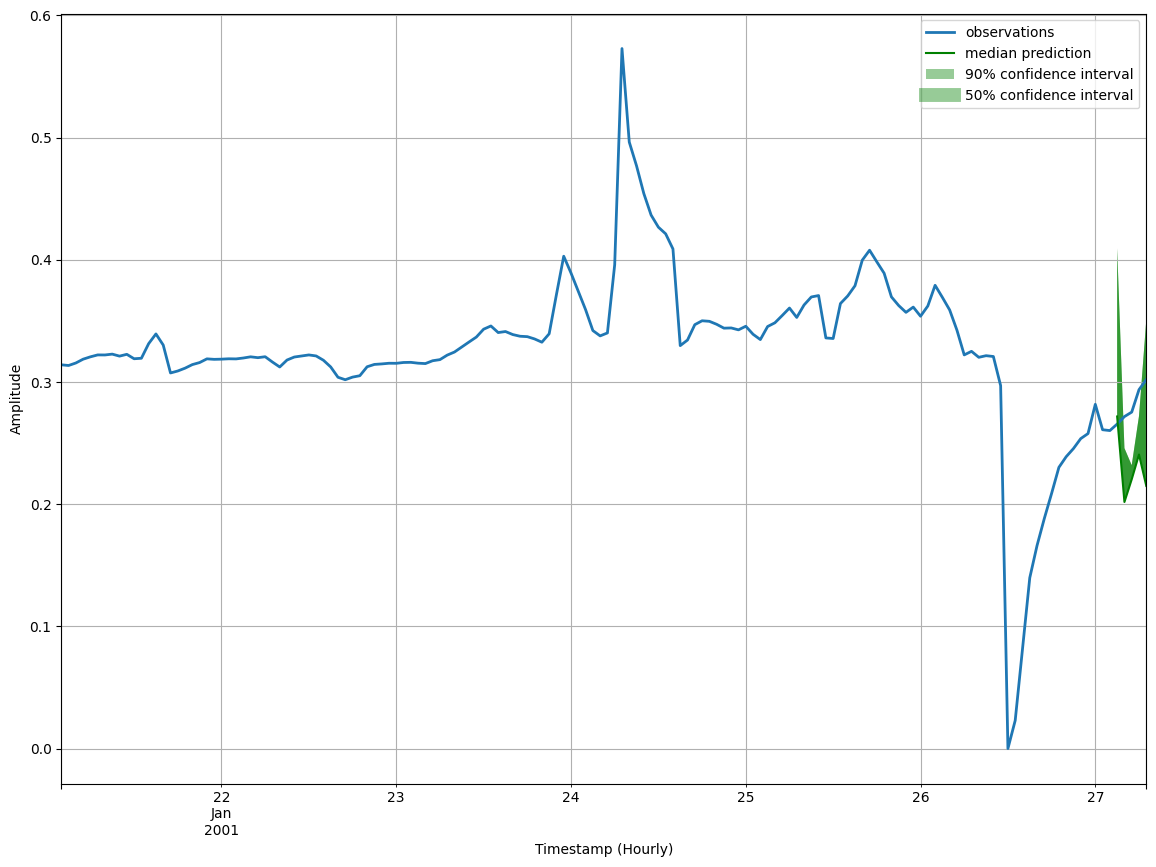

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Performance metrics {'MSE': 0.002422371320426464, 'abs_error': 0.2712435722351074, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 1.8317583547950698, 'MAPE': 0.189897829718059, 'sMAPE': 0.2151727039789295, 'OWA': nan, 'MSIS': 28.66920362099944, 'QuantileLoss[0.1]': 0.06419706642627716, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.2712435871362686, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.20210551619529724, 'Coverage[0.9]': 0.4, 'RMSE': 0.04921759157482682, 'NRMSE': 0.17475337552975145, 'ND': 0.19261702298767866, 'wQuantileLoss[0.1]': 0.04558798469463339, 'wQuantileLoss[0.5]': 0.19261703356937573, 'wQuantileLoss[0.9]': 0.14352031474199706, 'mean_wQuantileLoss': 0.12724177766866873, 'MAE_Coverage': 0.3}


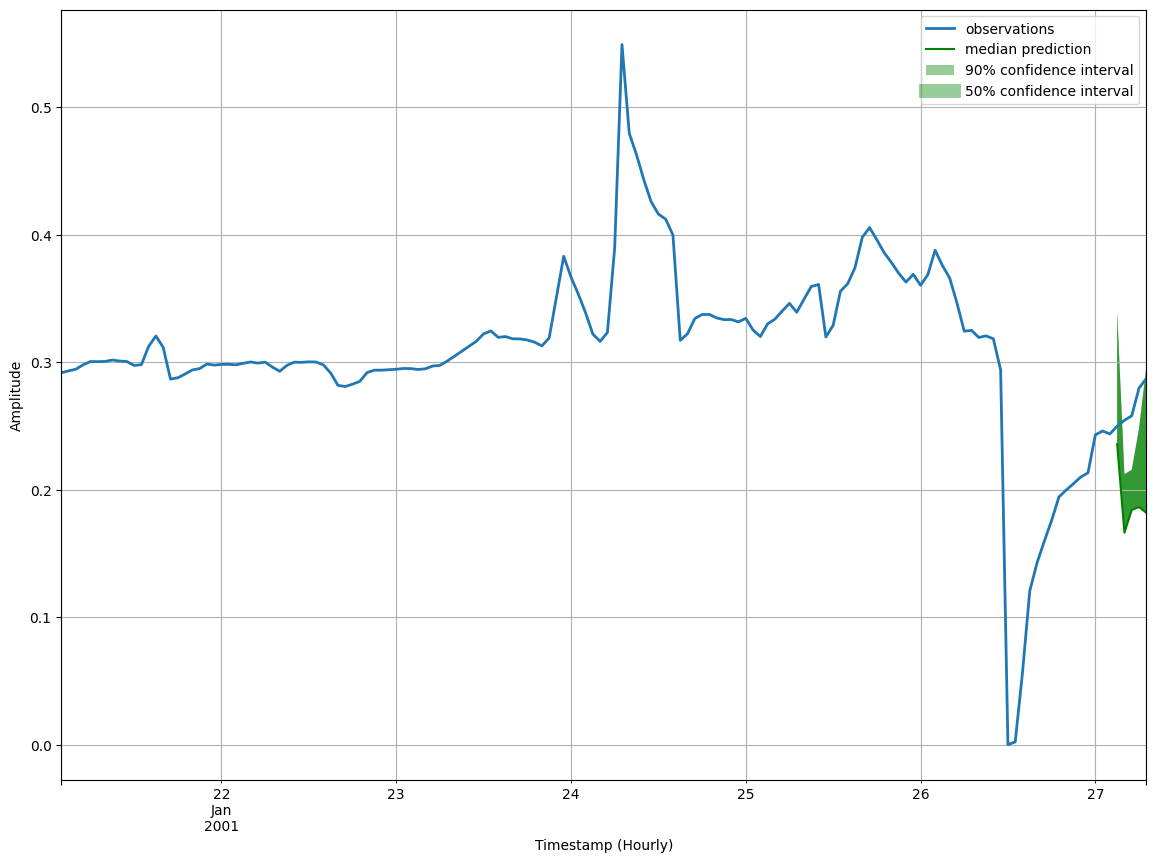

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Performance metrics {'MSE': 0.0030634231865406037, 'abs_error': 0.37461382150650024, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 2.2854675926702055, 'MAPE': 0.27792483477896524, 'sMAPE': 0.33217712700486635, 'OWA': nan, 'MSIS': 30.61464316953848, 'QuantileLoss[0.1]': 0.0749227672815323, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.37461383640766144, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.2295526146888733, 'Coverage[0.9]': 0.4, 'RMSE': 0.055348199487793674, 'NRMSE': 0.20828961905141605, 'ND': 0.28195377950891504, 'wQuantileLoss[0.1]': 0.05639075814486027, 'wQuantileLoss[0.5]': 0.2819537907243013, 'wQuantileLoss[0.9]': 0.17277319626755536, 'mean_wQuantileLoss': 0.17037258171223899, 'MAE_Coverage': 0.3666666666666667}


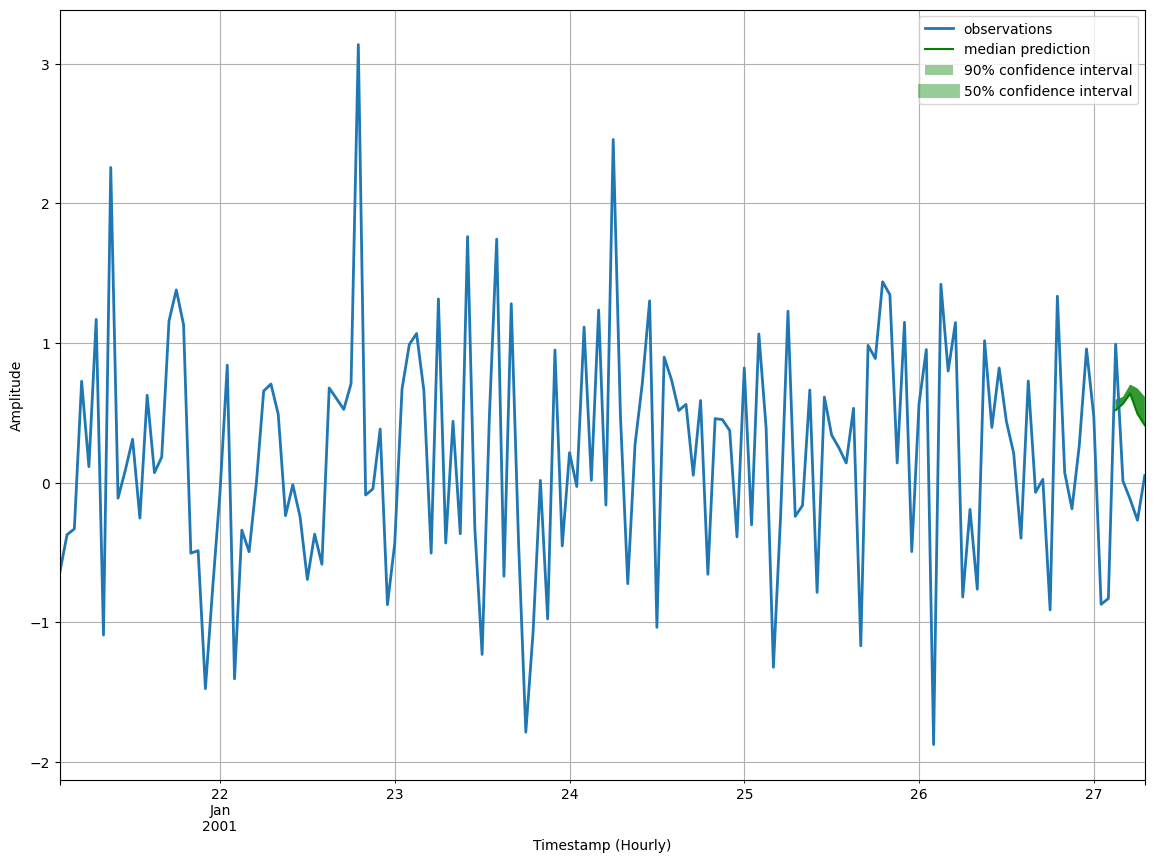

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Performance metrics {'MSE': 0.4171470642089844, 'abs_error': 2.9040539264678955, 'abs_target_sum': 1.444701075553894, 'abs_target_mean': 0.28894021511077883, 'seasonal_error': 0.8858772464615702, 'MASE': 0.6556334837738436, 'MAPE': 12.573267046535948, 'sMAPE': 1.6188298494576365, 'OWA': nan, 'MSIS': 25.679286226618313, 'QuantileLoss[0.1]': 4.471672666072846, 'Coverage[0.1]': 0.8, 'QuantileLoss[0.5]': 2.9040538668632507, 'Coverage[0.5]': 0.8, 'QuantileLoss[0.9]': 1.3013617873191832, 'Coverage[0.9]': 0.8, 'RMSE': 0.6458692315081934, 'NRMSE': 2.235304044681247, 'ND': 2.0101417349291375, 'wQuantileLoss[0.1]': 3.0952234629979904, 'wQuantileLoss[0.5]': 2.0101416936717134, 'wQuantileLoss[0.9]': 0.9007827358474451, 'mean_wQuantileLoss': 2.002049297505716, 'MAE_Coverage': 0.3666666666666667}


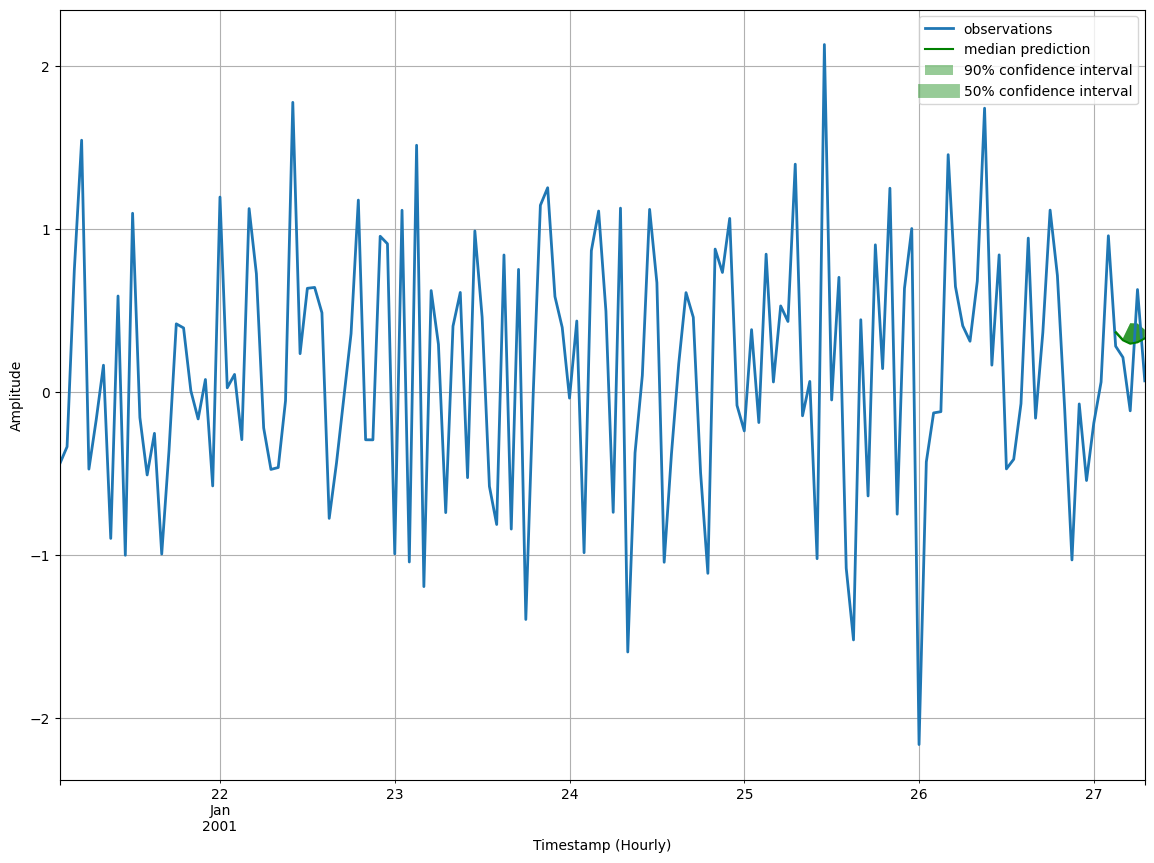

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Performance metrics {'MSE': 0.07990573048591613, 'abs_error': 1.185971975326538, 'abs_target_sum': 1.307075023651123, 'abs_target_mean': 0.2614150047302246, 'seasonal_error': 0.9381590877324624, 'MASE': 0.2528296087165859, 'MAPE': 1.7358563368422346, 'sMAPE': 0.9319825835474347, 'OWA': nan, 'MSIS': 9.198965822148635, 'QuantileLoss[0.1]': 1.6166178852319717, 'Coverage[0.1]': 0.8, 'QuantileLoss[0.5]': 1.1859719306230545, 'Coverage[0.5]': 0.8, 'QuantileLoss[0.9]': 0.5888620227575302, 'Coverage[0.9]': 0.8, 'RMSE': 0.2826760168212297, 'NRMSE': 1.0813304963613166, 'ND': 0.9073480510810303, 'wQuantileLoss[0.1]': 1.2368210362678234, 'wQuantileLoss[0.5]': 0.9073480168798691, 'wQuantileLoss[0.9]': 0.4505189159782353, 'mean_wQuantileLoss': 0.8648959897086425, 'MAE_Coverage': 0.3666666666666667}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 1 (R553)
----------*****-----------------------*****--------

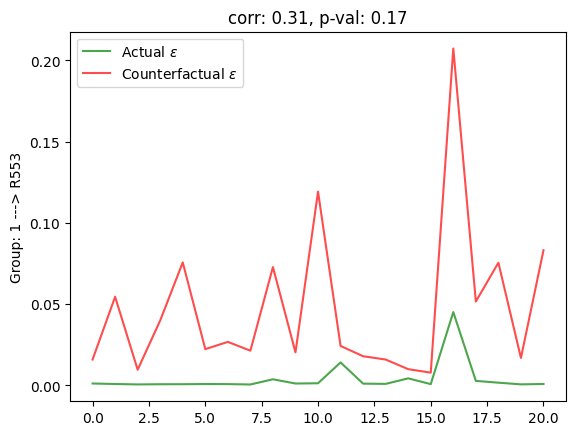

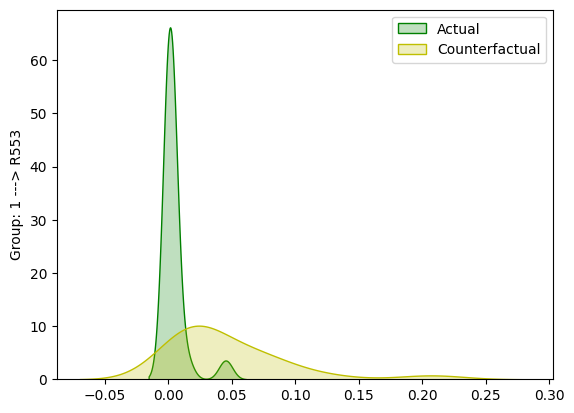

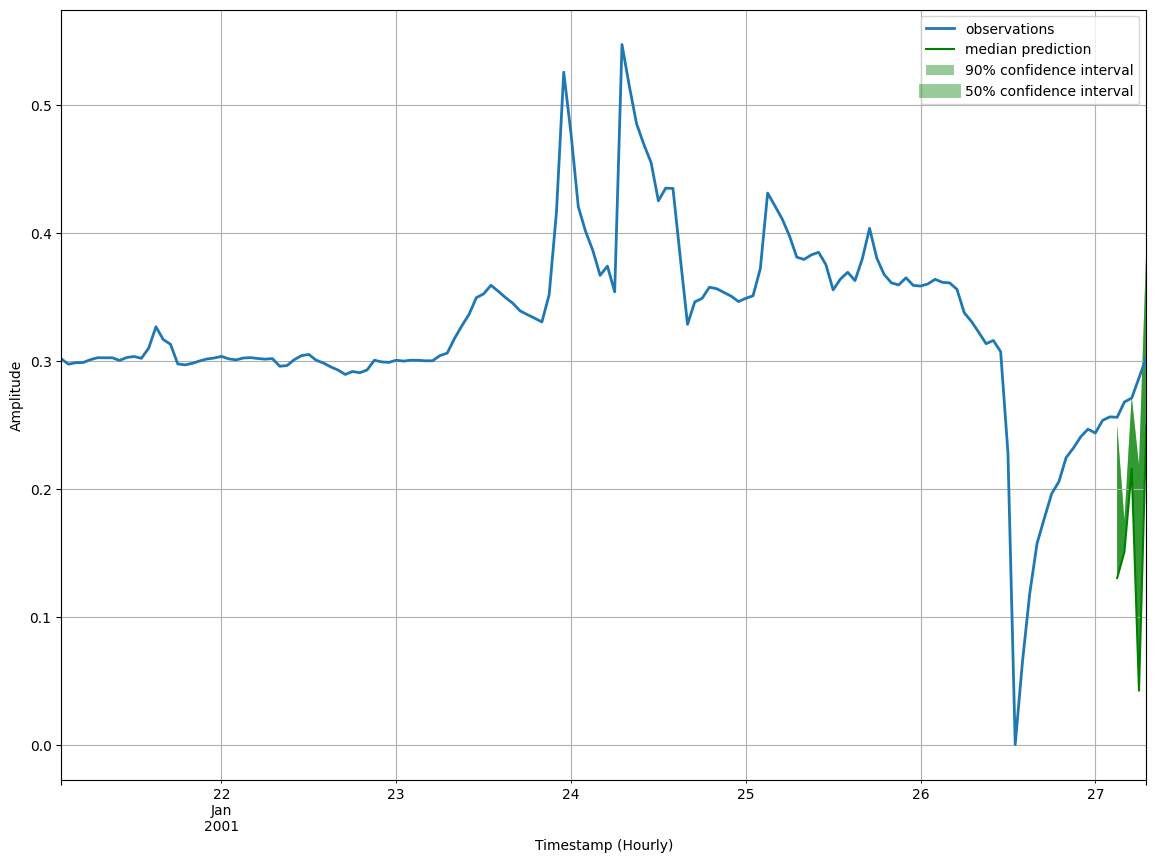

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Performance metrics {'MSE': 0.00812399685382843, 'abs_error': 0.5956712365150452, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 3.6768477987153996, 'MAPE': 0.4324713700701069, 'sMAPE': 0.6239322939483525, 'OWA': nan, 'MSIS': 44.12265776254513, 'QuantileLoss[0.1]': 0.11913425028324129, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.5956712514162064, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.31575531363487247, 'Coverage[0.9]': 0.4, 'RMSE': 0.09013321726105437, 'NRMSE': 0.3259019345273131, 'ND': 0.4307632950907914, 'wQuantileLoss[0.1]': 0.08615266117333145, 'wQuantileLoss[0.5]': 0.4307633058666572, 'wQuantileLoss[0.9]': 0.2283403847725465, 'mean_wQuantileLoss': 0.2484187839375117, 'MAE_Coverage': 0.3666666666666667}


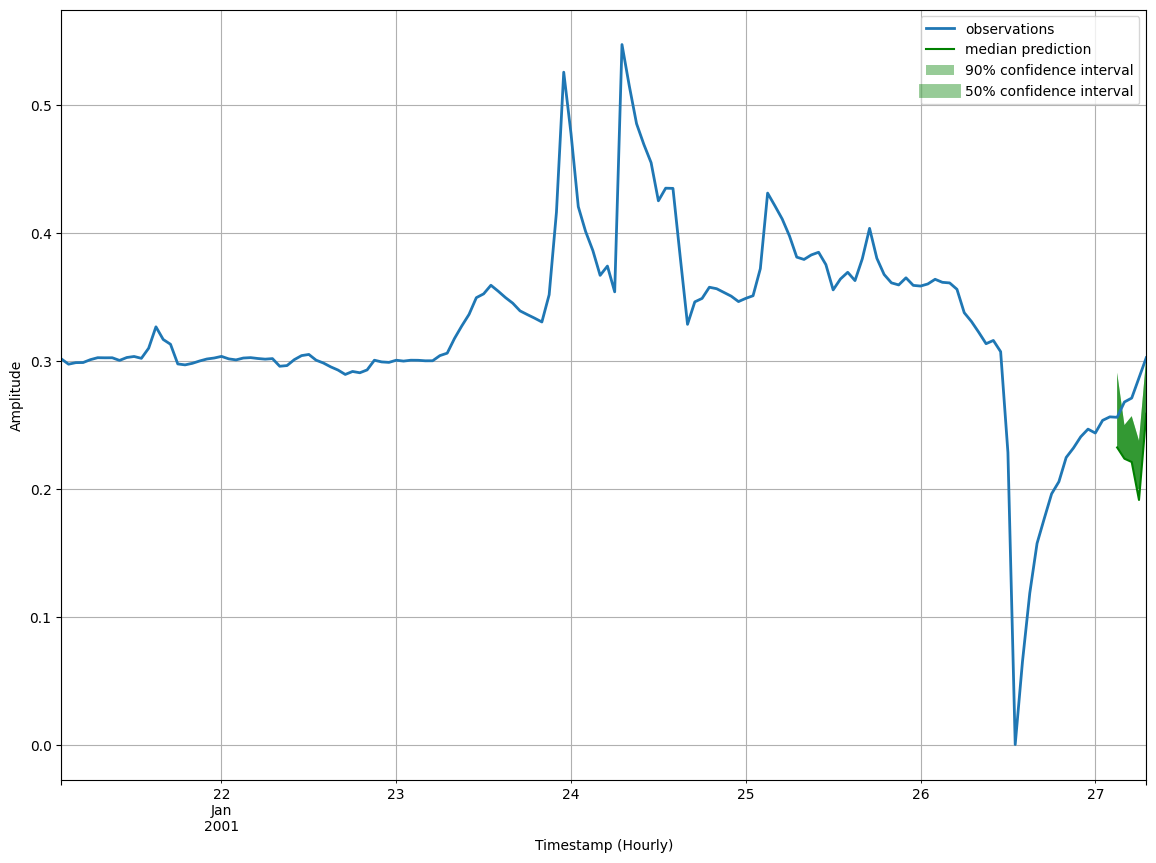

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Performance metrics {'MSE': 0.001544065773487091, 'abs_error': 0.2569432854652405, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 1.586011369433834, 'MAPE': 0.1839733500245096, 'sMAPE': 0.20715004613628468, 'OWA': nan, 'MSIS': 21.37058647506672, 'QuantileLoss[0.1]': 0.05138865411281586, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.2569432705640793, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.15331405699253084, 'Coverage[0.9]': 0.4, 'RMSE': 0.03929460234545059, 'NRMSE': 0.1420806591622383, 'ND': 0.18581010717589902, 'wQuantileLoss[0.1]': 0.03716201928000665, 'wQuantileLoss[0.5]': 0.18581009640003324, 'wQuantileLoss[0.9]': 0.11086999728275769, 'mean_wQuantileLoss': 0.11128070432093252, 'MAE_Coverage': 0.3666666666666667}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 2 (R1144)
----------*****----------------------

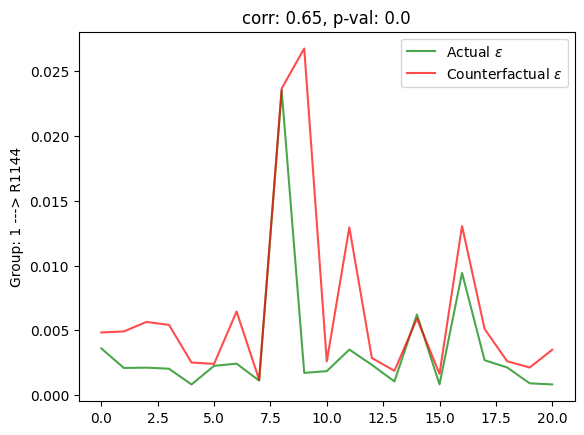

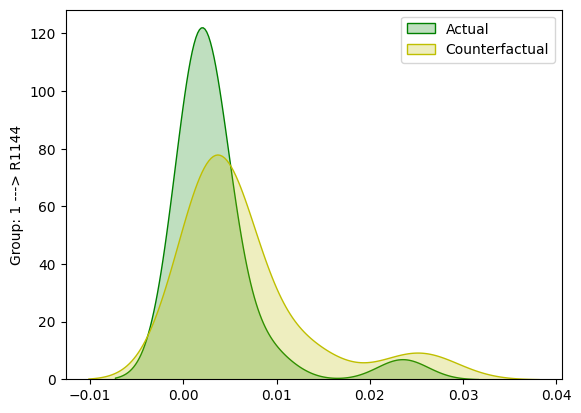

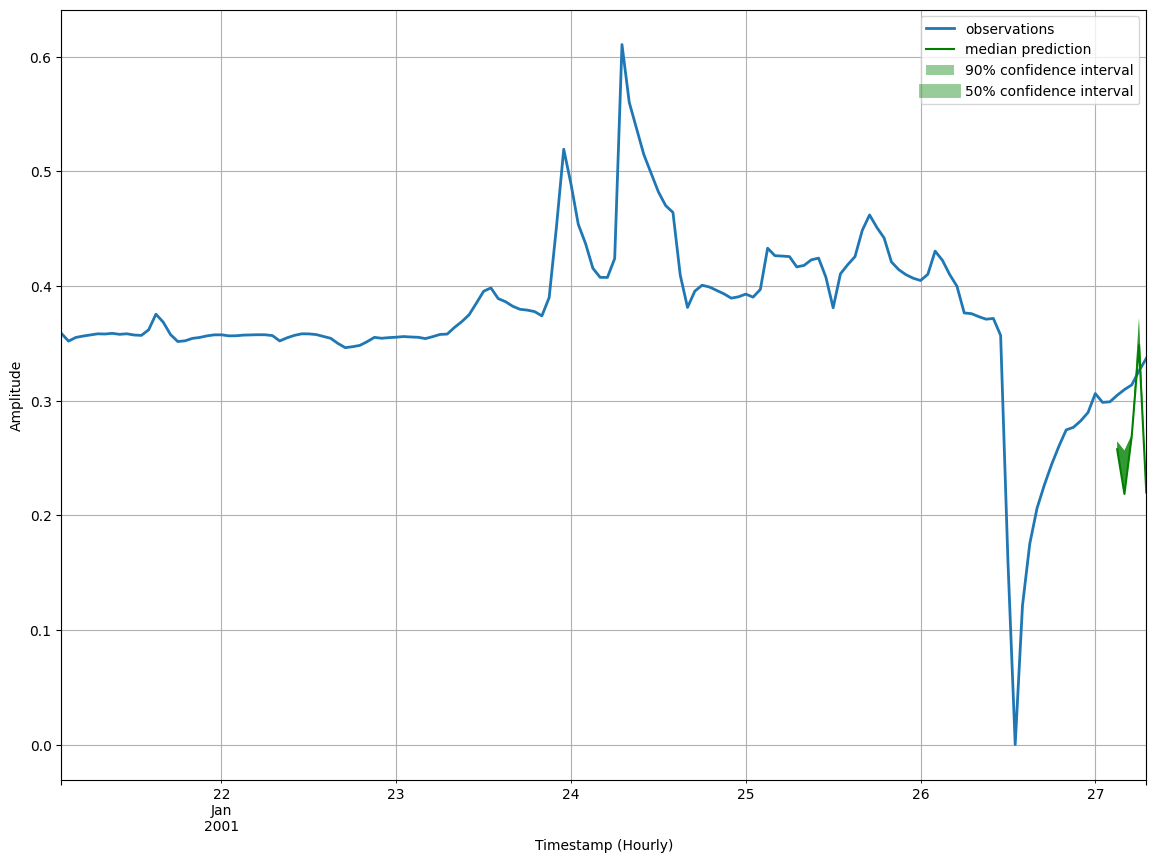

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Performance metrics {'MSE': 0.004771348088979721, 'abs_error': 0.32256725430488586, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 2.158038877278506, 'MAPE': 0.20163531959128891, 'sMAPE': 0.23069759635795792, 'OWA': nan, 'MSIS': 74.28006310339588, 'QuantileLoss[0.1]': 0.10054212212562562, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.32256725430488586, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.46515513658523555, 'Coverage[0.9]': 0.2, 'RMSE': 0.06907494545042885, 'NRMSE': 0.21709930217303294, 'ND': 0.20276273938925626, 'wQuantileLoss[0.1]': 0.06319983145881344, 'wQuantileLoss[0.5]': 0.20276273938925626, 'wQuantileLoss[0.9]': 0.2923921398601105, 'mean_wQuantileLoss': 0.18611823690272675, 'MAE_Coverage': 0.3666666666666667}


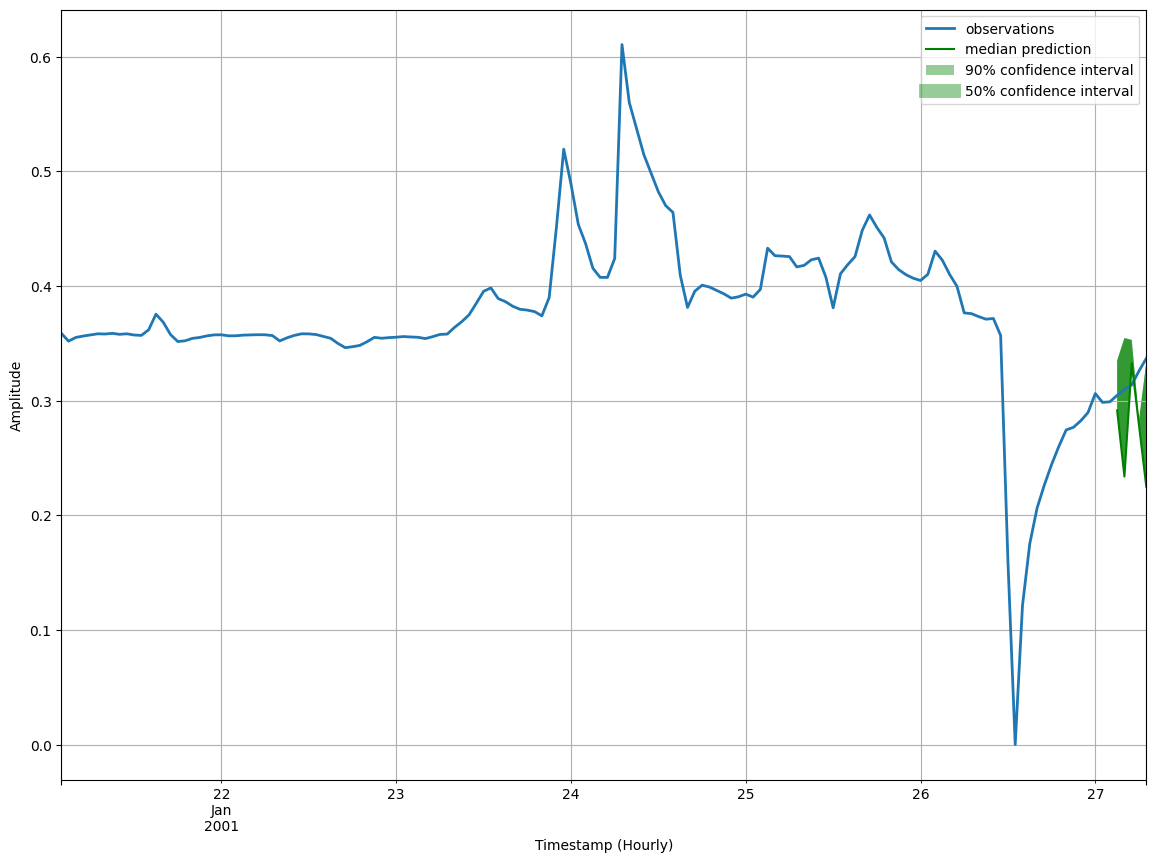

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Performance metrics {'MSE': 0.0013063604012131691, 'abs_error': 0.26712602376937866, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 1.7871260542840839, 'MAPE': 0.16515077754763893, 'sMAPE': 0.18732716248474243, 'OWA': nan, 'MSIS': 19.49637678151173, 'QuantileLoss[0.1]': 0.08362592160701753, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.26712600886821747, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.10668761134147643, 'Coverage[0.9]': 0.6, 'RMSE': 0.03614360802705188, 'NRMSE': 0.1135976587389383, 'ND': 0.16791290380158838, 'wQuantileLoss[0.1]': 0.05256646706290681, 'wQuantileLoss[0.5]': 0.16791289443485874, 'wQuantileLoss[0.9]': 0.06706282812590622, 'mean_wQuantileLoss': 0.09584739654122391, 'MAE_Coverage': 0.23333333333333336}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 3 (R1145)
----------*****---------------

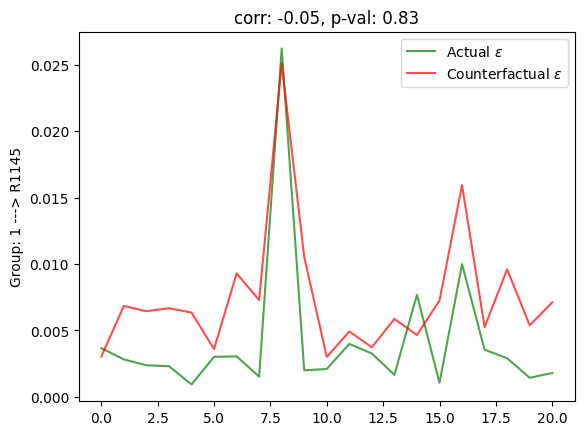

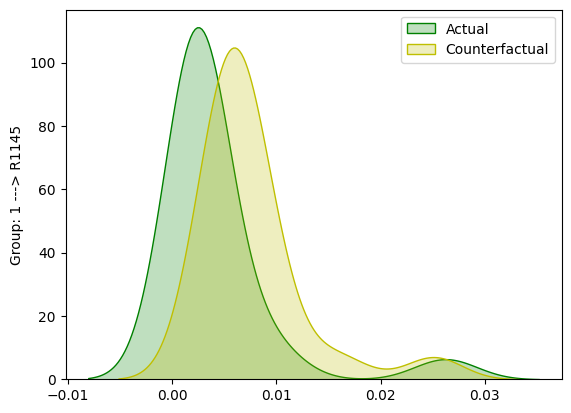

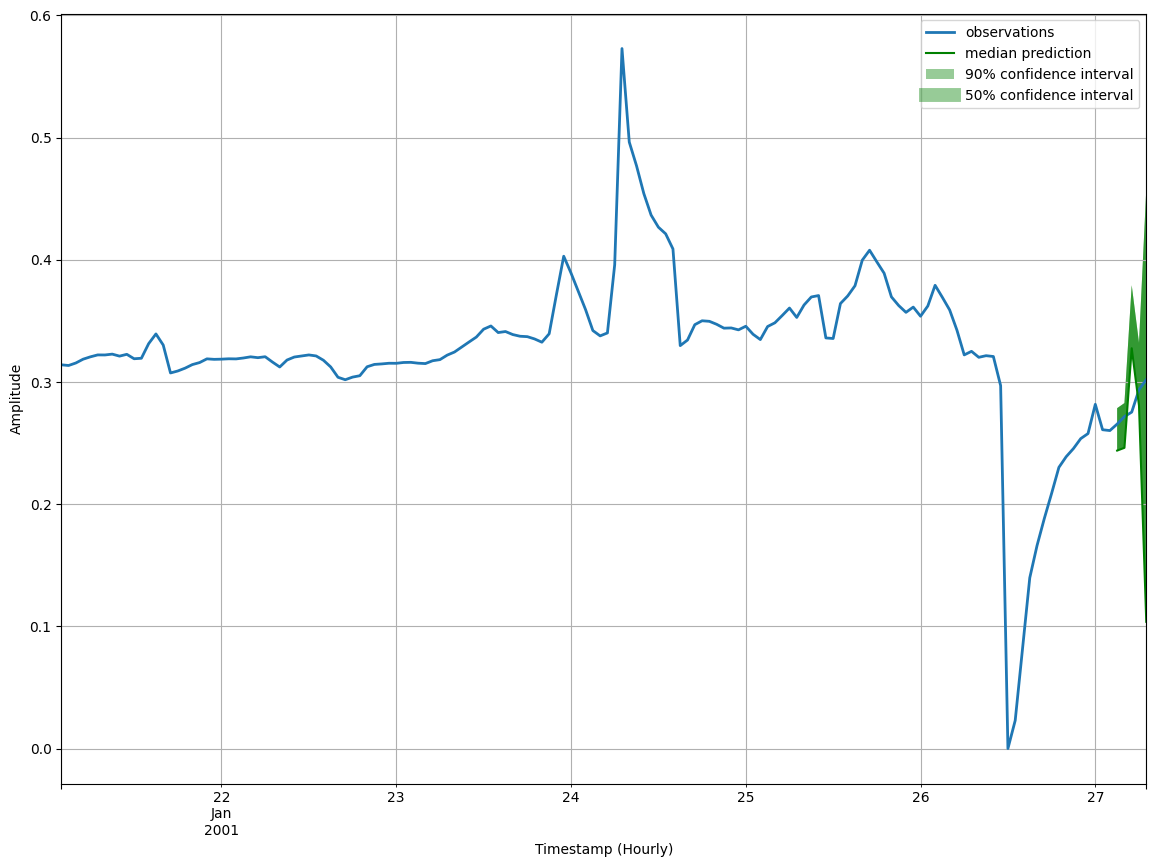

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Performance metrics {'MSE': 0.0013558397069573403, 'abs_error': 0.3106980323791504, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 2.098201671432033, 'MAPE': 0.21324086682835777, 'sMAPE': 0.2759270990013841, 'OWA': nan, 'MSIS': 17.68022010499574, 'QuantileLoss[0.1]': 0.145739221572876, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.3106980323791504, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.06437337994575498, 'Coverage[0.9]': 1.0, 'RMSE': 0.036821728733960064, 'NRMSE': 0.1307402736137034, 'ND': 0.22063464786228557, 'wQuantileLoss[0.1]': 0.10349316210736614, 'wQuantileLoss[0.5]': 0.22063464786228557, 'wQuantileLoss[0.9]': 0.045713189450471294, 'mean_wQuantileLoss': 0.12328033314004101, 'MAE_Coverage': 0.16666666666666666}


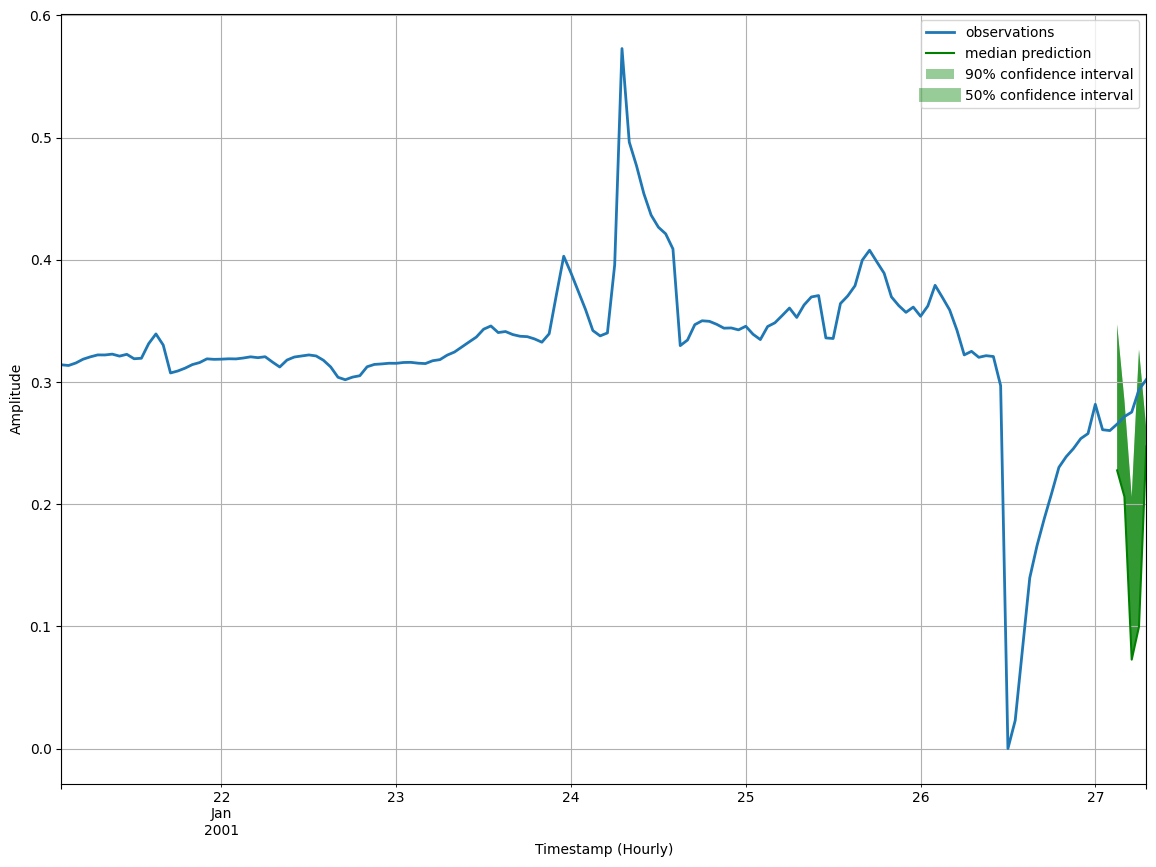

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Performance metrics {'MSE': 0.005681630223989487, 'abs_error': 0.5545799732208252, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 3.745181834092469, 'MAPE': 0.39218686433595695, 'sMAPE': 0.555298397475688, 'OWA': nan, 'MSIS': 33.53801390822406, 'QuantileLoss[0.1]': 0.11091599464416504, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.5545799732208252, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.22324036955833437, 'Coverage[0.9]': 0.6, 'RMSE': 0.07537658936294138, 'NRMSE': 0.2676342544528564, 'ND': 0.3938214740727259, 'wQuantileLoss[0.1]': 0.07876429481454518, 'wQuantileLoss[0.5]': 0.3938214740727259, 'wQuantileLoss[0.9]': 0.15852871660945497, 'mean_wQuantileLoss': 0.21037149516557532, 'MAE_Coverage': 0.3}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 4 (R1146)
----------*****-----------------------*****-----------

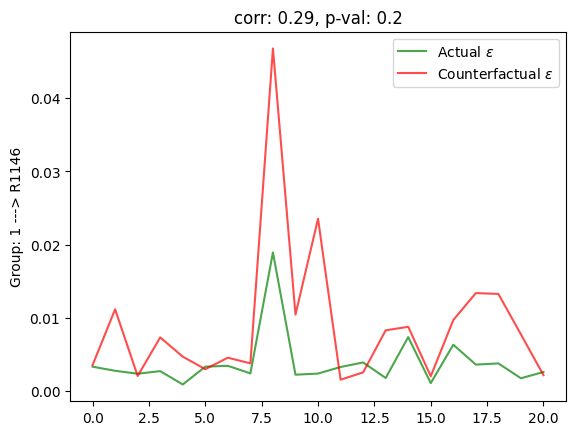

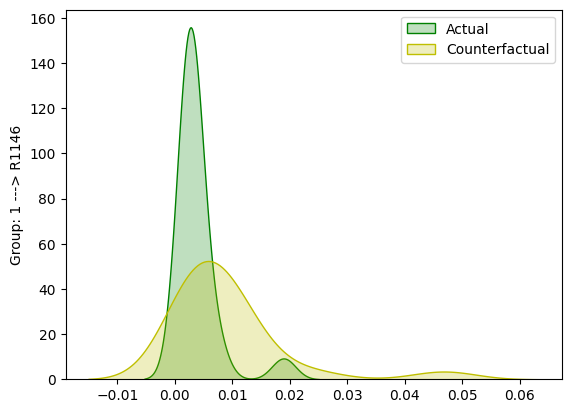

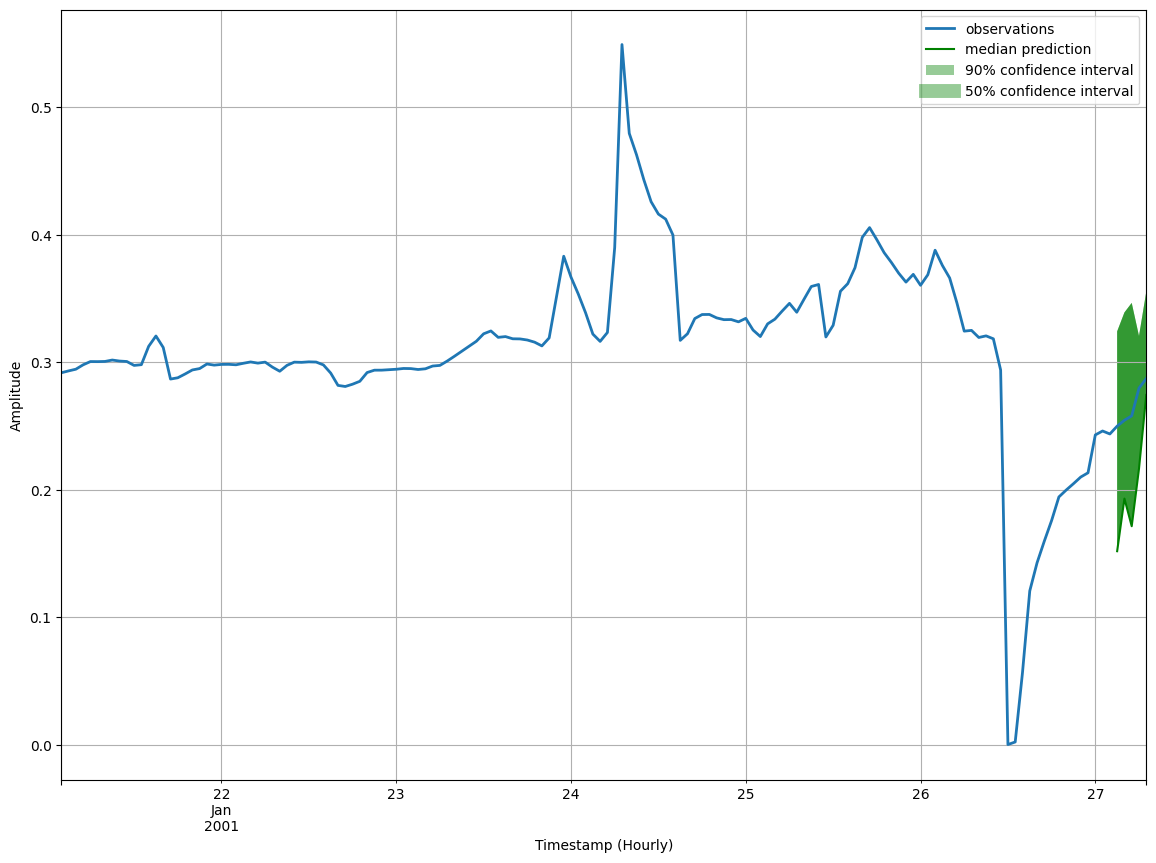

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Performance metrics {'MSE': 0.0002324767643585801, 'abs_error': 0.32212111353874207, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 1.965216774295821, 'MAPE': 0.24814976982789488, 'sMAPE': 0.29349558758410466, 'OWA': nan, 'MSIS': 4.140471152641923, 'QuantileLoss[0.1]': 0.06442422568798066, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.32212112843990326, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.07130972146987913, 'Coverage[0.9]': 1.0, 'RMSE': 0.015247188736241842, 'NRMSE': 0.05737912276942709, 'ND': 0.24244504662594973, 'wQuantileLoss[0.1]': 0.04848901156826721, 'wQuantileLoss[0.5]': 0.24244505784133602, 'wQuantileLoss[0.9]': 0.053671392591187576, 'mean_wQuantileLoss': 0.11486848733359693, 'MAE_Coverage': 0.2333333333333333}


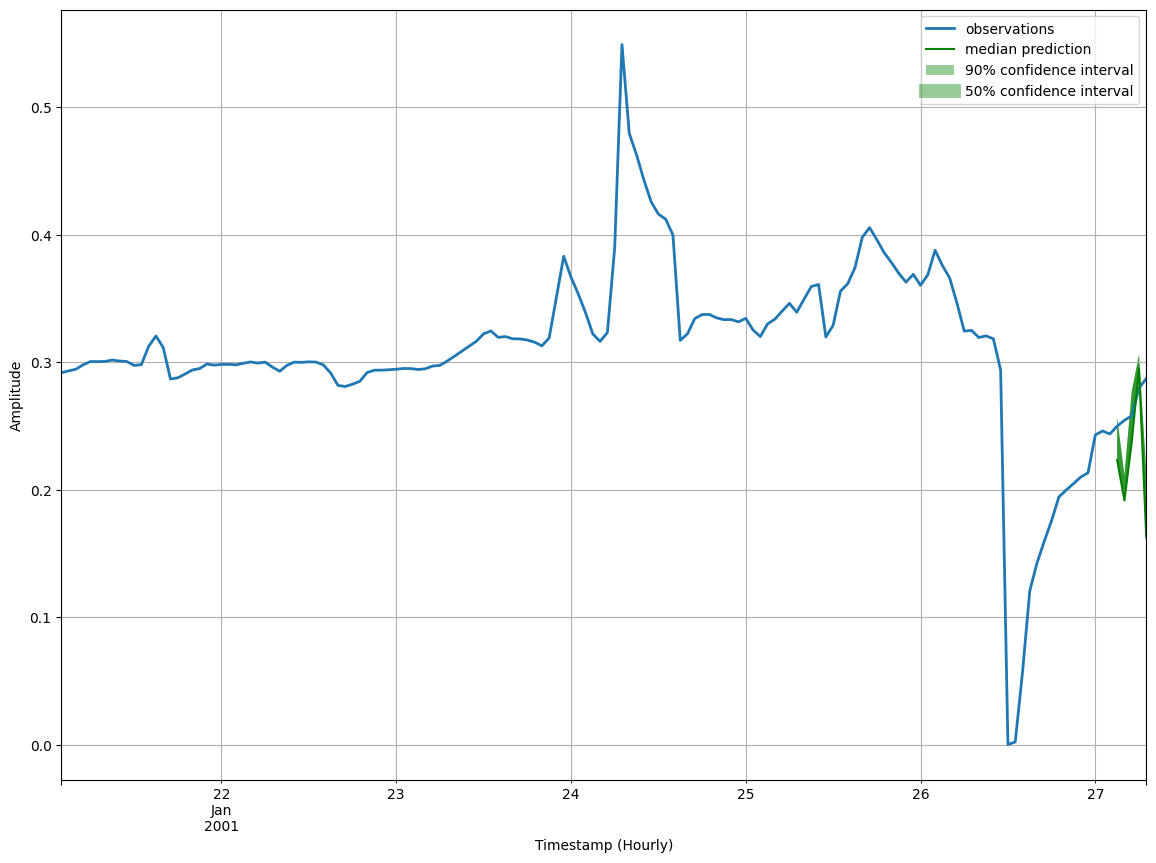

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Performance metrics {'MSE': 0.0026275081560015678, 'abs_error': 0.25007015466690063, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 1.5256437471710058, 'MAPE': 0.18452267116443158, 'sMAPE': 0.21711762374955187, 'OWA': nan, 'MSIS': 33.135082781669205, 'QuantileLoss[0.1]': 0.0747249722480774, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.25007015466690063, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.22006119191646578, 'Coverage[0.9]': 0.6, 'RMSE': 0.051259225081945664, 'NRMSE': 0.1929017486385239, 'ND': 0.18821576034531906, 'wQuantileLoss[0.1]': 0.05624188735032731, 'wQuantileLoss[0.5]': 0.18821576034531906, 'wQuantileLoss[0.9]': 0.16562945951797348, 'mean_wQuantileLoss': 0.13669570240453996, 'MAE_Coverage': 0.23333333333333336}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 5 (R1147)
----------*****----------------

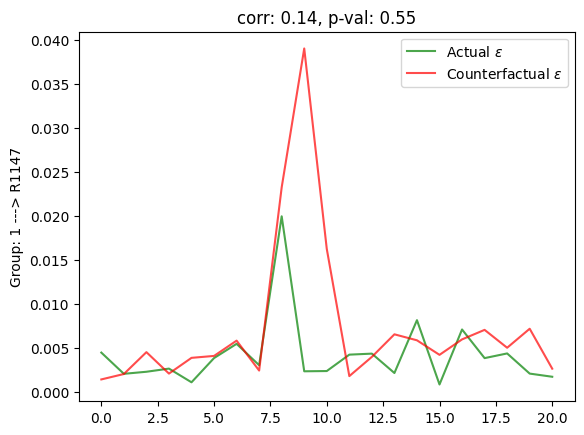

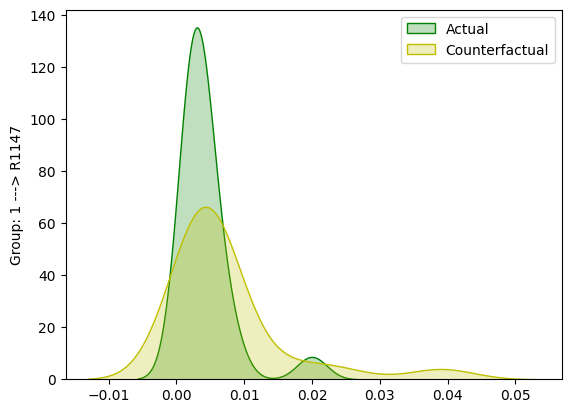

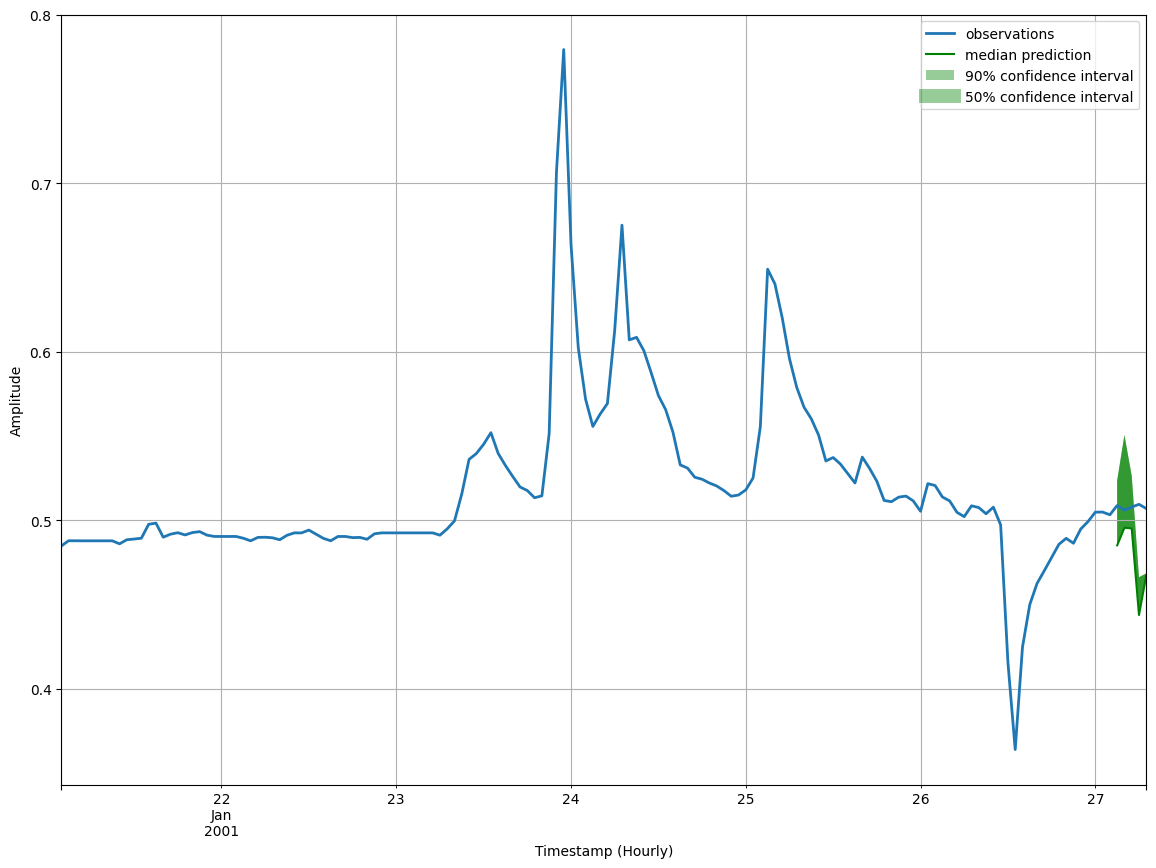

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Performance metrics {'MSE': 0.0009624820202589035, 'abs_error': 0.152096688747406, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 1.8175171293954386, 'MAPE': 0.0598466420259773, 'sMAPE': 0.06258740537184539, 'OWA': nan, 'MSIS': 40.85208818144417, 'QuantileLoss[0.1]': 0.030419337749481204, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.152096688747406, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.1627478003501892, 'Coverage[0.9]': 0.6, 'RMSE': 0.03102389434385863, 'NRMSE': 0.061097957652780824, 'ND': 0.05990735363664468, 'wQuantileLoss[0.1]': 0.011981470727328936, 'wQuantileLoss[0.5]': 0.05990735363664468, 'wQuantileLoss[0.9]': 0.06410257915184962, 'mean_wQuantileLoss': 0.045330467838607745, 'MAE_Coverage': 0.3}


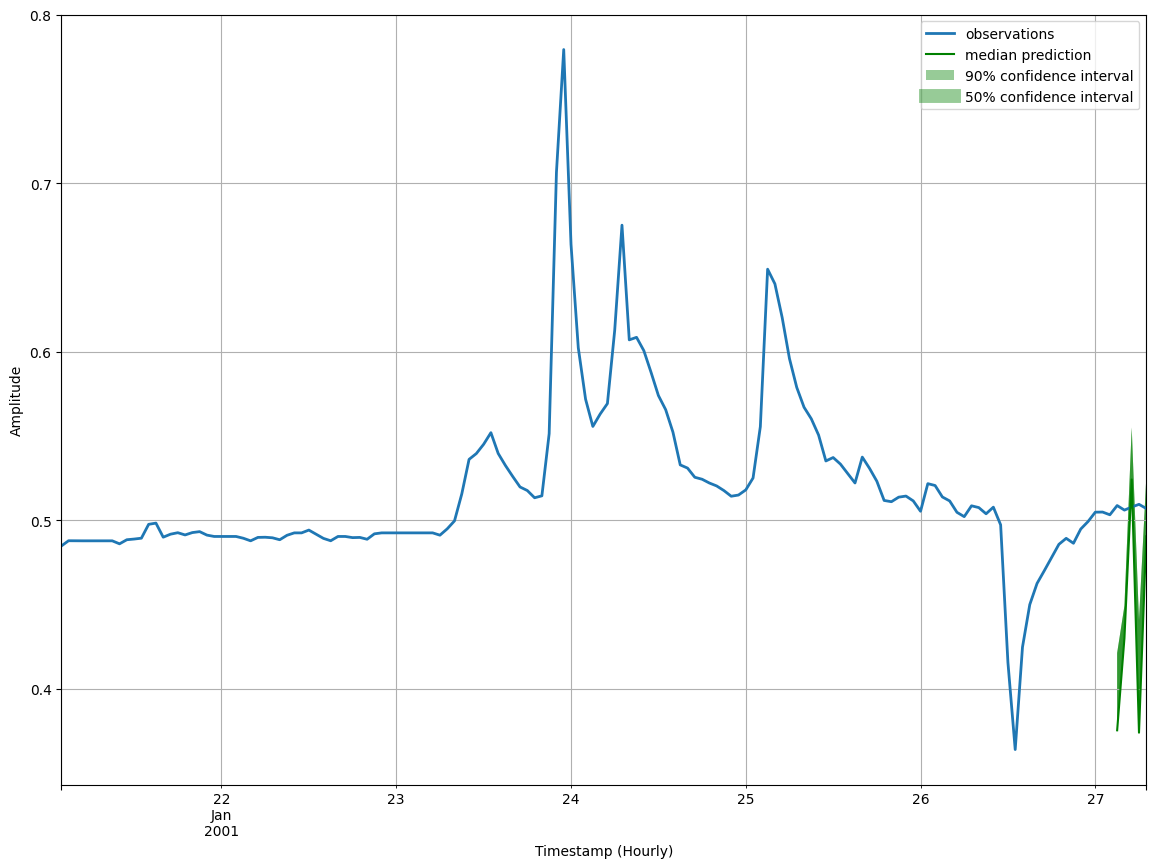

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Performance metrics {'MSE': 0.00561281181871891, 'abs_error': 0.37778690457344055, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 4.514458374986935, 'MAPE': 0.14864876450729397, 'sMAPE': 0.16717374713817207, 'OWA': nan, 'MSIS': 112.05418867117892, 'QuantileLoss[0.1]': 0.1017029345035553, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.37778690457344055, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.39674202799797065, 'Coverage[0.9]': 0.4, 'RMSE': 0.07491870139503827, 'NRMSE': 0.14754368341063862, 'ND': 0.14880148856600556, 'wQuantileLoss[0.1]': 0.040058424107493336, 'wQuantileLoss[0.5]': 0.14880148856600556, 'wQuantileLoss[0.9]': 0.15626747149812206, 'mean_wQuantileLoss': 0.11504246139054031, 'MAE_Coverage': 0.3}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 1 (R553)
----------*****-----------------------*****-------

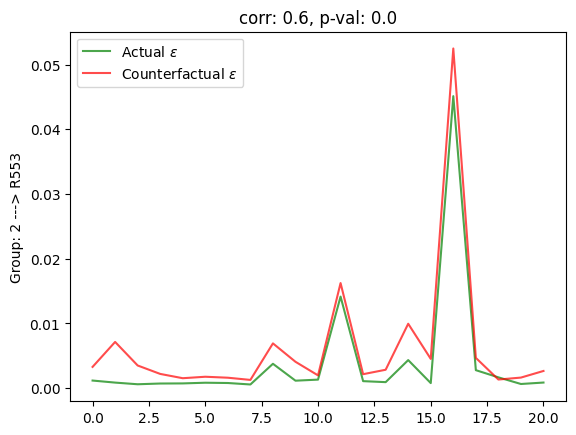

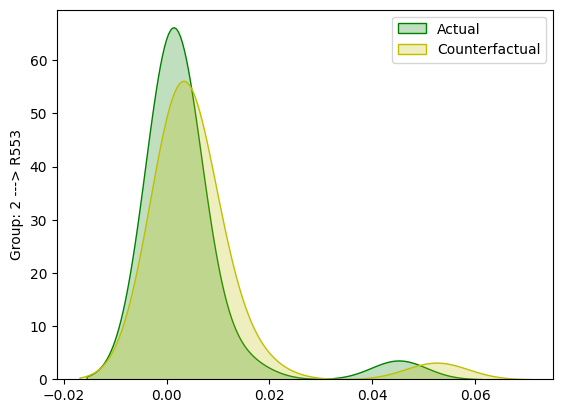

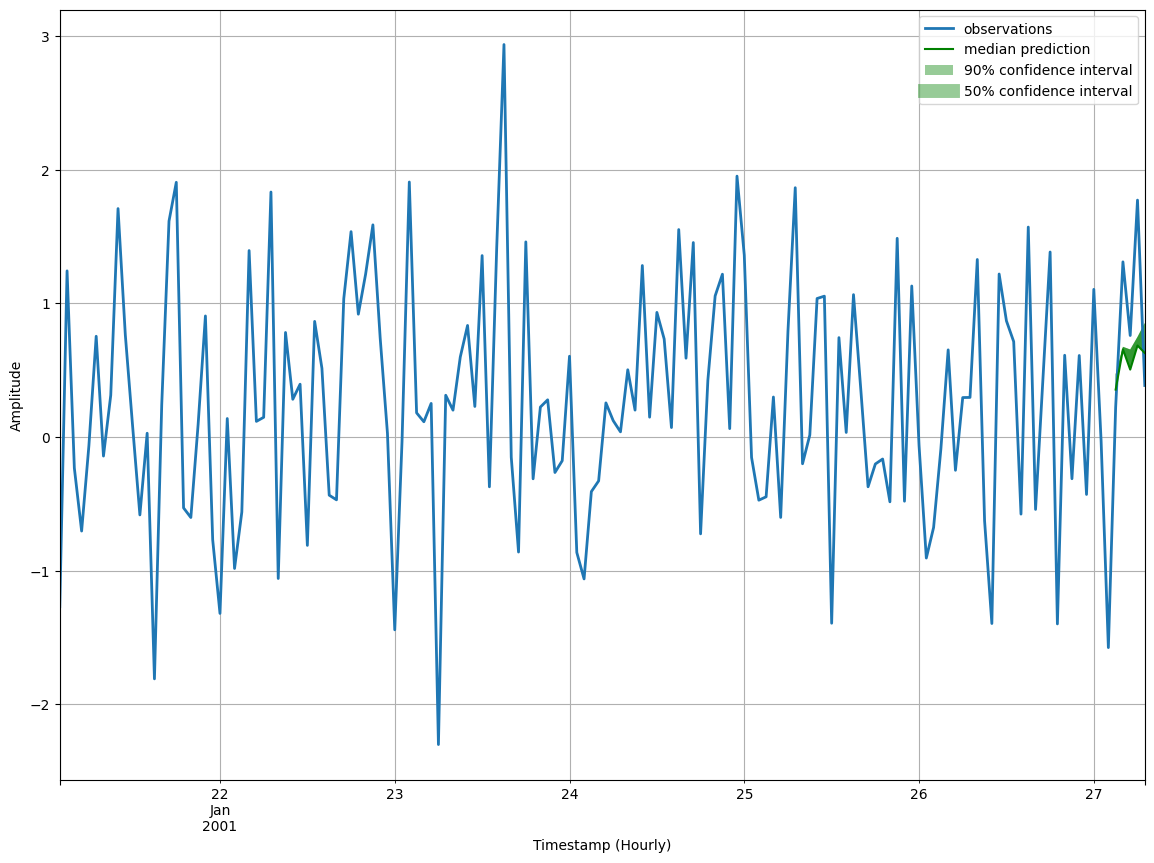

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Performance metrics {'MSE': 0.34569501876831055, 'abs_error': 2.374992847442627, 'abs_target_sum': 4.452101707458496, 'abs_target_mean': 0.8904203414916992, 'seasonal_error': 0.8825562902763064, 'MASE': 0.5382076755011458, 'MAPE': 0.5355333865564166, 'sMAPE': 0.5790089565640307, 'OWA': nan, 'MSIS': 19.537139576499822, 'QuantileLoss[0.1]': 1.0764692008495331, 'Coverage[0.1]': 0.4, 'QuantileLoss[0.5]': 2.374992936849594, 'Coverage[0.5]': 0.4, 'QuantileLoss[0.9]': 3.3204250574111938, 'Coverage[0.9]': 0.4, 'RMSE': 0.5879583478175223, 'NRMSE': 0.6603154941771997, 'ND': 0.5334543106829434, 'wQuantileLoss[0.1]': 0.2417889957559035, 'wQuantileLoss[0.5]': 0.533454330764912, 'wQuantileLoss[0.9]': 0.7458106924755488, 'mean_wQuantileLoss': 0.5070180063321215, 'MAE_Coverage': 0.3}


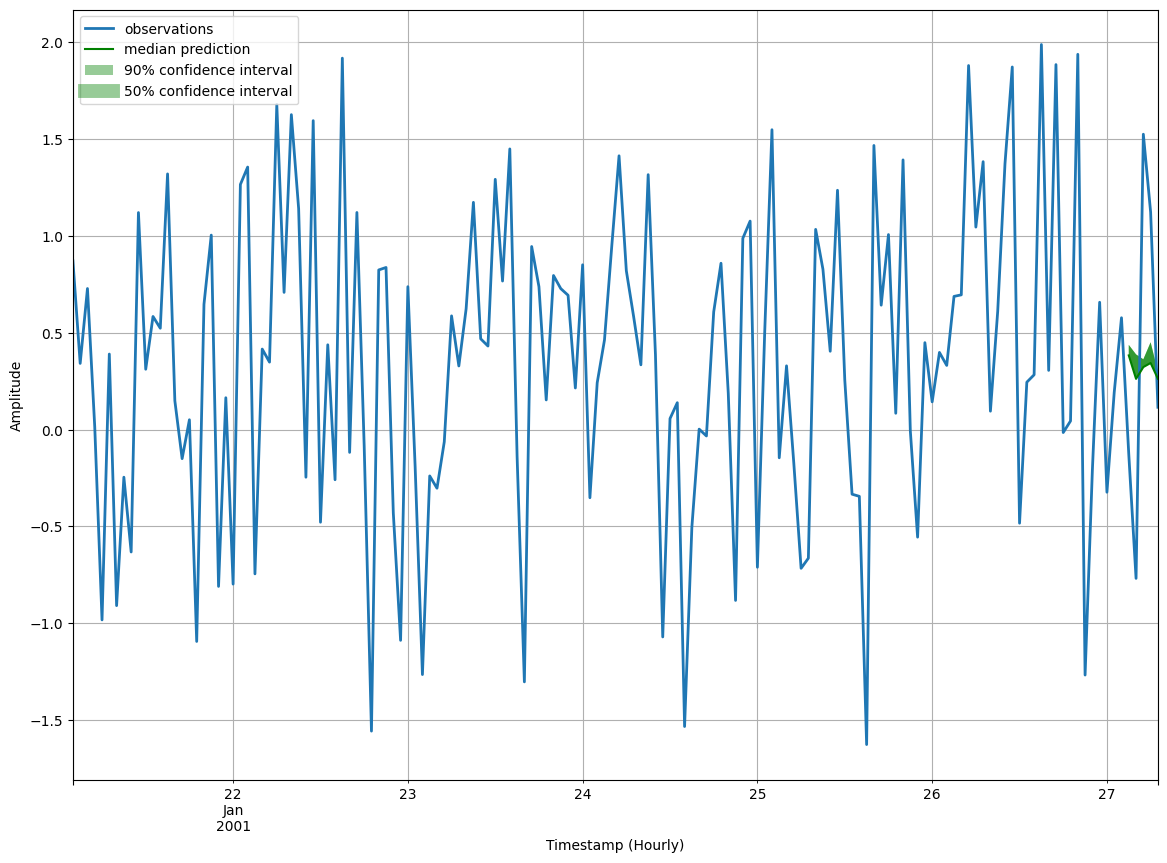

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Performance metrics {'MSE': 0.6876461982727051, 'abs_error': 3.6703743934631348, 'abs_target_sum': 3.659985065460205, 'abs_target_mean': 0.731997013092041, 'seasonal_error': 0.8675596880149482, 'MASE': 0.8461376073988107, 'MAPE': 1.6210125202870038, 'sMAPE': 1.4287694217443756, 'OWA': nan, 'MSIS': 32.57334741402862, 'QuantileLoss[0.1]': 3.435400214791298, 'Coverage[0.1]': 0.6, 'QuantileLoss[0.5]': 3.670374348759651, 'Coverage[0.5]': 0.6, 'QuantileLoss[0.9]': 3.684083852171898, 'Coverage[0.9]': 0.6, 'RMSE': 0.8292443537780074, 'NRMSE': 1.1328521004138832, 'ND': 1.0028386257913933, 'wQuantileLoss[0.1]': 0.9386377685558486, 'wQuantileLoss[0.5]': 1.0028386135772769, 'wQuantileLoss[0.9]': 1.0065843948214752, 'mean_wQuantileLoss': 0.9826869256515335, 'MAE_Coverage': 0.3}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statisti

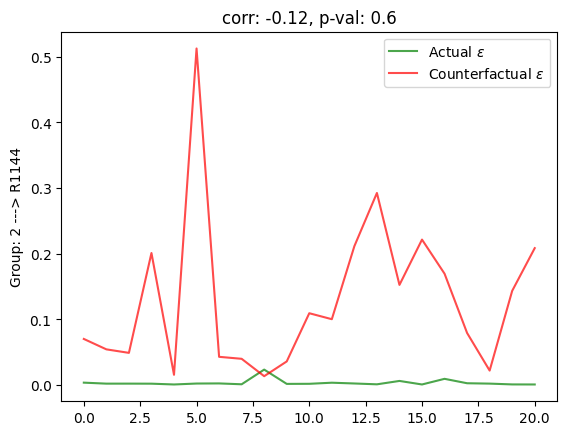

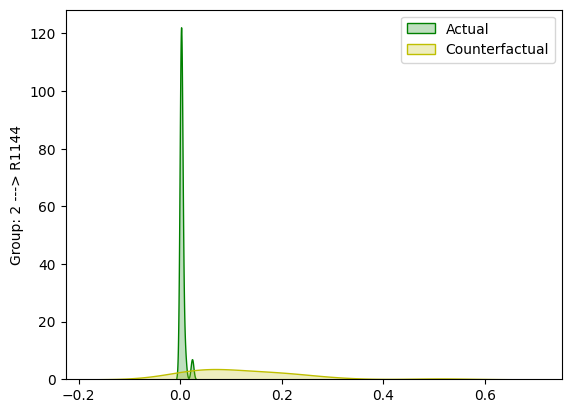

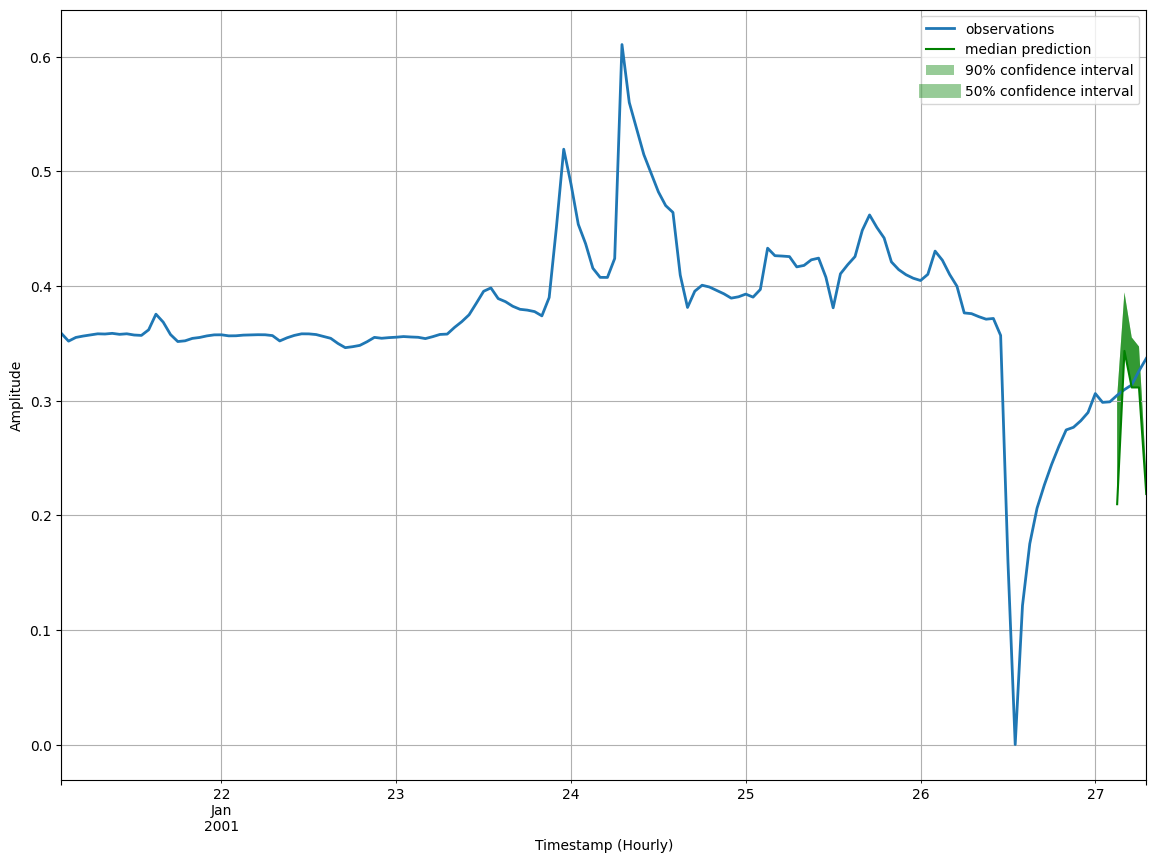

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Performance metrics {'MSE': 0.0036525271832942964, 'abs_error': 0.26363277435302734, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 1.7637555231842619, 'MAPE': 0.1646267041468769, 'sMAPE': 0.19017731809943988, 'OWA': nan, 'MSIS': 38.11053445697382, 'QuantileLoss[0.1]': 0.10672836303710936, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.26363277435302734, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.21423039734363555, 'Coverage[0.9]': 0.6, 'RMSE': 0.060436141366688, 'NRMSE': 0.18994794756884278, 'ND': 0.16571708010412206, 'wQuantileLoss[0.1]': 0.06708844425814227, 'wQuantileLoss[0.5]': 0.16571708010412206, 'wQuantileLoss[0.9]': 0.13466321099285386, 'mean_wQuantileLoss': 0.12248957845170605, 'MAE_Coverage': 0.23333333333333336}


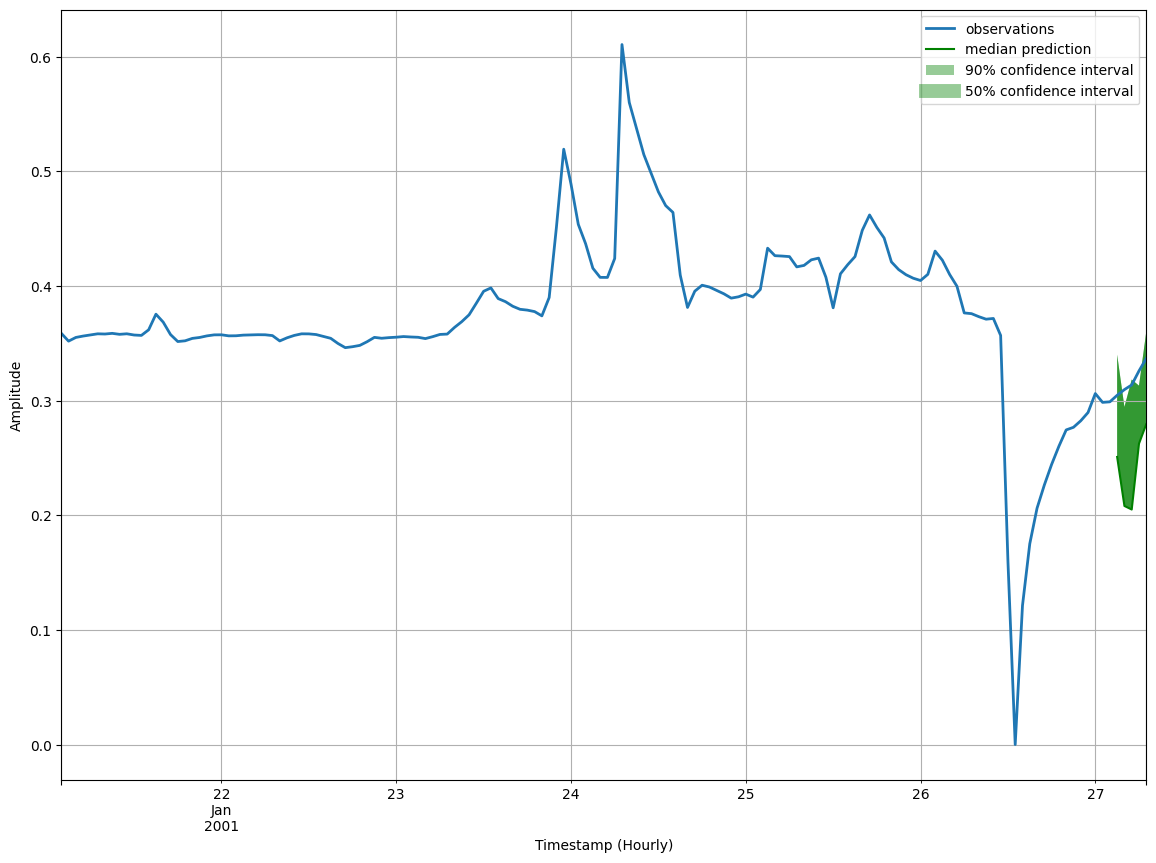

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Performance metrics {'MSE': 0.001587020605802536, 'abs_error': 0.38471680879592896, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 2.5738317173987264, 'MAPE': 0.24310205231494772, 'sMAPE': 0.2812487143666458, 'OWA': nan, 'MSIS': 10.309228680900757, 'QuantileLoss[0.1]': 0.07694336175918579, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.38471680879592896, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.06312357783317565, 'Coverage[0.9]': 0.6, 'RMSE': 0.0398374271985847, 'NRMSE': 0.12520715852592898, 'ND': 0.24182936426282414, 'wQuantileLoss[0.1]': 0.04836587285256482, 'wQuantileLoss[0.5]': 0.24182936426282414, 'wQuantileLoss[0.9]': 0.039678886776920316, 'mean_wQuantileLoss': 0.10995804129743643, 'MAE_Coverage': 0.3}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 3 (R1145)
----------*****-----------------------*****---

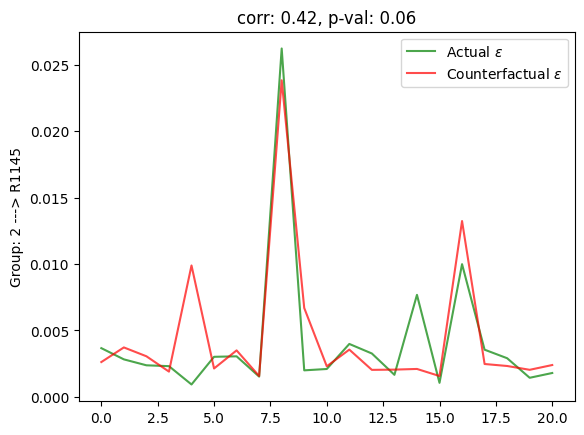

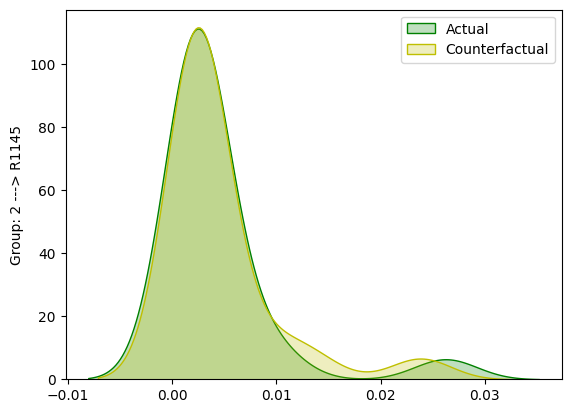

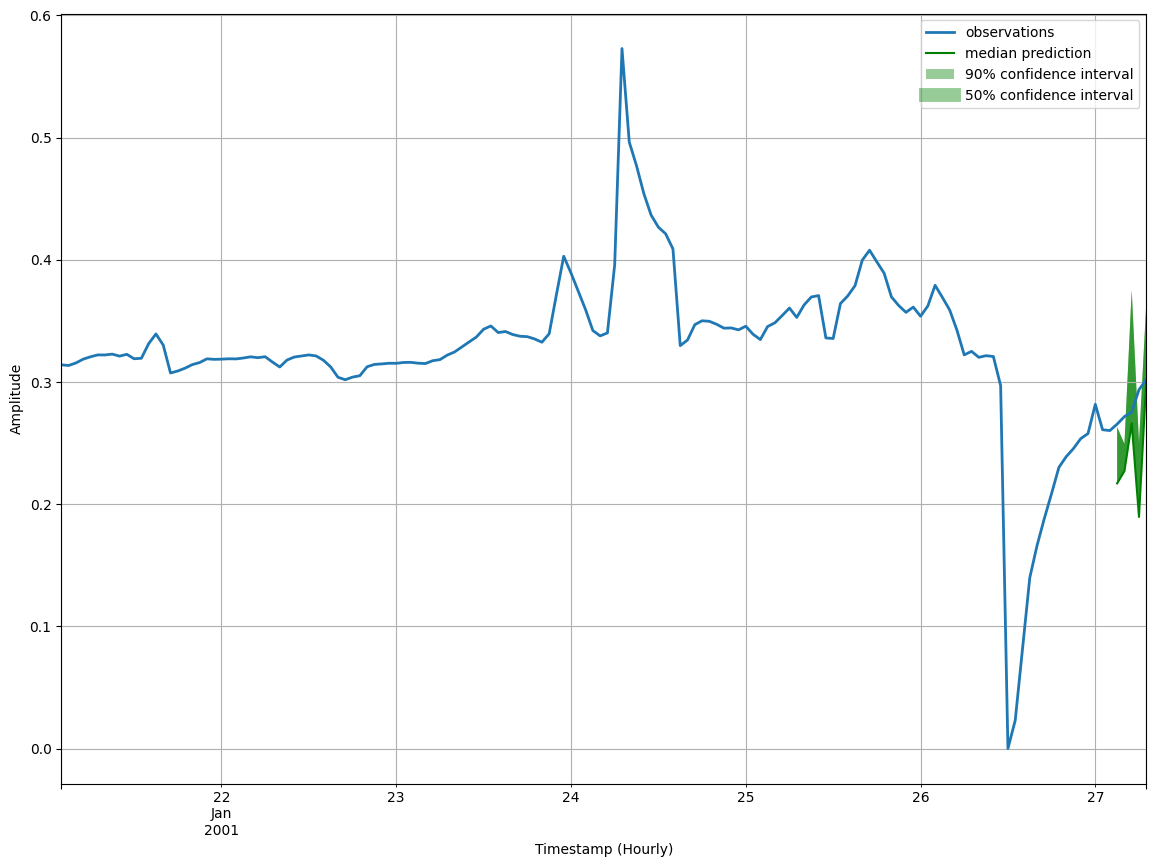

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Performance metrics {'MSE': 0.0020432118326425552, 'abs_error': 0.20701910555362701, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 1.398038571293293, 'MAPE': 0.14735028956549787, 'sMAPE': 0.16937490755137585, 'OWA': nan, 'MSIS': 20.393614348059273, 'QuantileLoss[0.1]': 0.04140382111072541, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.20701910555362701, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.15478621423244476, 'Coverage[0.9]': 0.4, 'RMSE': 0.04520190076360236, 'NRMSE': 0.16049514992603853, 'ND': 0.1470095806685093, 'wQuantileLoss[0.1]': 0.029401916133701862, 'wQuantileLoss[0.5]': 0.1470095806685093, 'wQuantileLoss[0.9]': 0.10991766381525203, 'mean_wQuantileLoss': 0.09544305353915439, 'MAE_Coverage': 0.3666666666666667}


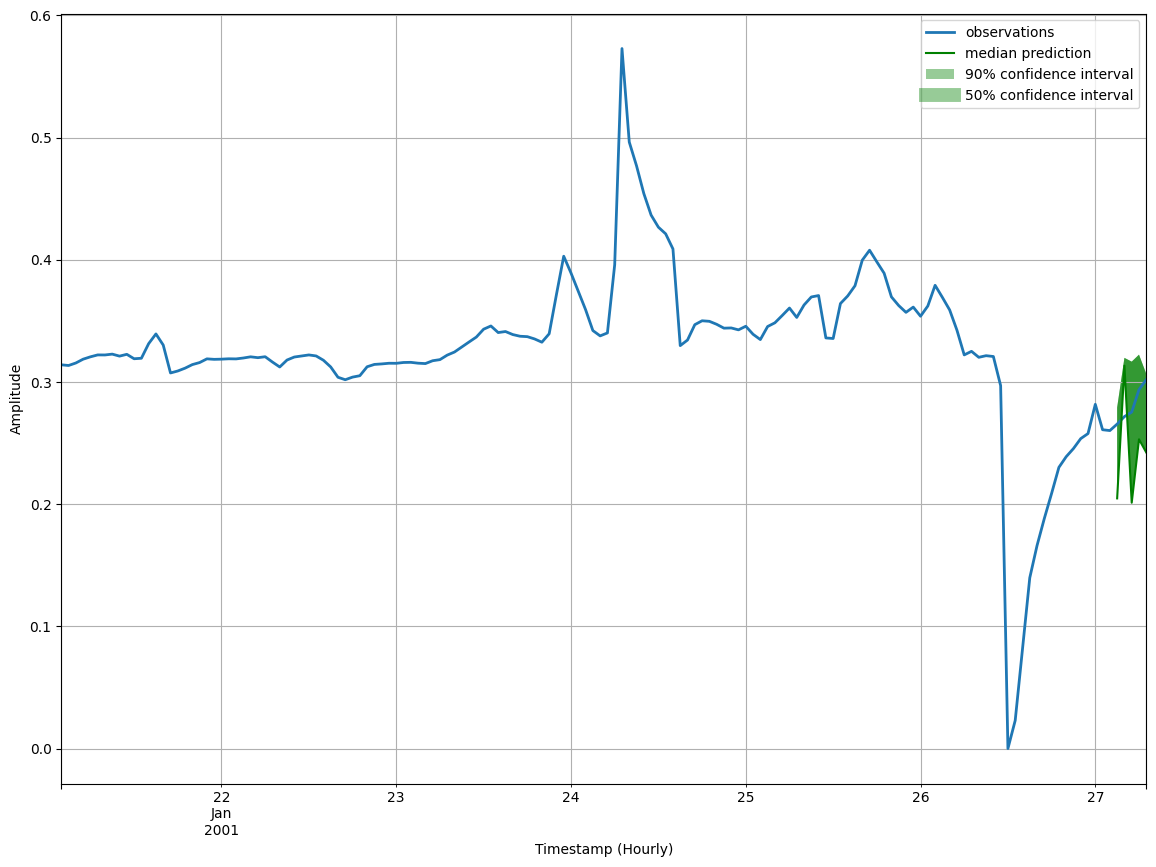

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Performance metrics {'MSE': 0.0007261222694069147, 'abs_error': 0.2769067883491516, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 1.8700031078280335, 'MAPE': 0.19751356842263437, 'sMAPE': 0.21602127104570945, 'OWA': nan, 'MSIS': 13.481702720443385, 'QuantileLoss[0.1]': 0.1220411390066147, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.2769067734479904, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.027254062891006462, 'Coverage[0.9]': 1.0, 'RMSE': 0.026946655996745027, 'NRMSE': 0.09567756048182416, 'ND': 0.19663861811501882, 'wQuantileLoss[0.1]': 0.08666454538913133, 'wQuantileLoss[0.5]': 0.19663860753332177, 'wQuantileLoss[0.9]': 0.019353809622572025, 'mean_wQuantileLoss': 0.10088565418167506, 'MAE_Coverage': 0.16666666666666666}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 4 (R1146)
----------*****-------------

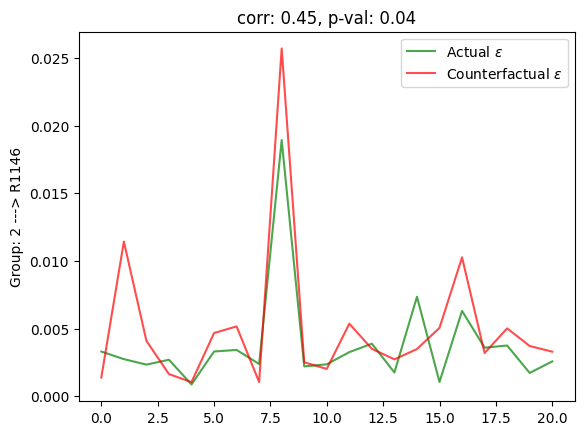

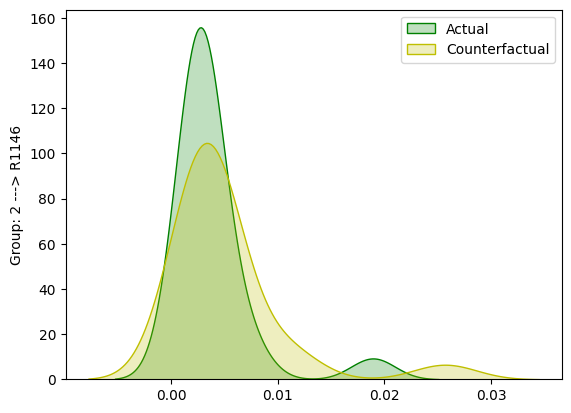

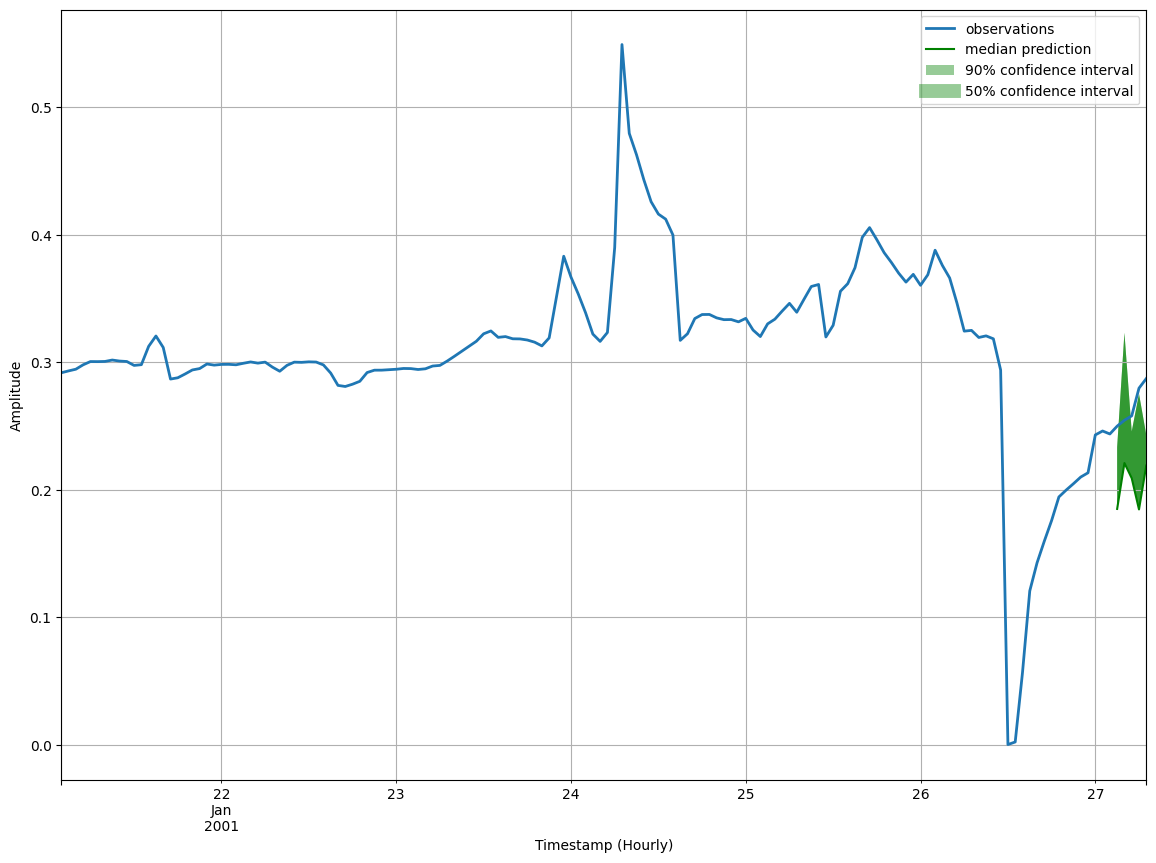

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Performance metrics {'MSE': 0.0017081864178180694, 'abs_error': 0.3107573390007019, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 1.895887942987201, 'MAPE': 0.231905306730695, 'sMAPE': 0.2658752788414273, 'OWA': nan, 'MSIS': 20.74202122571503, 'QuantileLoss[0.1]': 0.06215147078037262, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.3107573539018631, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.15312497615814208, 'Coverage[0.9]': 0.2, 'RMSE': 0.04133021192563703, 'NRMSE': 0.15553629886738693, 'ND': 0.23389208088751928, 'wQuantileLoss[0.1]': 0.046778418420581114, 'wQuantileLoss[0.5]': 0.23389209210290557, 'wQuantileLoss[0.9]': 0.11524979401821539, 'mean_wQuantileLoss': 0.13197343484723403, 'MAE_Coverage': 0.4333333333333333}


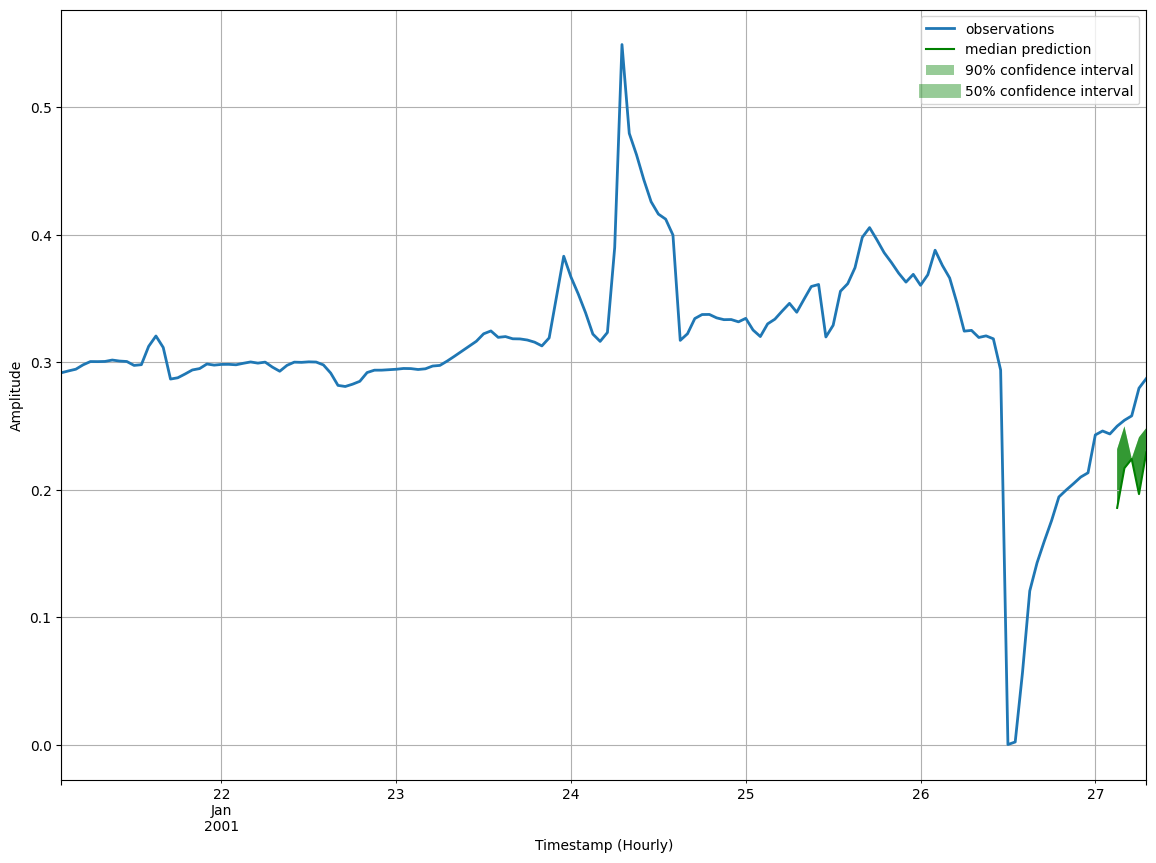

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Performance metrics {'MSE': 0.0018624547868967057, 'abs_error': 0.2764798402786255, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 1.6867656202387846, 'MAPE': 0.20687975748873644, 'sMAPE': 0.23353426485488332, 'OWA': nan, 'MSIS': 33.53580799031215, 'QuantileLoss[0.1]': 0.055295965075492864, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.2764798253774643, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.24094227254390715, 'Coverage[0.9]': 0.0, 'RMSE': 0.0431561674259509, 'NRMSE': 0.1624078426408947, 'ND': 0.2080930586359237, 'wQuantileLoss[0.1]': 0.04161860948410749, 'wQuantileLoss[0.5]': 0.2080930474205374, 'wQuantileLoss[0.9]': 0.18134564313197107, 'mean_wQuantileLoss': 0.143685766678872, 'MAE_Coverage': 0.5}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 5 (R1147)
----------*****-----------------------*****-----------

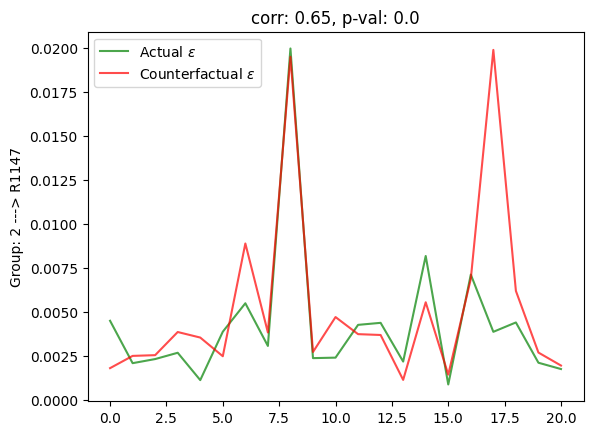

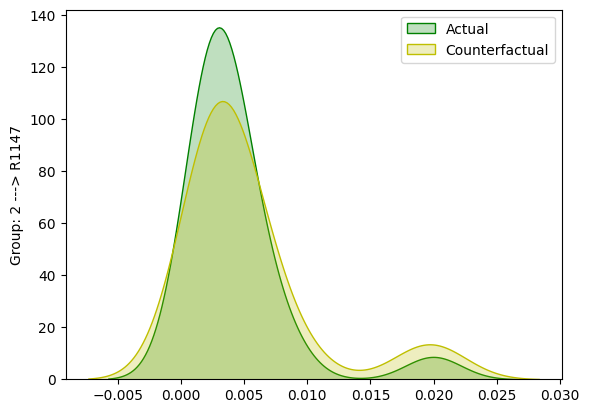

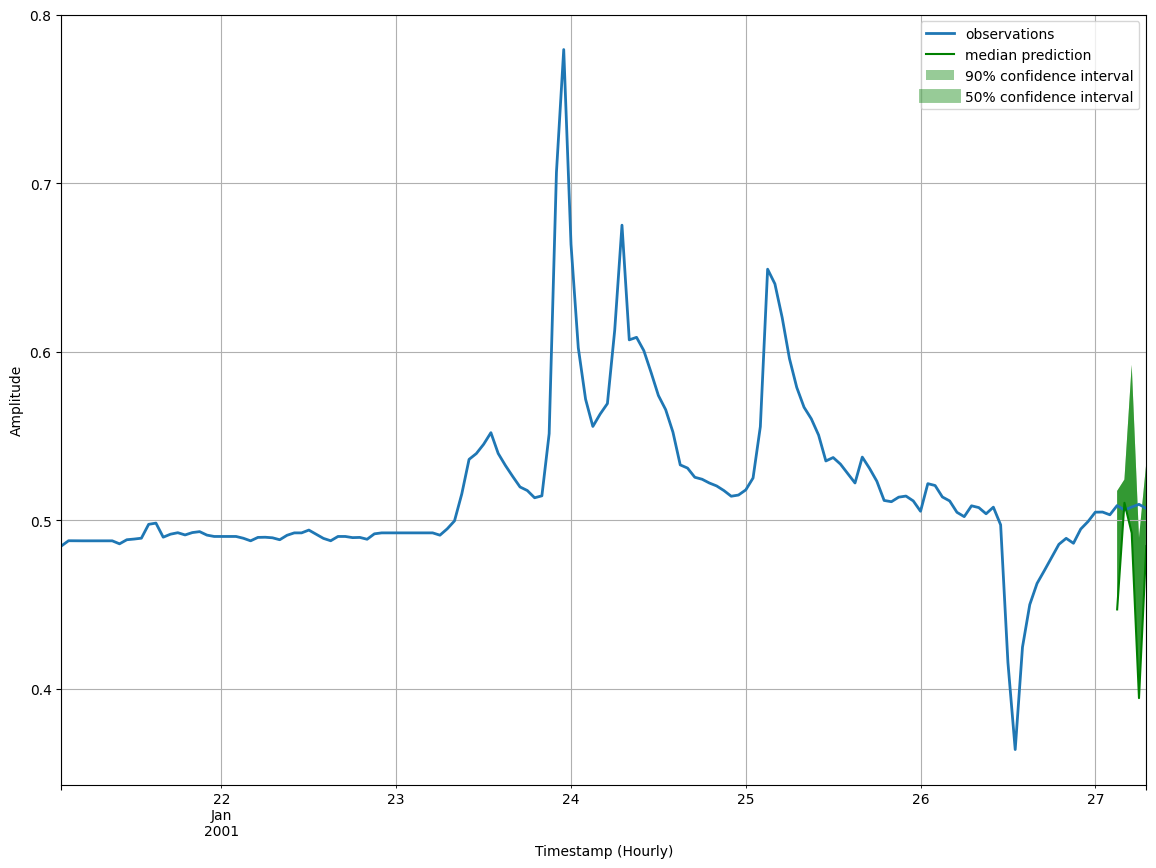

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Performance metrics {'MSE': 0.0013135914690792561, 'abs_error': 0.21869713068008423, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 2.613375639102892, 'MAPE': 0.08596912009842994, 'sMAPE': 0.09356138209621032, 'OWA': nan, 'MSIS': 15.485942048876469, 'QuantileLoss[0.1]': 0.05066615343093872, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.21869713068008423, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.06336103677749633, 'Coverage[0.9]': 0.8, 'RMSE': 0.03624350243946156, 'NRMSE': 0.07137736973608008, 'ND': 0.08613972108708873, 'wQuantileLoss[0.1]': 0.019956221243163062, 'wQuantileLoss[0.5]': 0.08613972108708873, 'wQuantileLoss[0.9]': 0.024956440986810494, 'mean_wQuantileLoss': 0.043684127772354094, 'MAE_Coverage': 0.16666666666666666}


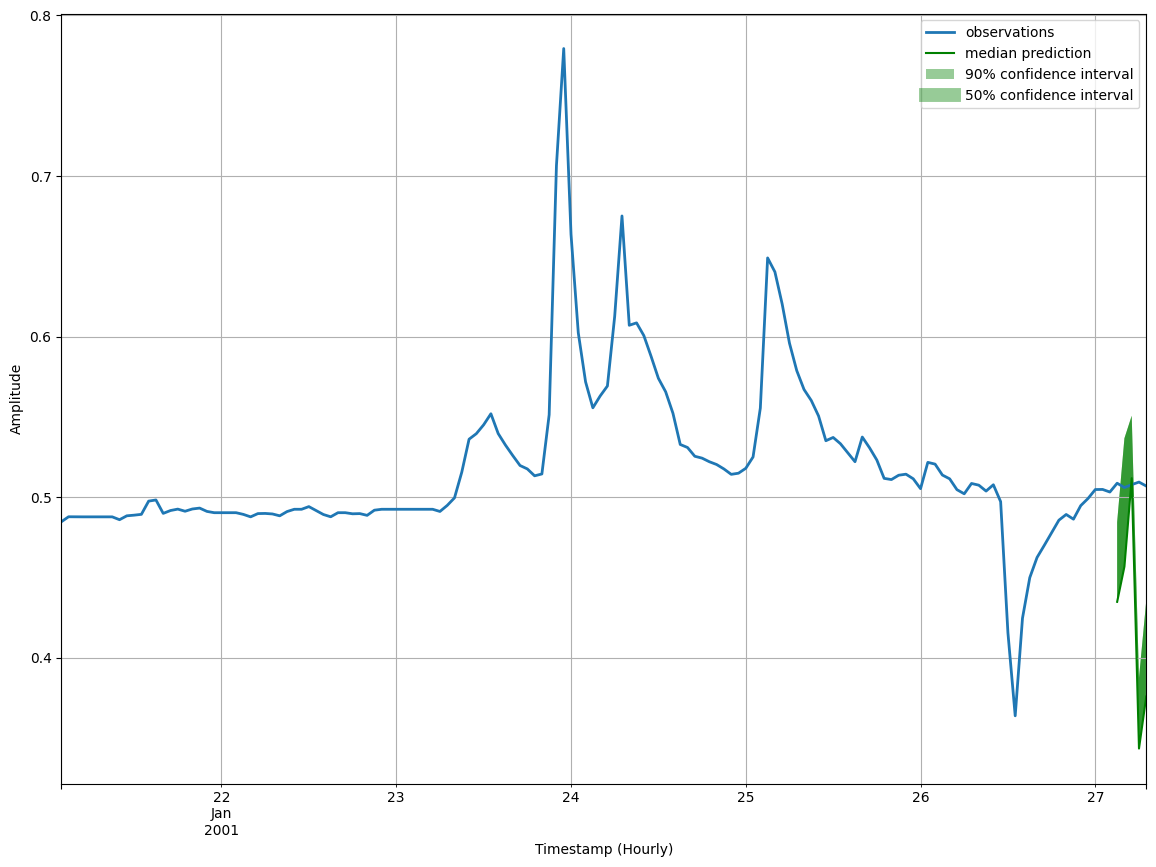

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Performance metrics {'MSE': 0.006796097755432129, 'abs_error': 0.4239499270915985, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 5.066094869261702, 'MAPE': 0.16687314998505415, 'sMAPE': 0.19047045320207942, 'OWA': nan, 'MSIS': 109.11078641928755, 'QuantileLoss[0.1]': 0.09121994376182557, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.4239499270915985, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.4061303436756134, 'Coverage[0.9]': 0.4, 'RMSE': 0.0824384482837476, 'NRMSE': 0.16235295177242773, 'ND': 0.16698403111645174, 'wQuantileLoss[0.1]': 0.03592941749527551, 'wQuantileLoss[0.5]': 0.16698403111645174, 'wQuantileLoss[0.9]': 0.15996531102365605, 'mean_wQuantileLoss': 0.12095958654512777, 'MAE_Coverage': 0.3}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 1 (R553)
----------*****-----------------------*****----------

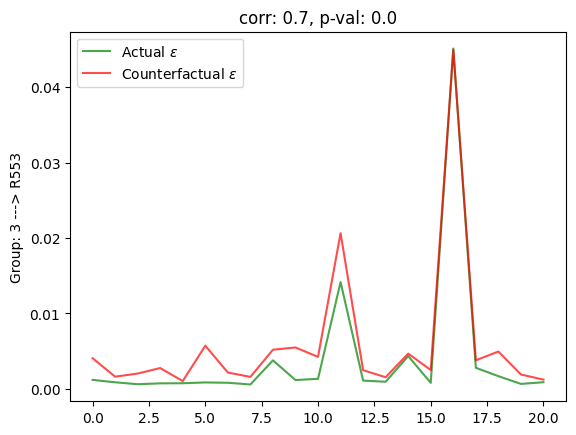

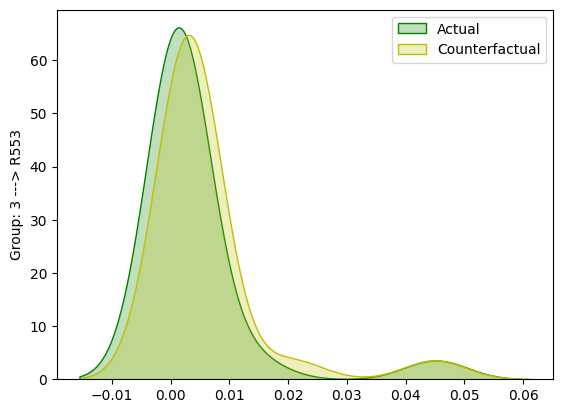

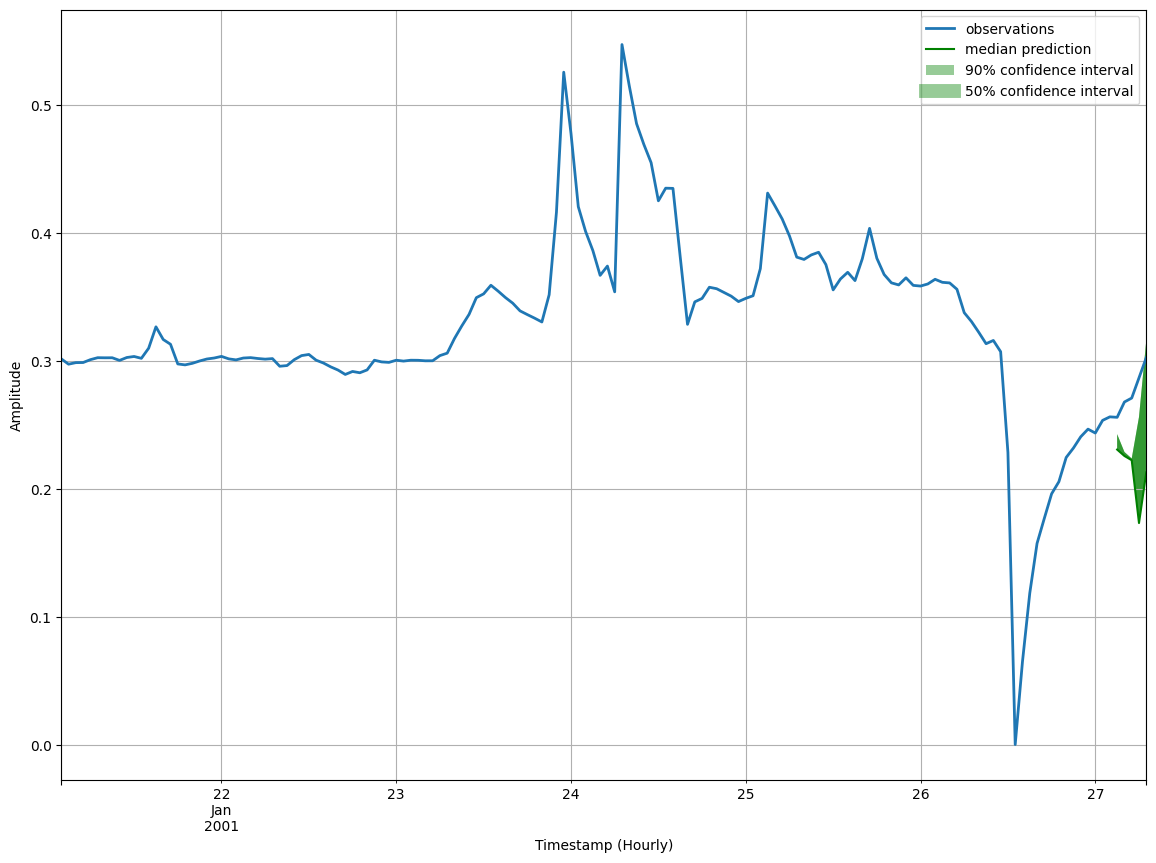

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Performance metrics {'MSE': 0.0021893613040447233, 'abs_error': 0.3189581632614136, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 1.9688051874574852, 'MAPE': 0.225573392914224, 'sMAPE': 0.2626745925360717, 'OWA': nan, 'MSIS': 33.346492857516616, 'QuantileLoss[0.1]': 0.06379163563251496, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.31895817816257477, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.23666830956935883, 'Coverage[0.9]': 0.2, 'RMSE': 0.046790611280947414, 'NRMSE': 0.16918458252754814, 'ND': 0.23065654505398106, 'wQuantileLoss[0.1]': 0.04613131116596937, 'wQuantileLoss[0.5]': 0.23065655582984684, 'wQuantileLoss[0.9]': 0.17114813444763258, 'mean_wQuantileLoss': 0.1493120004811496, 'MAE_Coverage': 0.4333333333333333}


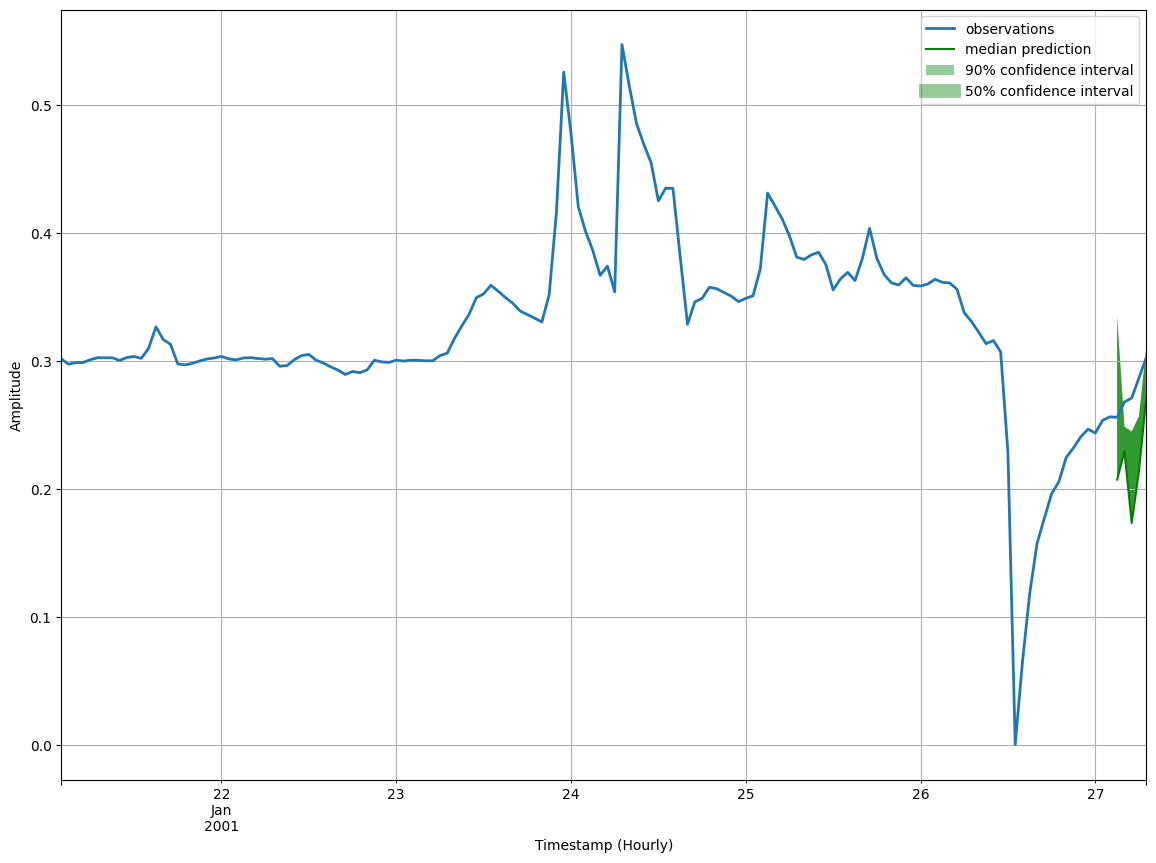

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Performance metrics {'MSE': 0.001531432382762432, 'abs_error': 0.2891363799571991, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 1.7847268711409658, 'MAPE': 0.21066101168053075, 'sMAPE': 0.2412638704342971, 'OWA': nan, 'MSIS': 20.491581255559627, 'QuantileLoss[0.1]': 0.057827278971672065, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.2891363948583603, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.15316713452339173, 'Coverage[0.9]': 0.4, 'RMSE': 0.03913351993831416, 'NRMSE': 0.14149822052641295, 'ND': 0.20909074020370352, 'wQuantileLoss[0.1]': 0.04181815019591387, 'wQuantileLoss[0.5]': 0.2090907509795693, 'wQuantileLoss[0.9]': 0.1107637494012929, 'mean_wQuantileLoss': 0.12055755019225868, 'MAE_Coverage': 0.3666666666666667}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 2 (R1144)
----------*****--------------------

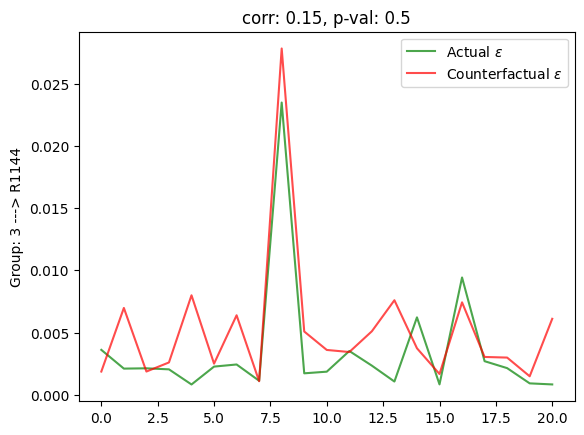

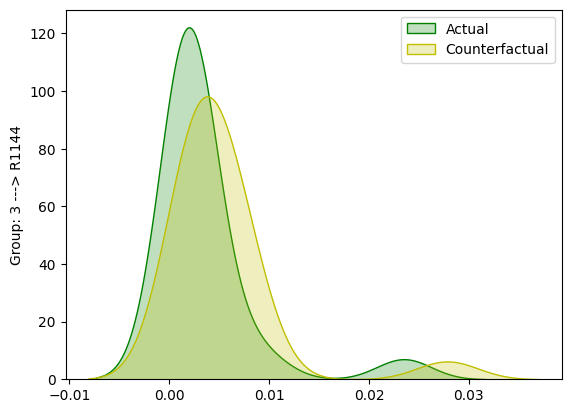

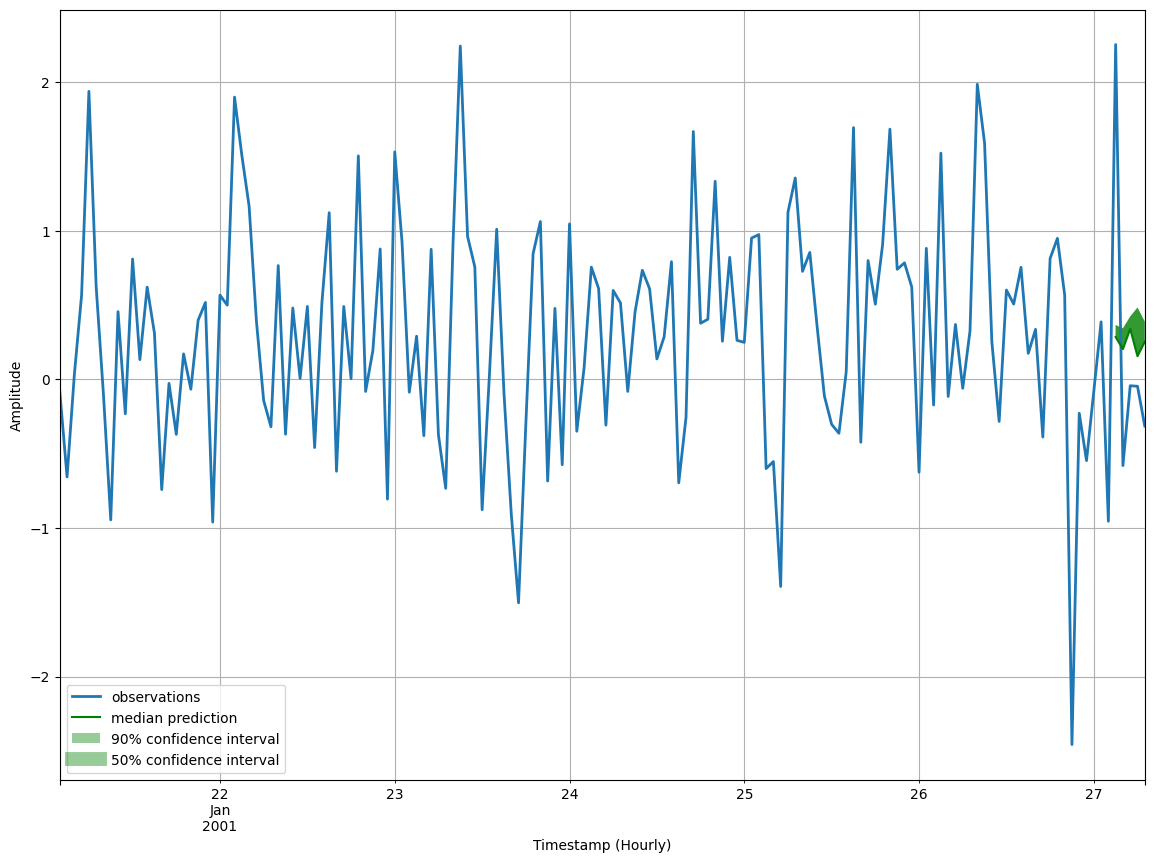

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Performance metrics {'MSE': 1.0337181091308594, 'abs_error': 3.906825065612793, 'abs_target_sum': 3.2365522384643555, 'abs_target_mean': 0.647310447692871, 'seasonal_error': 0.845847954184322, 'MASE': 0.9237653283397175, 'MAPE': 3.516594507070625, 'sMAPE': 1.9099648199815, 'OWA': nan, 'MSIS': 36.36882946612462, 'QuantileLoss[0.1]': 3.8812907278537745, 'Coverage[0.1]': 0.8, 'QuantileLoss[0.5]': 3.9068253338336945, 'Coverage[0.5]': 0.8, 'QuantileLoss[0.9]': 3.924241375923157, 'Coverage[0.9]': 0.8, 'RMSE': 1.0167192872818236, 'NRMSE': 1.5706826467973614, 'ND': 1.2070947037970448, 'wQuantileLoss[0.1]': 1.1992053400921863, 'wQuantileLoss[0.5]': 1.2070947866694601, 'wQuantileLoss[0.9]': 1.2124758344036766, 'mean_wQuantileLoss': 1.2062586537217743, 'MAE_Coverage': 0.3666666666666667}


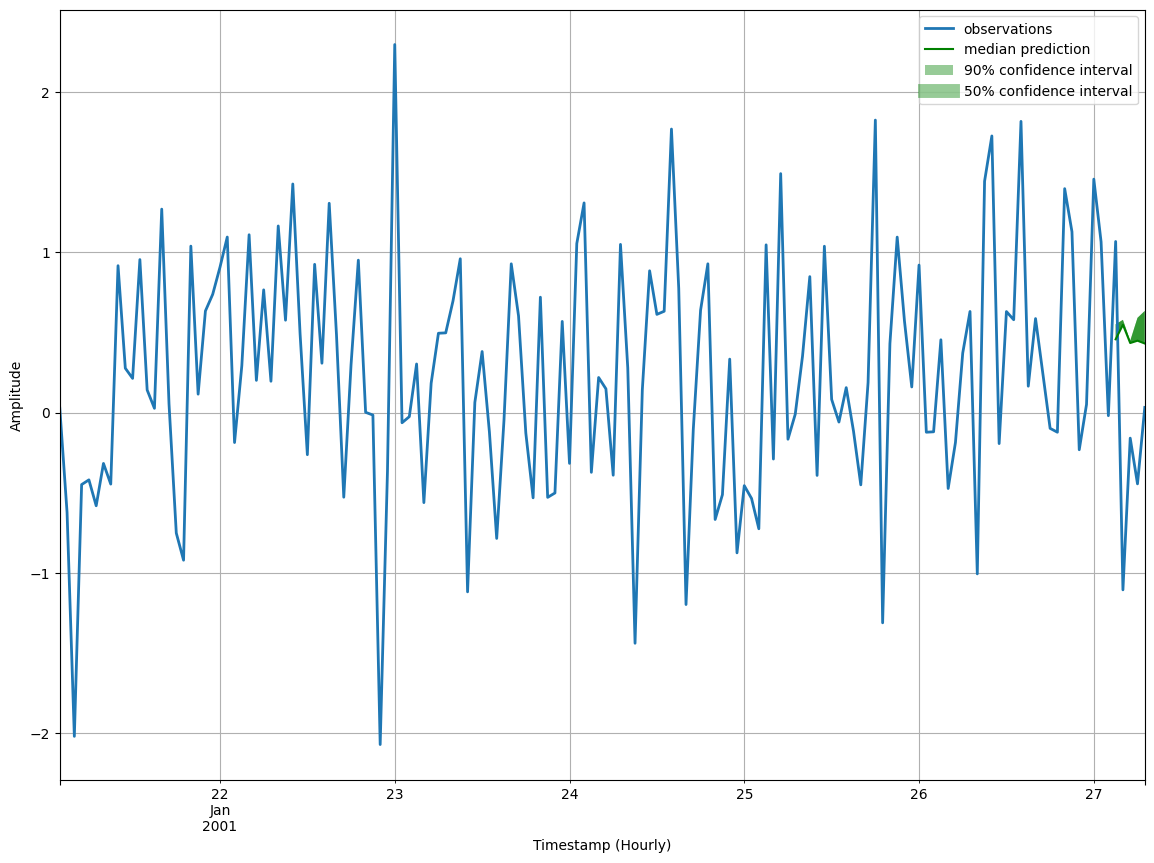

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Performance metrics {'MSE': 0.9299335479736328, 'abs_error': 4.151669025421143, 'abs_target_sum': 2.8116371631622314, 'abs_target_mean': 0.5623274326324463, 'seasonal_error': 0.8361693416387124, 'MASE': 0.9930211067736022, 'MAPE': 4.050175507316901, 'sMAPE': 1.7048215918410203, 'OWA': nan, 'MSIS': 38.93668948902021, 'QuantileLoss[0.1]': 6.4961557567119605, 'Coverage[0.1]': 0.8, 'QuantileLoss[0.5]': 4.151668876409531, 'Coverage[0.5]': 0.8, 'QuantileLoss[0.9]': 1.7160011887550353, 'Coverage[0.9]': 0.8, 'RMSE': 0.9643306217131306, 'NRMSE': 1.7148916552030378, 'ND': 1.4766019882707004, 'wQuantileLoss[0.1]': 2.31045308470947, 'wQuantileLoss[0.5]': 1.4766019352725348, 'wQuantileLoss[0.9]': 0.6103209942014919, 'mean_wQuantileLoss': 1.465792004727832, 'MAE_Coverage': 0.3666666666666667}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------

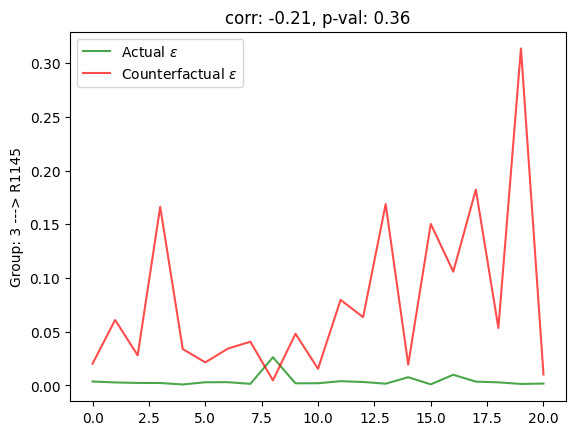

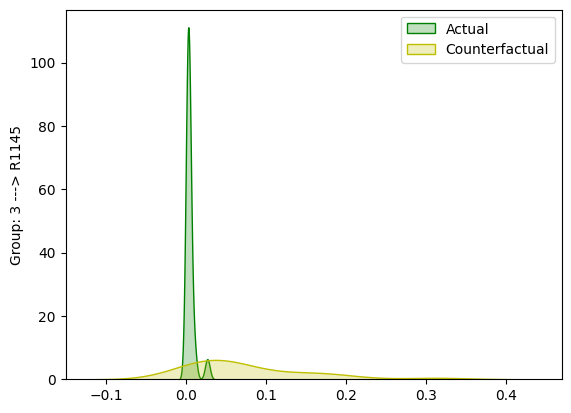

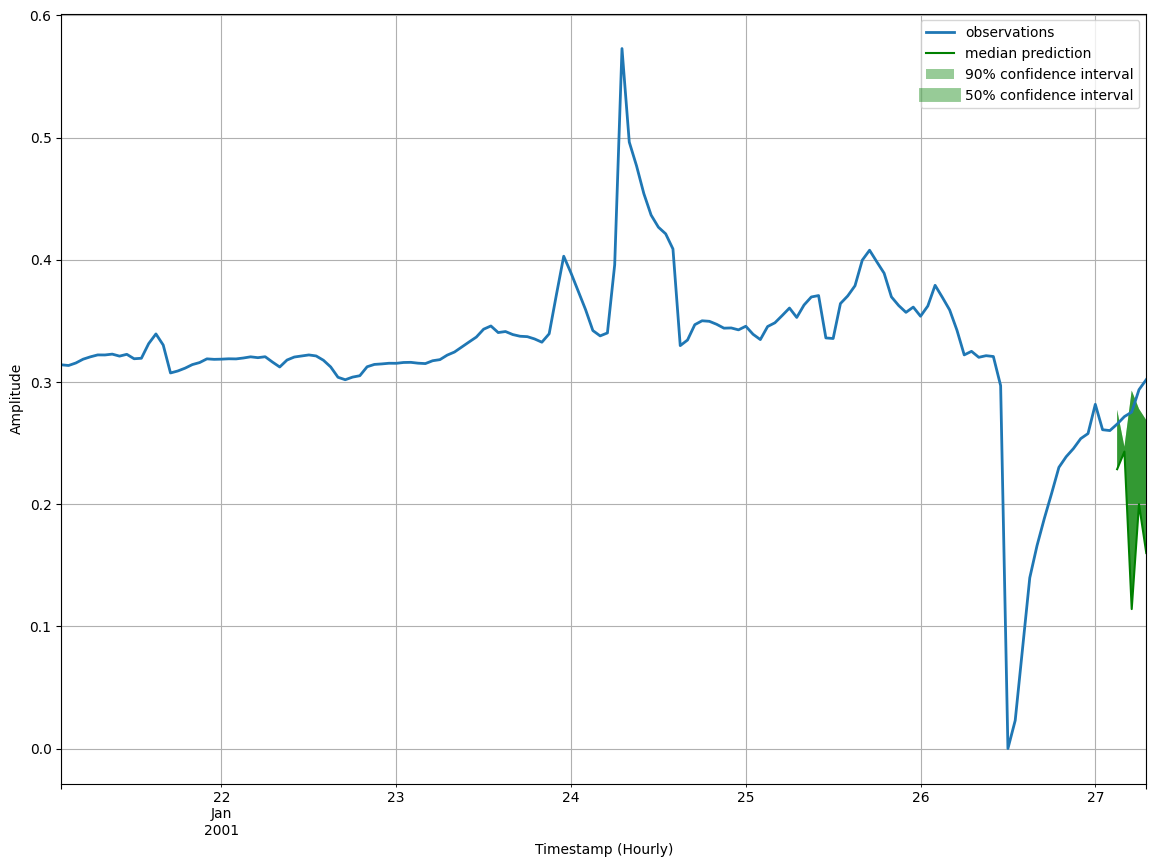

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Performance metrics {'MSE': 0.0033367130905389785, 'abs_error': 0.46236640214920044, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 3.122446416460054, 'MAPE': 0.3237851257681906, 'sMAPE': 0.4164878233205179, 'OWA': nan, 'MSIS': 22.69527602861694, 'QuantileLoss[0.1]': 0.09247328042984009, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.46236640214920044, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.13826683163642883, 'Coverage[0.9]': 0.4, 'RMSE': 0.057764289059409175, 'NRMSE': 0.20509952184192312, 'ND': 0.32833825029522934, 'wQuantileLoss[0.1]': 0.06566765005904587, 'wQuantileLoss[0.5]': 0.32833825029522934, 'wQuantileLoss[0.9]': 0.09818682621044032, 'mean_wQuantileLoss': 0.1640642421882385, 'MAE_Coverage': 0.3666666666666667}


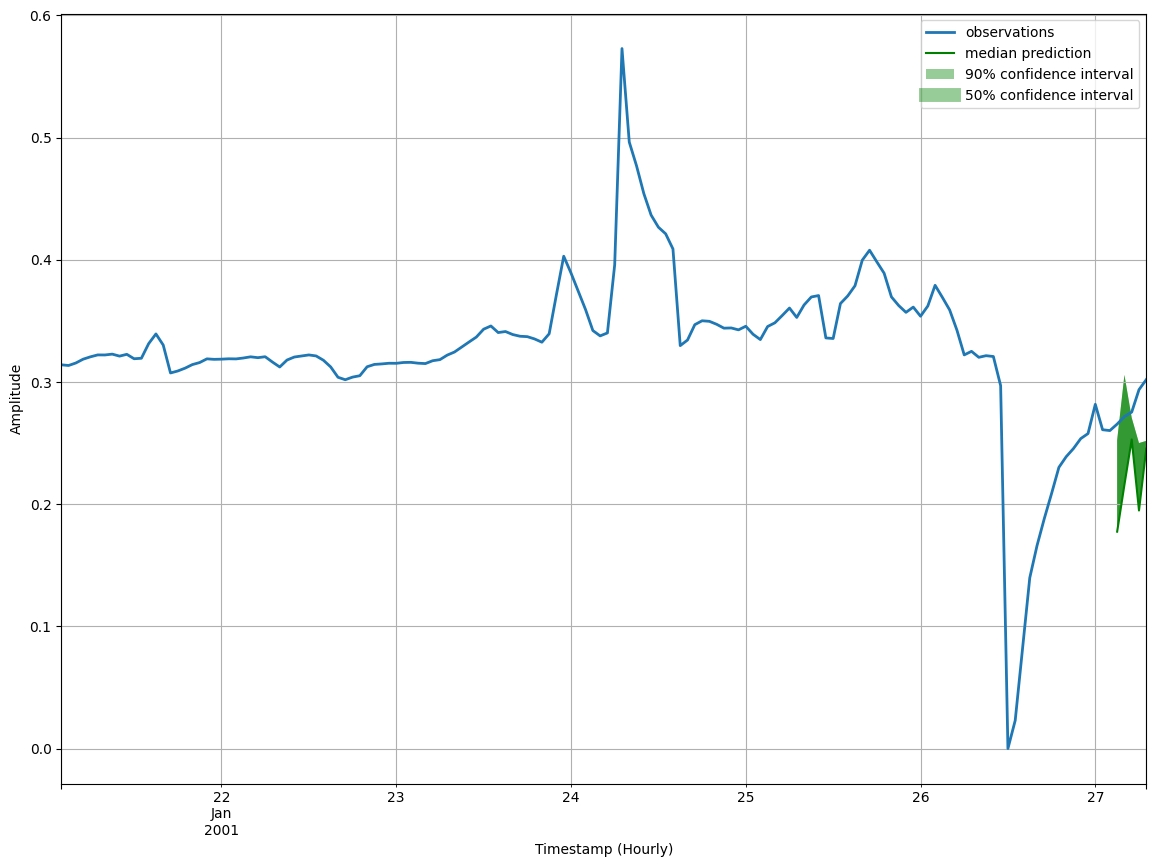

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Performance metrics {'MSE': 0.0021574804559350014, 'abs_error': 0.32156631350517273, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 2.171597197787943, 'MAPE': 0.22838218034553542, 'sMAPE': 0.26444114207482566, 'OWA': nan, 'MSIS': 31.821627808734263, 'QuantileLoss[0.1]': 0.06431325972080232, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.32156629860401154, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.20788132548332217, 'Coverage[0.9]': 0.2, 'RMSE': 0.046448686267051745, 'NRMSE': 0.1649220218699469, 'ND': 0.22835249325945897, 'wQuantileLoss[0.1]': 0.04567049653555239, 'wQuantileLoss[0.5]': 0.22835248267776193, 'wQuantileLoss[0.9]': 0.14762186517224887, 'mean_wQuantileLoss': 0.14054828146185439, 'MAE_Coverage': 0.4333333333333333}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 4 (R1146)
----------*****---------------

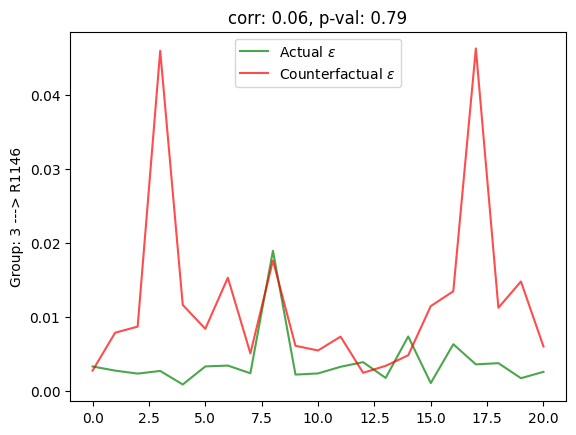

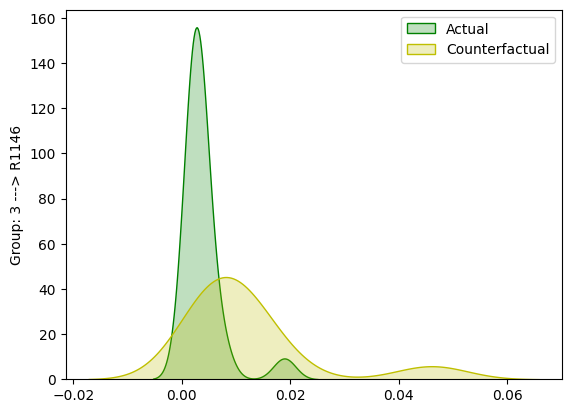

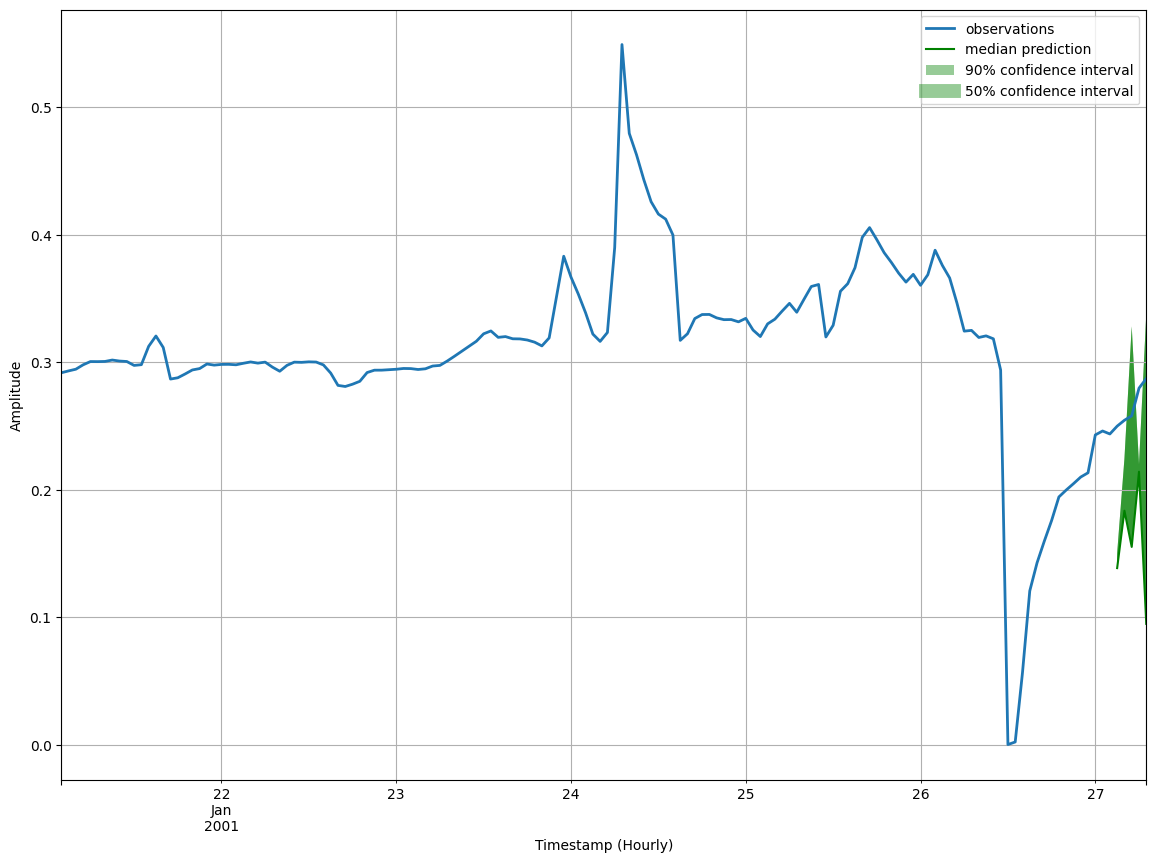

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Performance metrics {'MSE': 0.004579604789614678, 'abs_error': 0.5431041717529297, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 3.3134041317367044, 'MAPE': 0.4056541653988671, 'sMAPE': 0.5339383776196819, 'OWA': nan, 'MSIS': 49.13076426971766, 'QuantileLoss[0.1]': 0.10862084031105042, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.5431042015552521, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.36521096825599675, 'Coverage[0.9]': 0.4, 'RMSE': 0.06767277731565831, 'NRMSE': 0.25467019953085135, 'ND': 0.40876835050289345, 'wQuantileLoss[0.1]': 0.0817536745867332, 'wQuantileLoss[0.5]': 0.408768372933666, 'wQuantileLoss[0.9]': 0.27487670477236226, 'mean_wQuantileLoss': 0.2551329174309205, 'MAE_Coverage': 0.3666666666666667}


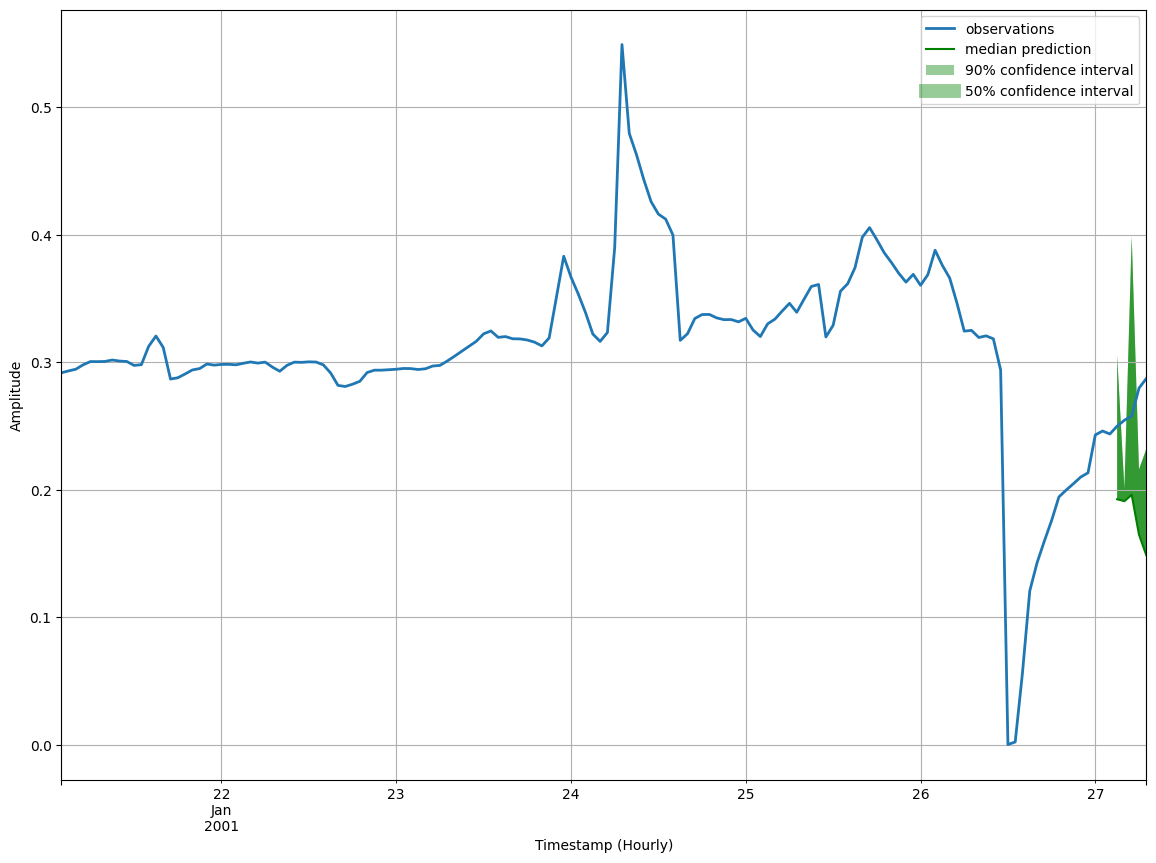

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Performance metrics {'MSE': 0.004471591114997864, 'abs_error': 0.43620041012763977, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 2.6611989308004613, 'MAPE': 0.3225851732022227, 'sMAPE': 0.3941659264367775, 'OWA': nan, 'MSIS': 44.96769981450674, 'QuantileLoss[0.1]': 0.08724008202552795, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.43620041012763977, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.35019262731075285, 'Coverage[0.9]': 0.4, 'RMSE': 0.06686995674439954, 'NRMSE': 0.2516489776573013, 'ND': 0.3283070383367923, 'wQuantileLoss[0.1]': 0.06566140766735847, 'wQuantileLoss[0.5]': 0.3283070383367923, 'wQuantileLoss[0.9]': 0.2635731229279013, 'mean_wQuantileLoss': 0.2191805229773507, 'MAE_Coverage': 0.3666666666666667}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 5 (R1147)
----------*****-----------------------**

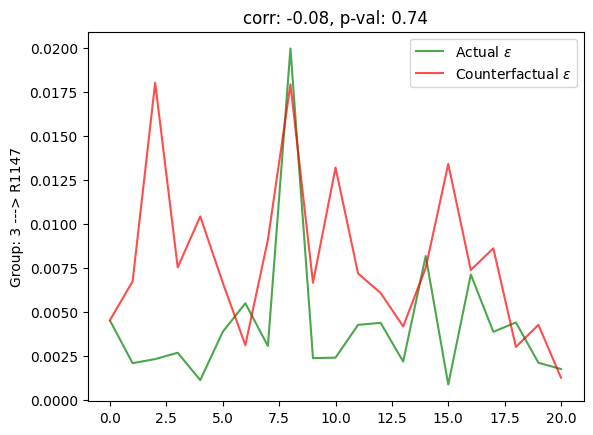

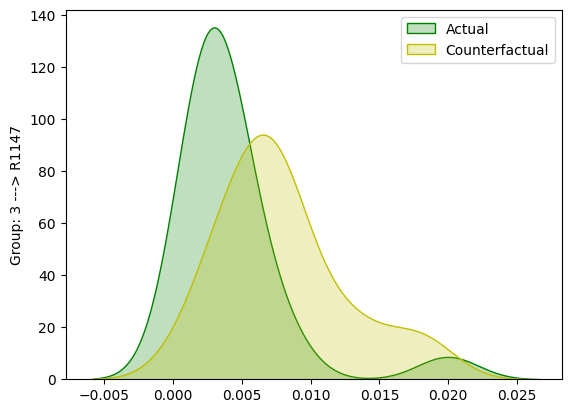

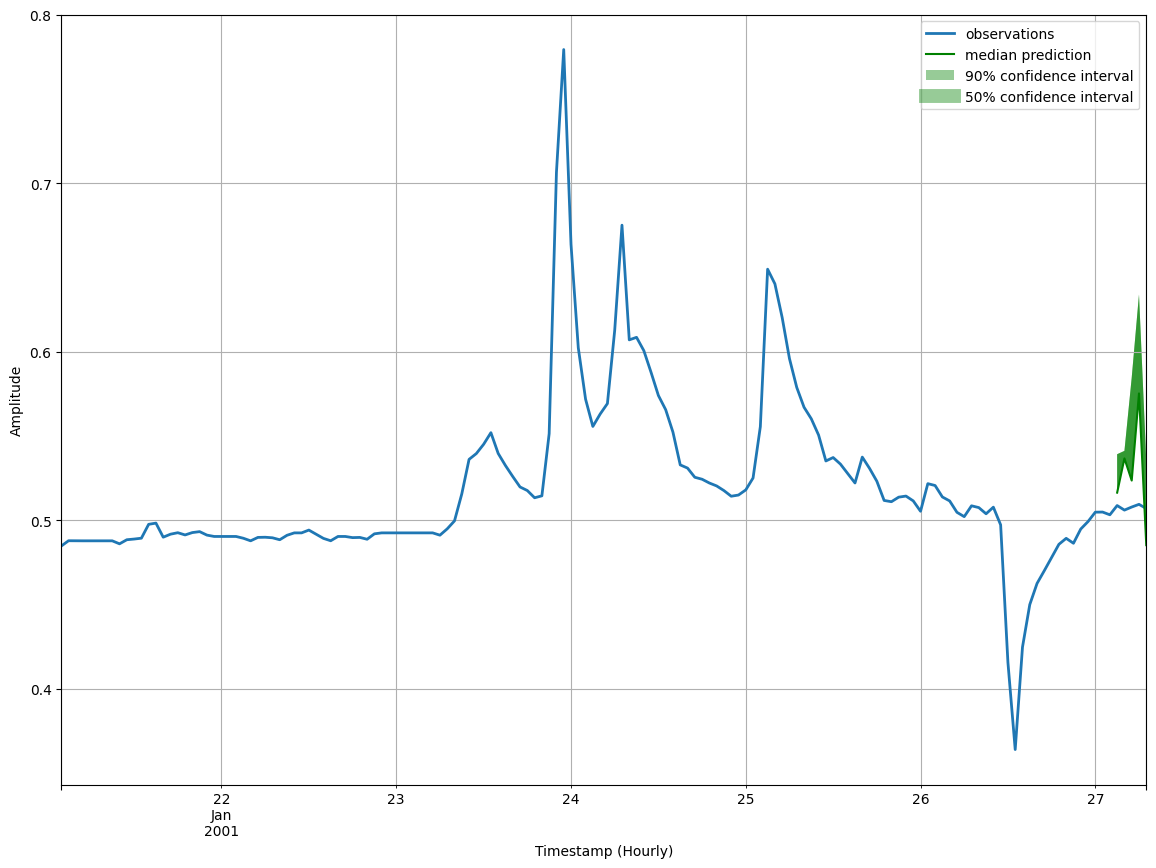

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Performance metrics {'MSE': 0.002530444413423538, 'abs_error': 0.1415996551513672, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 1.6920802212959825, 'MAPE': 0.055739790169476465, 'sMAPE': 0.05388612990070374, 'OWA': nan, 'MSIS': 59.64900163345074, 'QuantileLoss[0.1]': 0.22010316848754882, 'Coverage[0.1]': 0.8, 'QuantileLoss[0.5]': 0.1415996551513672, 'Coverage[0.5]': 0.8, 'QuantileLoss[0.9]': 0.05904040336608885, 'Coverage[0.9]': 1.0, 'RMSE': 0.0503035228728917, 'NRMSE': 0.09906694743762998, 'ND': 0.055772815870224285, 'wQuantileLoss[0.1]': 0.08669352672777668, 'wQuantileLoss[0.5]': 0.055772815870224285, 'wQuantileLoss[0.9]': 0.02325464382184161, 'mean_wQuantileLoss': 0.05524032880661419, 'MAE_Coverage': 0.3666666666666667}


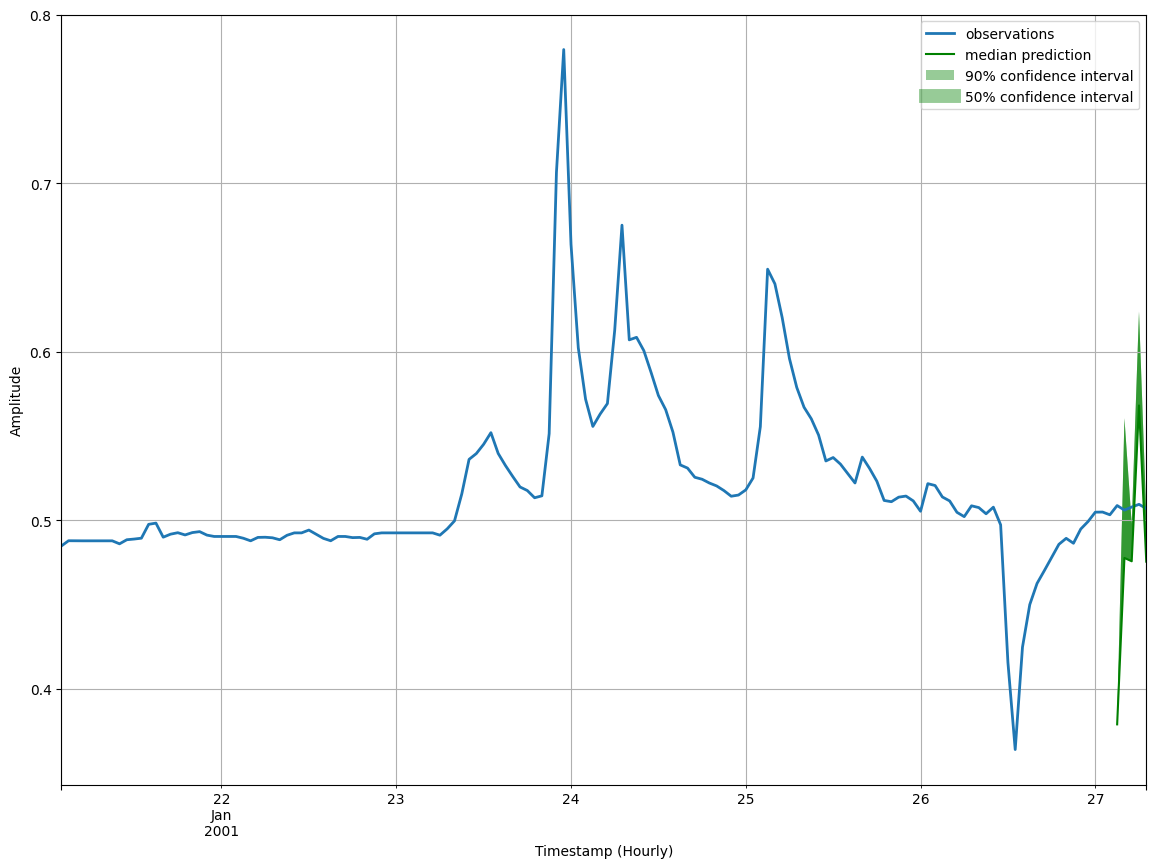

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Performance metrics {'MSE': 0.005014081671833992, 'abs_error': 0.28064924478530884, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 3.353687801818708, 'MAPE': 0.11043183006448923, 'sMAPE': 0.11778552829378923, 'OWA': nan, 'MSIS': 98.15084100929272, 'QuantileLoss[0.1]': 0.1500259518623352, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.28064924478530884, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.2892250597476959, 'Coverage[0.9]': 0.4, 'RMSE': 0.070810180566314, 'NRMSE': 0.13945242868849717, 'ND': 0.11054122015195743, 'wQuantileLoss[0.1]': 0.05909173846524275, 'wQuantileLoss[0.5]': 0.11054122015195743, 'wQuantileLoss[0.9]': 0.11391903451402659, 'mean_wQuantileLoss': 0.09451733104374226, 'MAE_Coverage': 0.3}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 1 (R553)
----------*****-----------------------*****-----------

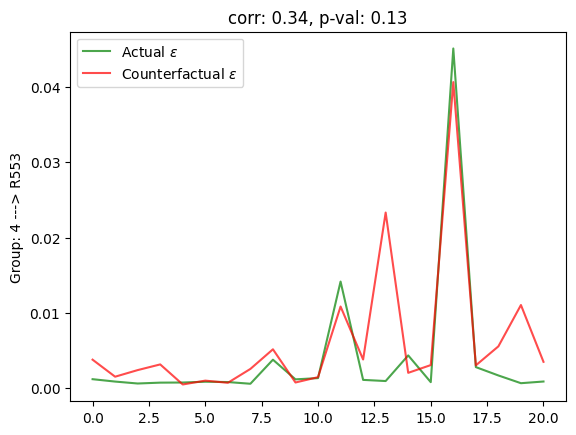

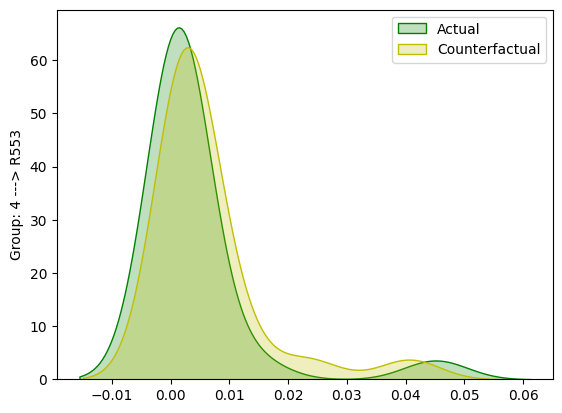

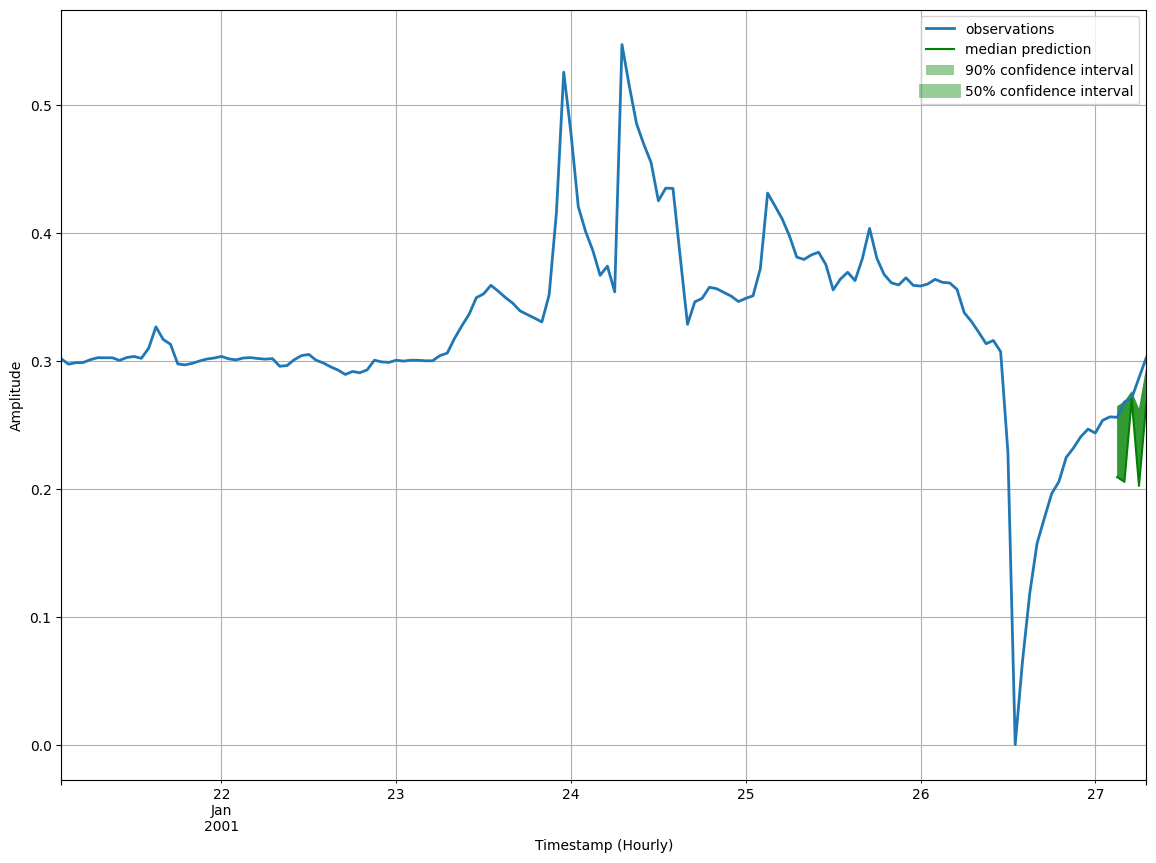

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Performance metrics {'MSE': 0.0009430890902876854, 'abs_error': 0.22987903654575348, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 1.4189542446921932, 'MAPE': 0.16622408646677322, 'sMAPE': 0.18766703596752318, 'OWA': nan, 'MSIS': 9.019153726911203, 'QuantileLoss[0.1]': 0.0459758073091507, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.22987903654575348, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.059039294719696045, 'Coverage[0.9]': 0.6, 'RMSE': 0.03070975562077441, 'NRMSE': 0.11103973728890645, 'ND': 0.16623843016842418, 'wQuantileLoss[0.1]': 0.03324768603368484, 'wQuantileLoss[0.5]': 0.16623843016842418, 'wQuantileLoss[0.9]': 0.04269462679125062, 'mean_wQuantileLoss': 0.08072691433111988, 'MAE_Coverage': 0.3}


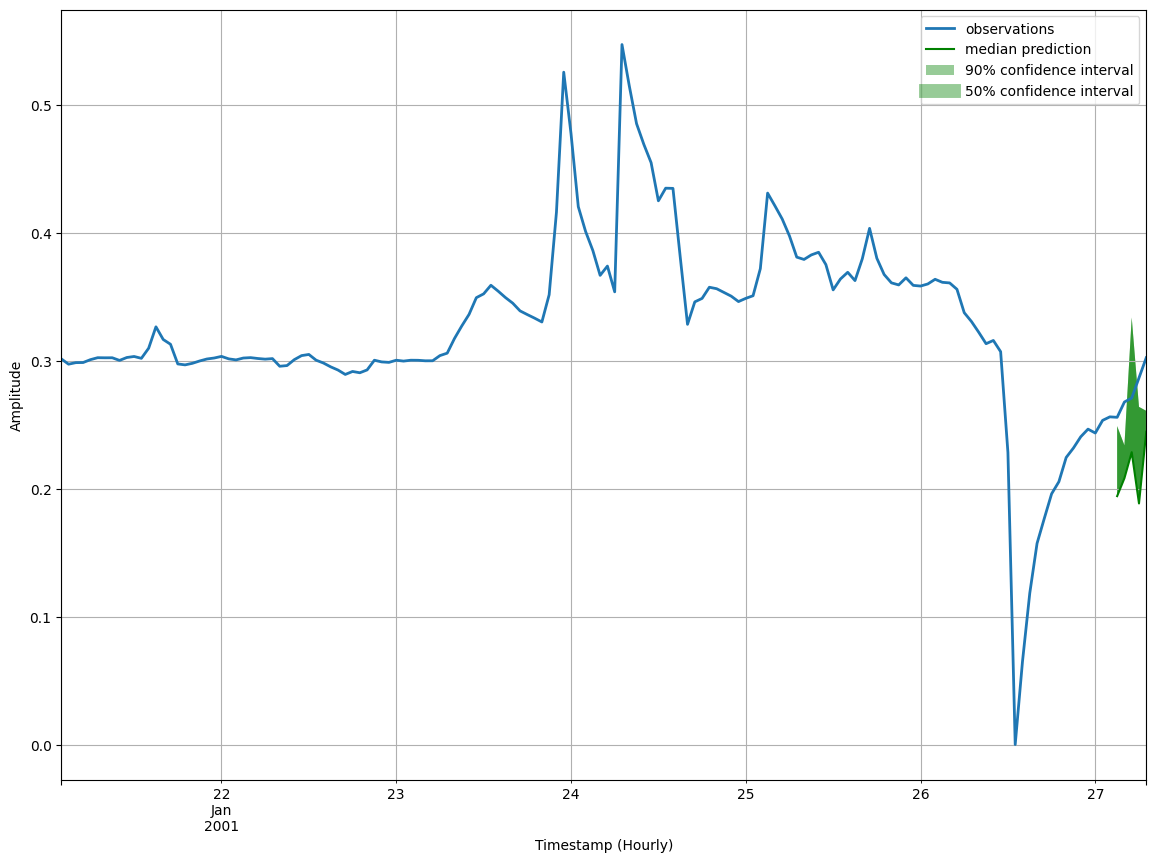

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Performance metrics {'MSE': 0.0019136684015393258, 'abs_error': 0.31930530071258545, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 1.9709479324734447, 'MAPE': 0.23063027127841673, 'sMAPE': 0.2636242834785255, 'OWA': nan, 'MSIS': 27.613864070430644, 'QuantileLoss[0.1]': 0.06386105418205262, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.31930527091026306, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.2014181762933731, 'Coverage[0.9]': 0.2, 'RMSE': 0.04374549578573005, 'NRMSE': 0.1581741131256172, 'ND': 0.23090757962330333, 'wQuantileLoss[0.1]': 0.04618151161431436, 'wQuantileLoss[0.5]': 0.23090755807157176, 'wQuantileLoss[0.9]': 0.14565678514027075, 'mean_wQuantileLoss': 0.14091528494205227, 'MAE_Coverage': 0.4333333333333333}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 2 (R1144)
----------*****------------------

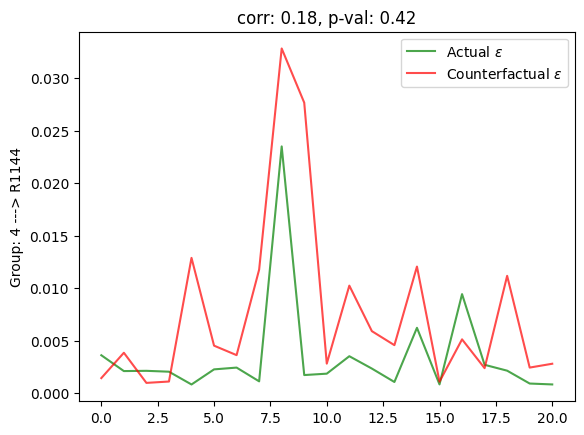

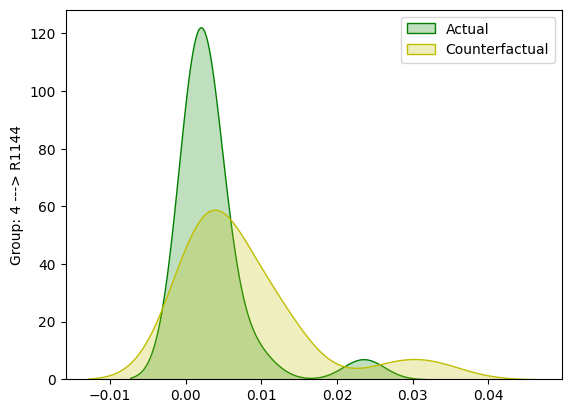

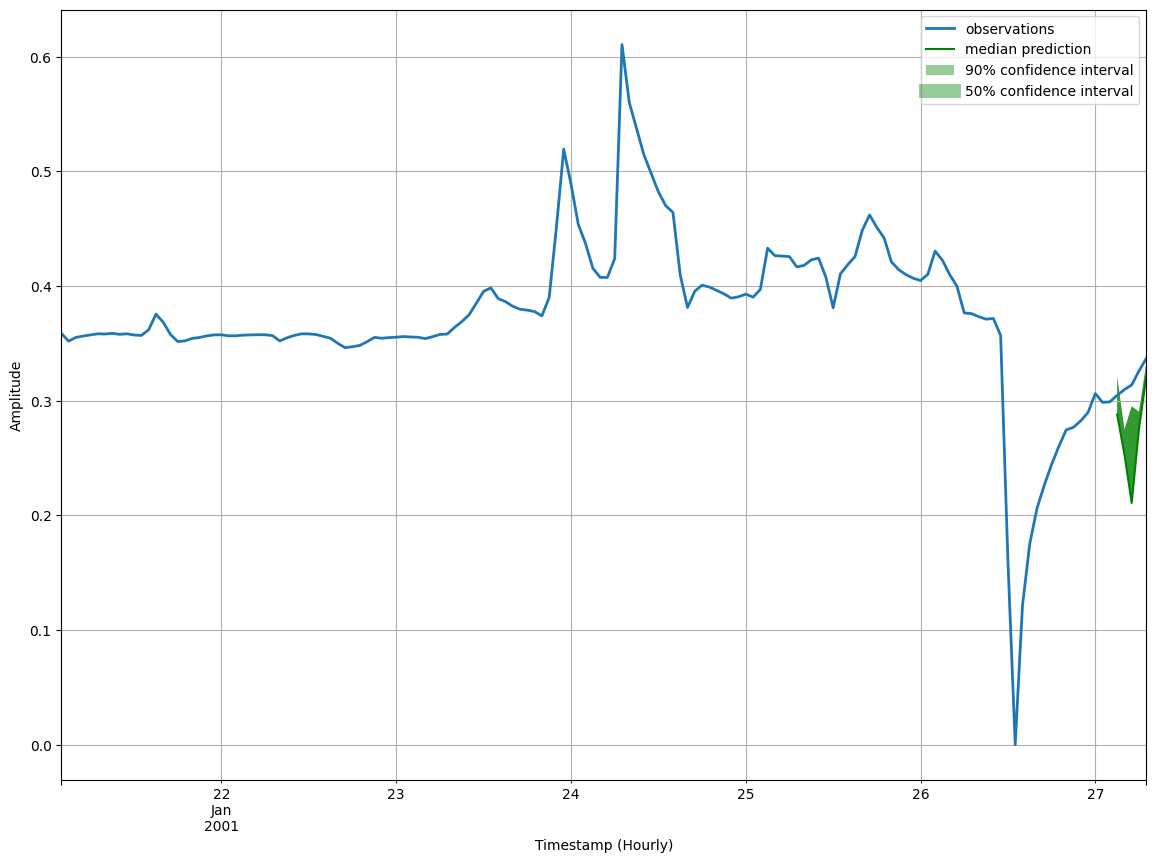

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Performance metrics {'MSE': 0.001547059789299965, 'abs_error': 0.2426149547100067, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 1.6231421431838375, 'MAPE': 0.15354543541419247, 'sMAPE': 0.17320663714252768, 'OWA': nan, 'MSIS': 26.16972153845257, 'QuantileLoss[0.1]': 0.04852299094200135, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.2426149547100067, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.17184634804725646, 'Coverage[0.9]': 0.2, 'RMSE': 0.039332680932018416, 'NRMSE': 0.12362076476866393, 'ND': 0.15250547653948945, 'wQuantileLoss[0.1]': 0.030501095307897894, 'wQuantileLoss[0.5]': 0.15250547653948945, 'wQuantileLoss[0.9]': 0.10802099661104227, 'mean_wQuantileLoss': 0.09700918948614319, 'MAE_Coverage': 0.4333333333333333}


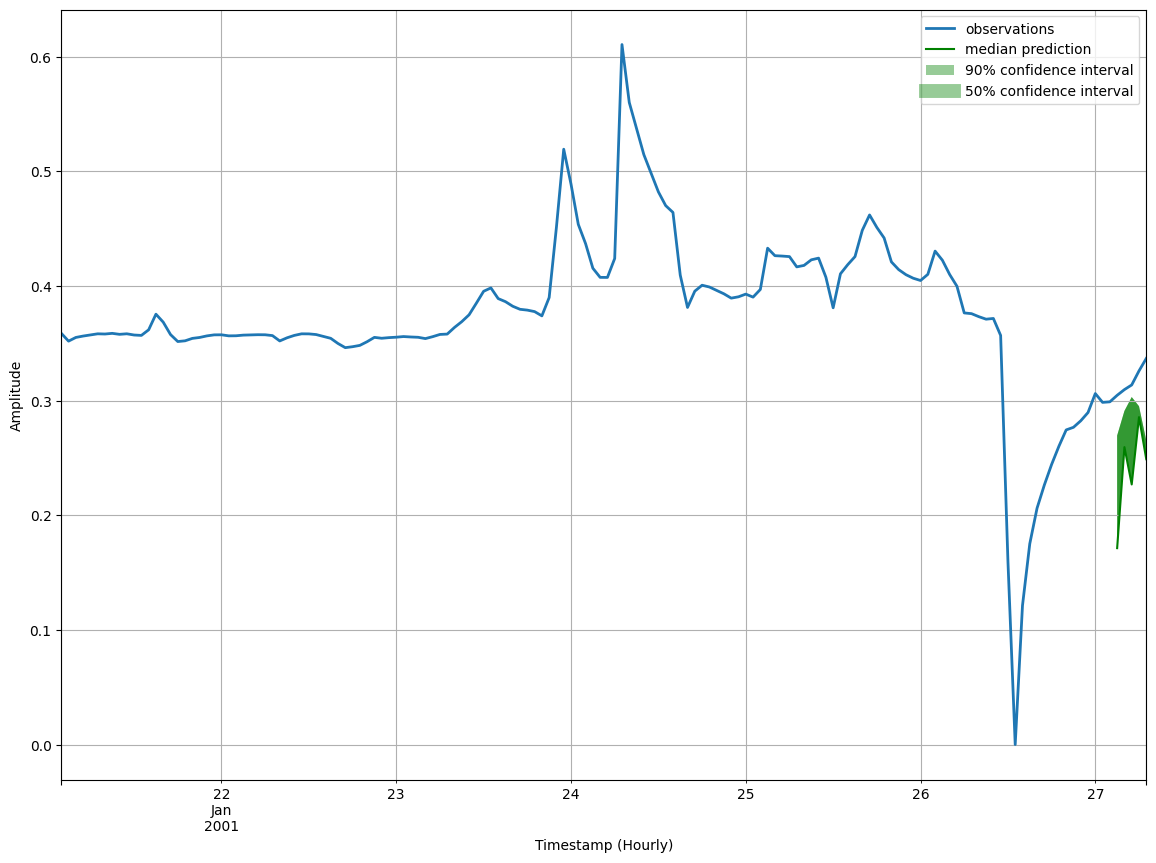

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Performance metrics {'MSE': 0.003656362369656563, 'abs_error': 0.3985708951950073, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 2.666518301853228, 'MAPE': 0.25222155517092804, 'sMAPE': 0.29794720138339664, 'OWA': nan, 'MSIS': 46.191280693860996, 'QuantileLoss[0.1]': 0.07971417903900146, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.3985708951950073, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.3002654135227204, 'Coverage[0.9]': 0.0, 'RMSE': 0.0604678622878018, 'NRMSE': 0.19004764493079052, 'ND': 0.2505379125501139, 'wQuantileLoss[0.1]': 0.05010758251002278, 'wQuantileLoss[0.5]': 0.2505379125501139, 'wQuantileLoss[0.9]': 0.1887440122244065, 'mean_wQuantileLoss': 0.16312983576151438, 'MAE_Coverage': 0.5}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 3 (R1145)
----------*****-----------------------*****----------

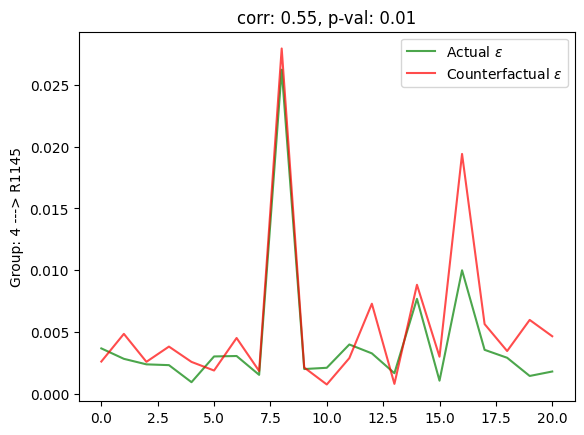

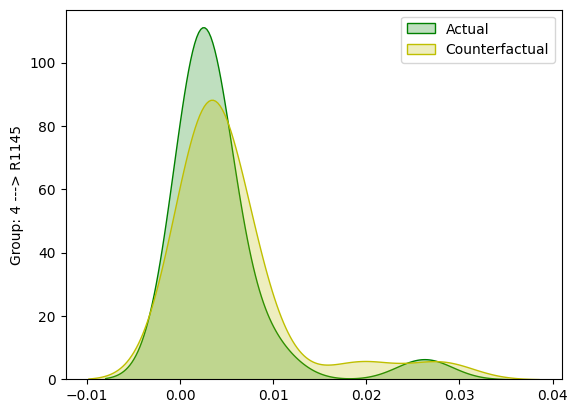

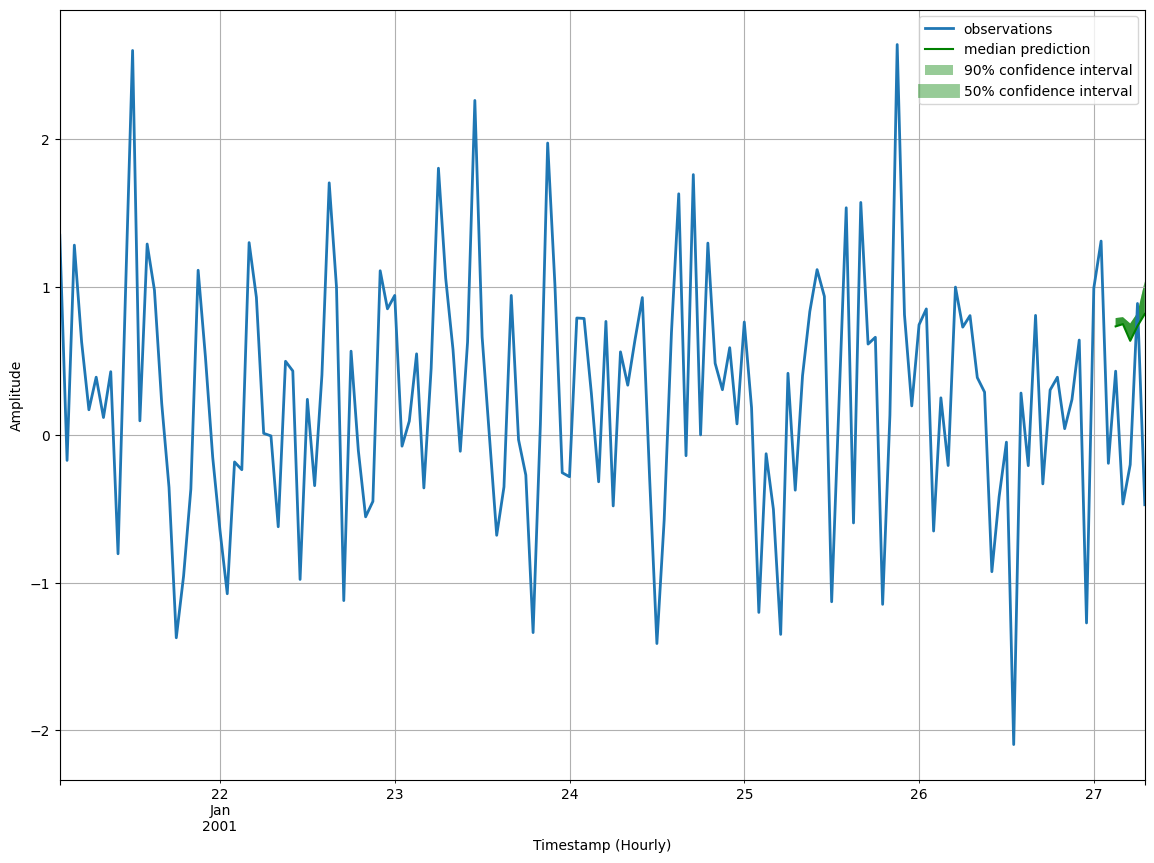

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Performance metrics {'MSE': 0.8852431297302246, 'abs_error': 3.801224708557129, 'abs_target_sum': 2.462218761444092, 'abs_target_mean': 0.49244375228881837, 'seasonal_error': 0.939543930599694, 'MASE': 0.8091638048538881, 'MAPE': 2.0704036425610313, 'sMAPE': 1.3417374440693186, 'OWA': nan, 'MSIS': 31.716340549027628, 'QuantileLoss[0.1]': 6.5976593673229225, 'Coverage[0.1]': 0.8, 'QuantileLoss[0.5]': 3.801224797964096, 'Coverage[0.5]': 0.8, 'QuantileLoss[0.9]': 0.9316617548465728, 'Coverage[0.9]': 0.8, 'RMSE': 0.9408735992311744, 'NRMSE': 1.91062145647723, 'ND': 1.5438208692422235, 'wQuantileLoss[0.1]': 2.6795585634533117, 'wQuantileLoss[0.5]': 1.5438209055537684, 'wQuantileLoss[0.9]': 0.37838301349801795, 'mean_wQuantileLoss': 1.5339208275016993, 'MAE_Coverage': 0.3666666666666667}


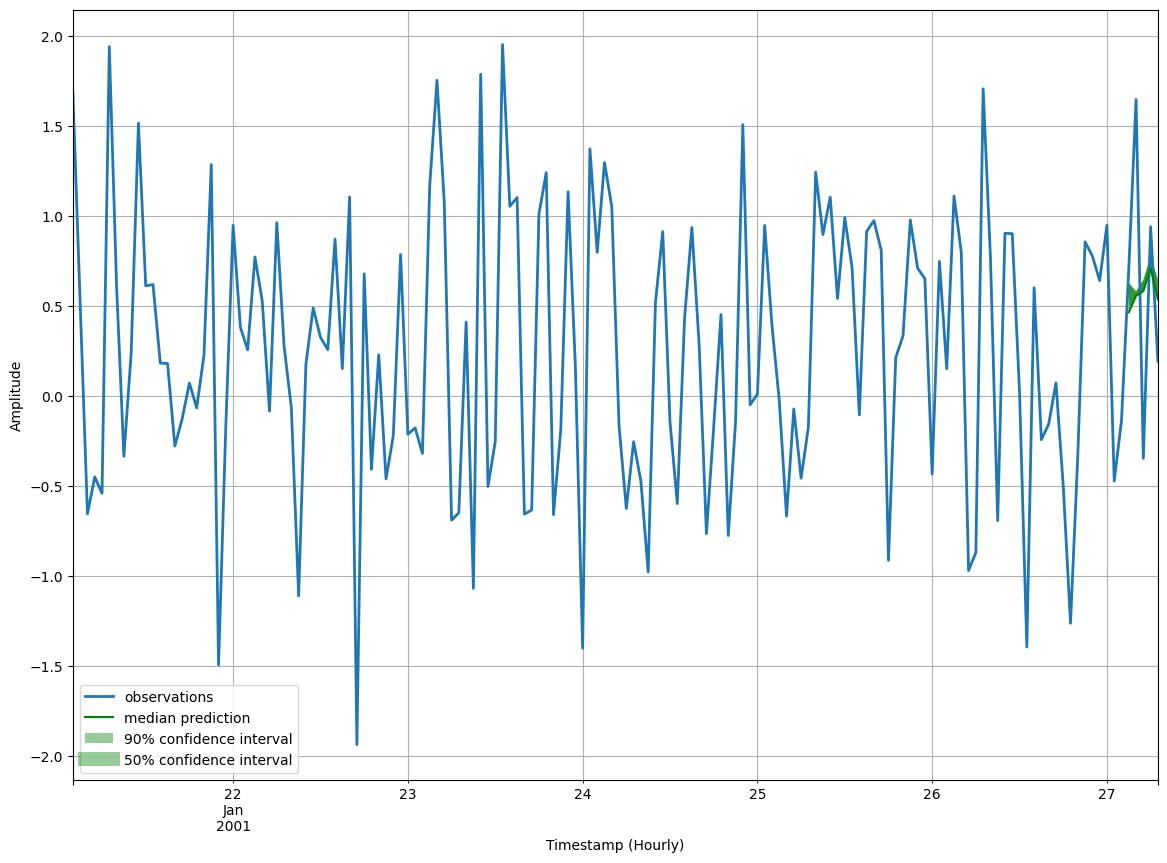

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Performance metrics {'MSE': 0.46151022911071776, 'abs_error': 2.8375909328460693, 'abs_target_sum': 3.8379194736480713, 'abs_target_mean': 0.7675838947296143, 'seasonal_error': 0.8017302259887006, 'MASE': 0.7078667713560949, 'MAPE': 1.1394536969450417, 'sMAPE': 0.9235604042636266, 'OWA': nan, 'MSIS': 25.825296699945632, 'QuantileLoss[0.1]': 2.60312374830246, 'Coverage[0.1]': 0.4, 'QuantileLoss[0.5]': 2.8375911116600037, 'Coverage[0.5]': 0.4, 'QuantileLoss[0.9]': 2.6378801941871646, 'Coverage[0.9]': 0.4, 'RMSE': 0.6793454416647821, 'NRMSE': 0.885043897259055, 'ND': 0.7393565582419175, 'wQuantileLoss[0.1]': 0.6782642955841133, 'wQuantileLoss[0.5]': 0.7393566048332896, 'wQuantileLoss[0.9]': 0.687320359976123, 'mean_wQuantileLoss': 0.7016470867978418, 'MAE_Coverage': 0.3}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test stati

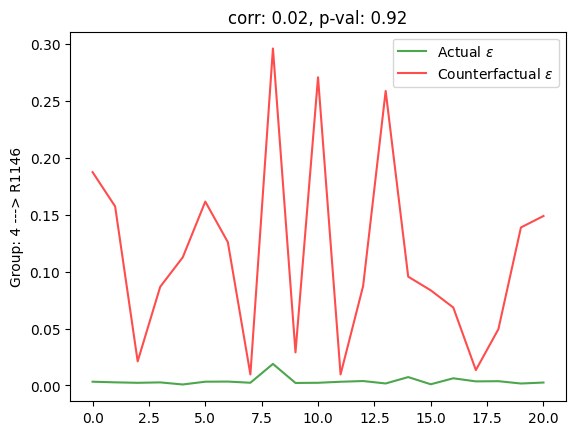

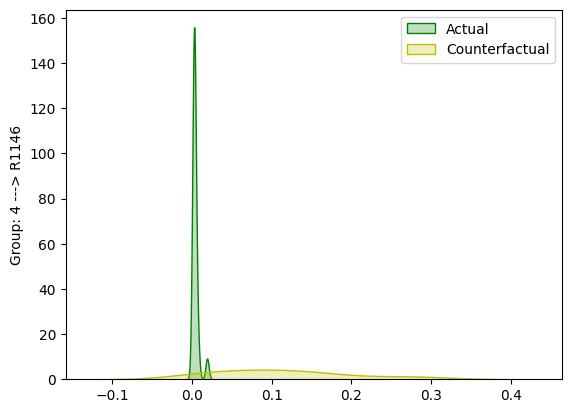

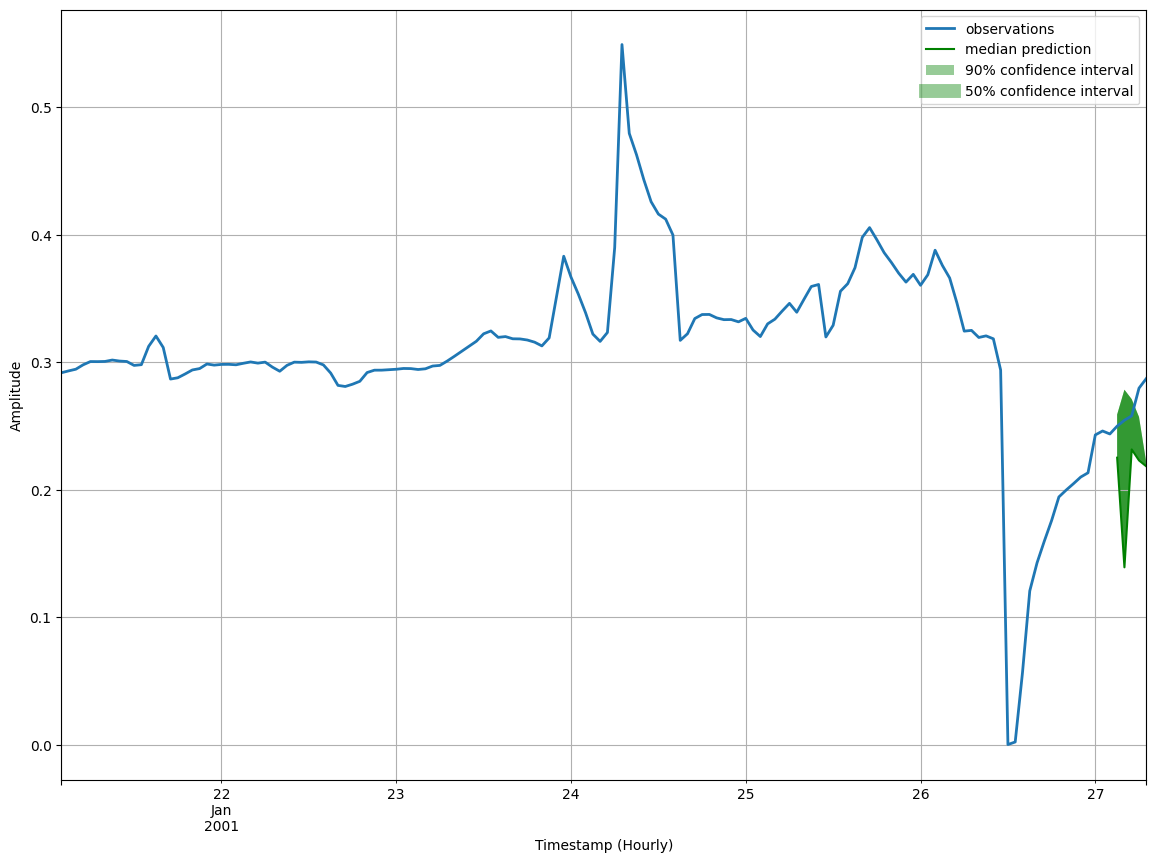

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Performance metrics {'MSE': 0.0016620809212327004, 'abs_error': 0.29198819398880005, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 1.7813799611558767, 'MAPE': 0.21946743074762898, 'sMAPE': 0.2593146850118574, 'OWA': nan, 'MSIS': 23.133636358257412, 'QuantileLoss[0.1]': 0.058397641777992254, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.29198820888996124, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.16862542033195496, 'Coverage[0.9]': 0.6, 'RMSE': 0.04076862667827677, 'NRMSE': 0.15342290803769318, 'ND': 0.21976544948621418, 'wQuantileLoss[0.1]': 0.0439530921403201, 'wQuantileLoss[0.5]': 0.21976546070160047, 'wQuantileLoss[0.9]': 0.12691623174146327, 'mean_wQuantileLoss': 0.13021159486112796, 'MAE_Coverage': 0.3}


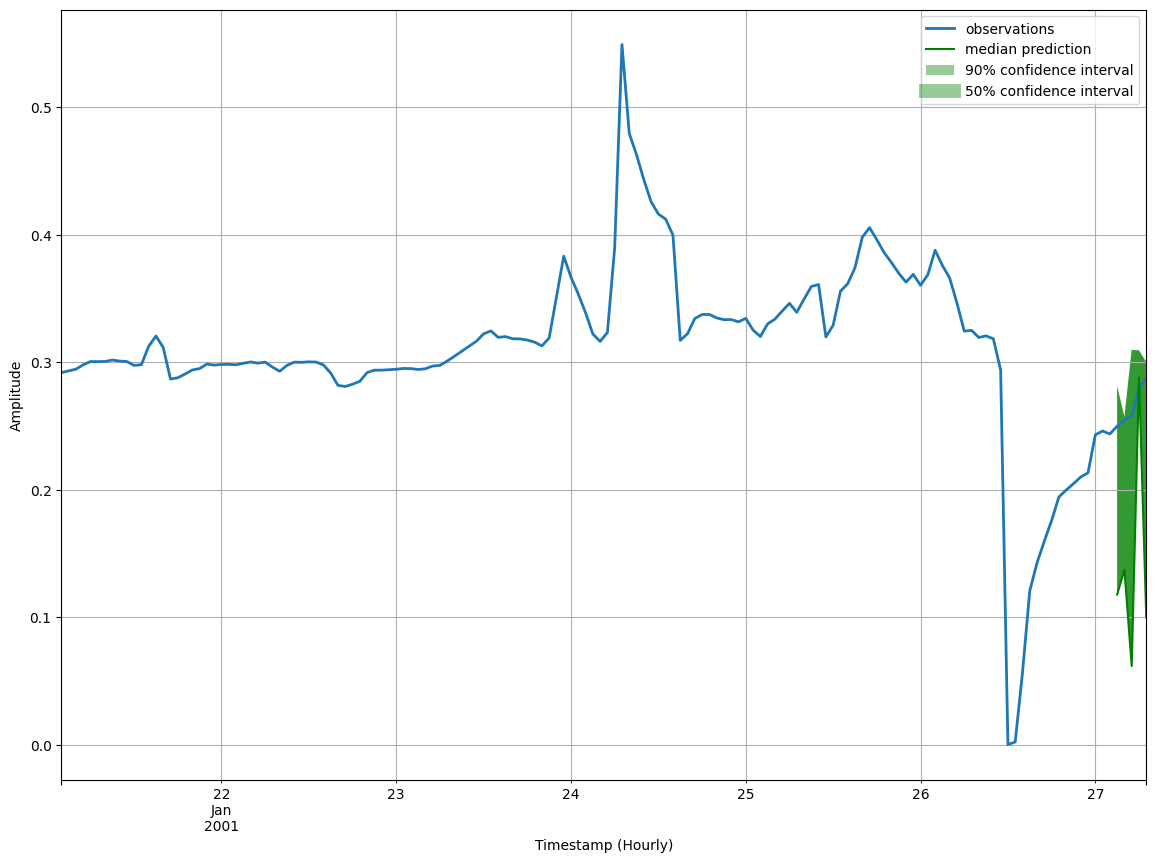

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Performance metrics {'MSE': 0.003805225342512131, 'abs_error': 0.6413993239402771, 'abs_target_sum': 1.328635573387146, 'abs_target_mean': 0.2657271146774292, 'seasonal_error': 0.032782247511007015, 'MASE': 3.913089386107038, 'MAPE': 0.4867599593171727, 'sMAPE': 0.7090921788430091, 'OWA': nan, 'MSIS': 6.629523197998528, 'QuantileLoss[0.1]': 0.14163197576999664, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.6413993388414383, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.025628286600112914, 'Coverage[0.9]': 1.0, 'RMSE': 0.06168650859395538, 'NRMSE': 0.23214231889296547, 'ND': 0.48275037699399476, 'wQuantileLoss[0.1]': 0.10659956620680293, 'wQuantileLoss[0.5]': 0.48275038820938104, 'wQuantileLoss[0.9]': 0.019289176892033424, 'mean_wQuantileLoss': 0.20287971043607247, 'MAE_Coverage': 0.16666666666666666}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 5 (R1147)
----------*****--------------------

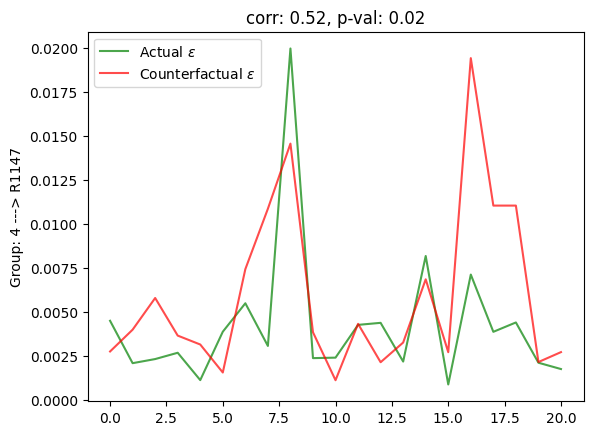

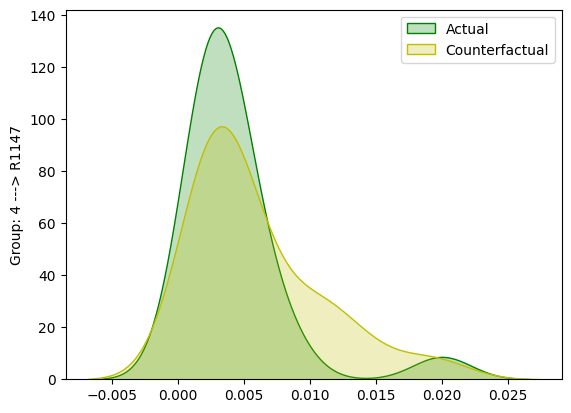

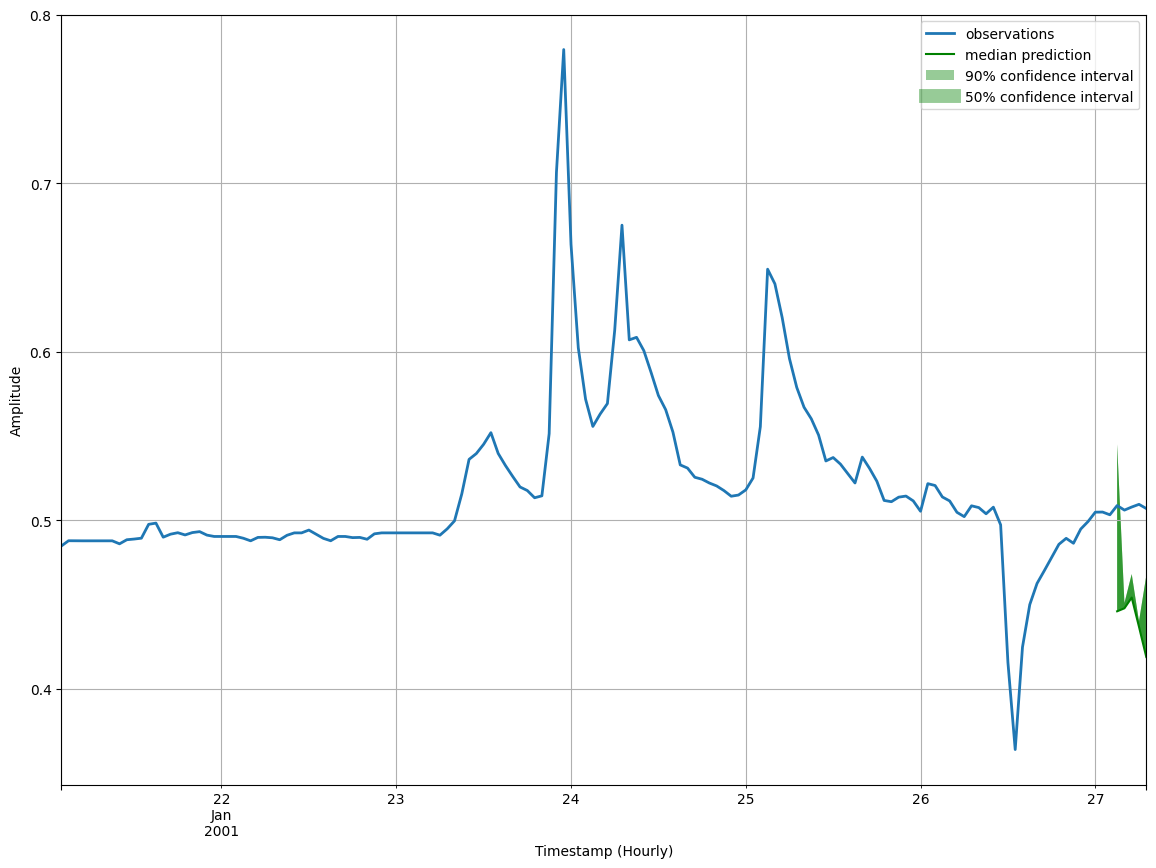

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Performance metrics {'MSE': 0.002944115363061428, 'abs_error': 0.3355009853839874, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 4.009152289154261, 'MAPE': 0.1321447057788238, 'sMAPE': 0.14185349243686315, 'OWA': nan, 'MSIS': 99.65597849193286, 'QuantileLoss[0.1]': 0.06710019707679749, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.3355009853839874, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.375018286705017, 'Coverage[0.9]': 0.2, 'RMSE': 0.0542597029393032, 'NRMSE': 0.10685818471704116, 'ND': 0.1321460469808162, 'wQuantileLoss[0.1]': 0.02642920939616324, 'wQuantileLoss[0.5]': 0.1321460469808162, 'wQuantileLoss[0.9]': 0.14771099428178194, 'mean_wQuantileLoss': 0.10209541688625379, 'MAE_Coverage': 0.4333333333333333}


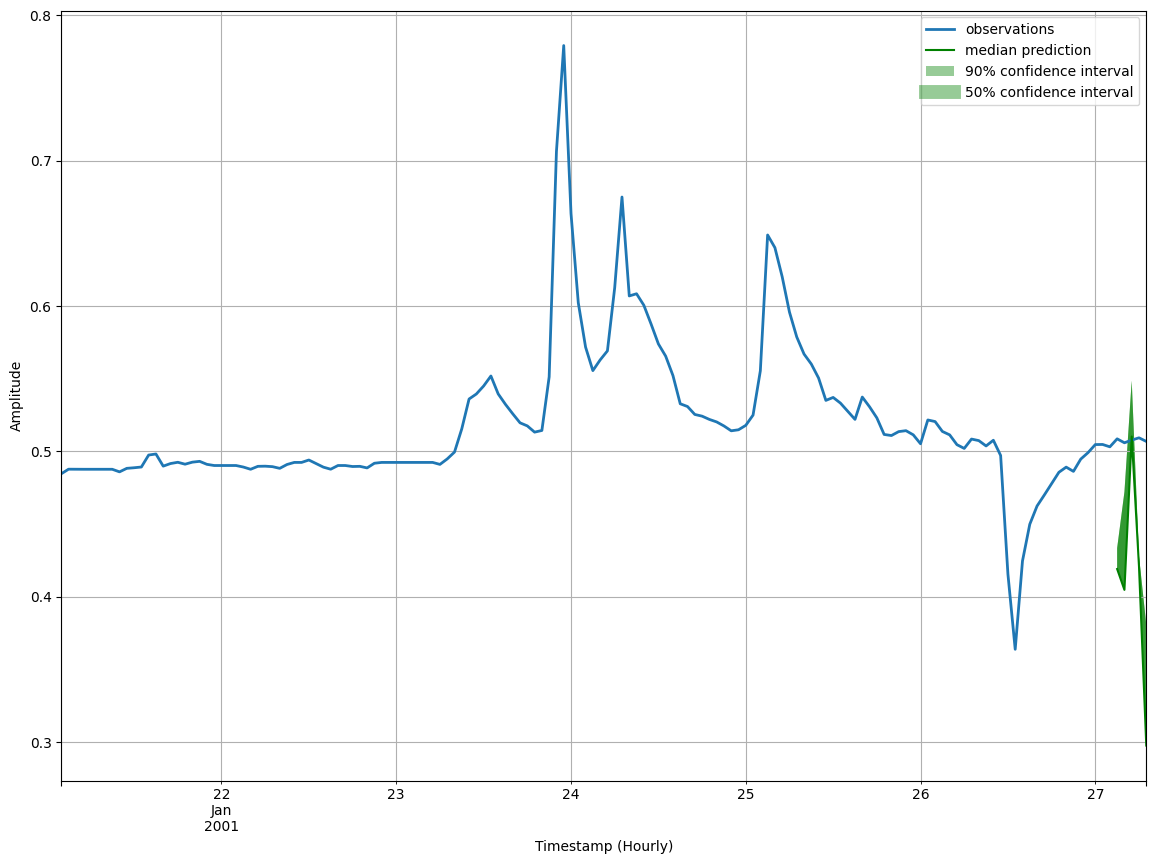

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Performance metrics {'MSE': 0.009431791305541993, 'abs_error': 0.4911791682243347, 'abs_target_sum': 2.538865089416504, 'abs_target_mean': 0.5077730178833008, 'seasonal_error': 0.016736754365335525, 'MASE': 5.8694673710650225, 'MAPE': 0.19356310637100244, 'sMAPE': 0.22619606164306524, 'OWA': nan, 'MSIS': 155.04288169811917, 'QuantileLoss[0.1]': 0.10221103429794312, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.4911791682243347, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.5780873358249665, 'Coverage[0.9]': 0.2, 'RMSE': 0.0971174098992657, 'NRMSE': 0.1912614622653813, 'ND': 0.19346406796952736, 'wQuantileLoss[0.1]': 0.040258552817169904, 'wQuantileLoss[0.5]': 0.19346406796952736, 'wQuantileLoss[0.9]': 0.22769517696500596, 'mean_wQuantileLoss': 0.15380593258390107, 'MAE_Coverage': 0.3666666666666667}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 1 (R553)
----------*****----------------------

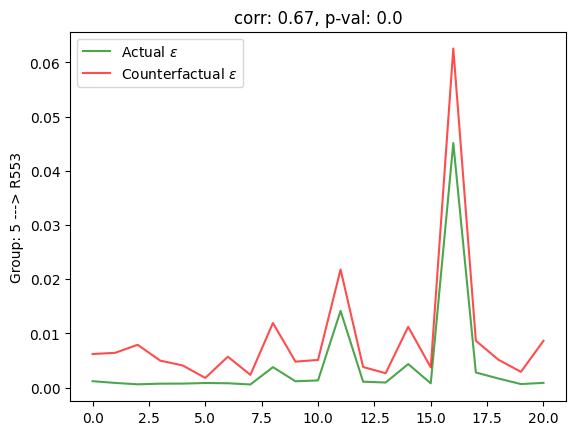

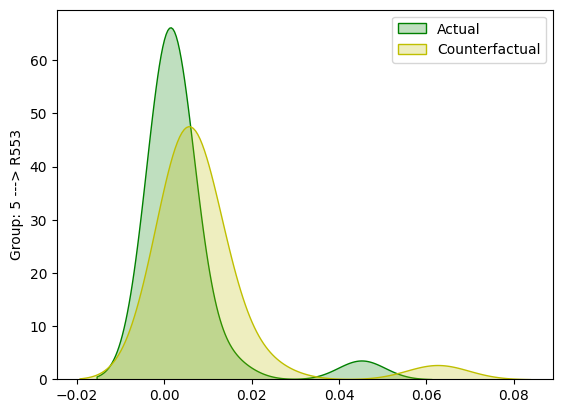

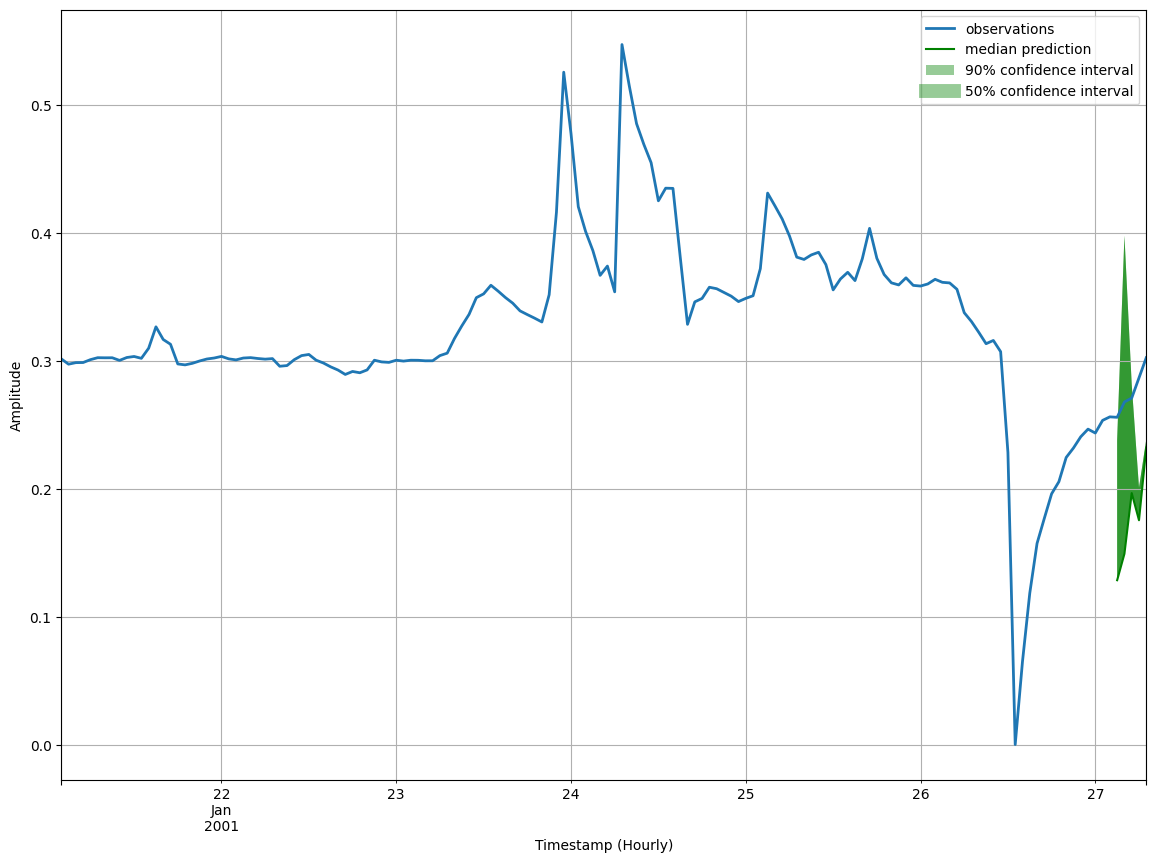

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Performance metrics {'MSE': 0.004100125655531884, 'abs_error': 0.501634955406189, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 3.0963982621265242, 'MAPE': 0.3671873752145788, 'sMAPE': 0.4589406472038335, 'OWA': nan, 'MSIS': 44.28427607137251, 'QuantileLoss[0.1]': 0.1003269910812378, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.501634955406189, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.32961469888687134, 'Coverage[0.9]': 0.4, 'RMSE': 0.0640322235716665, 'NRMSE': 0.23152646902251955, 'ND': 0.36276038371047714, 'wQuantileLoss[0.1]': 0.07255207674209543, 'wQuantileLoss[0.5]': 0.36276038371047714, 'wQuantileLoss[0.9]': 0.23836288391823585, 'mean_wQuantileLoss': 0.2245584481236028, 'MAE_Coverage': 0.3666666666666667}


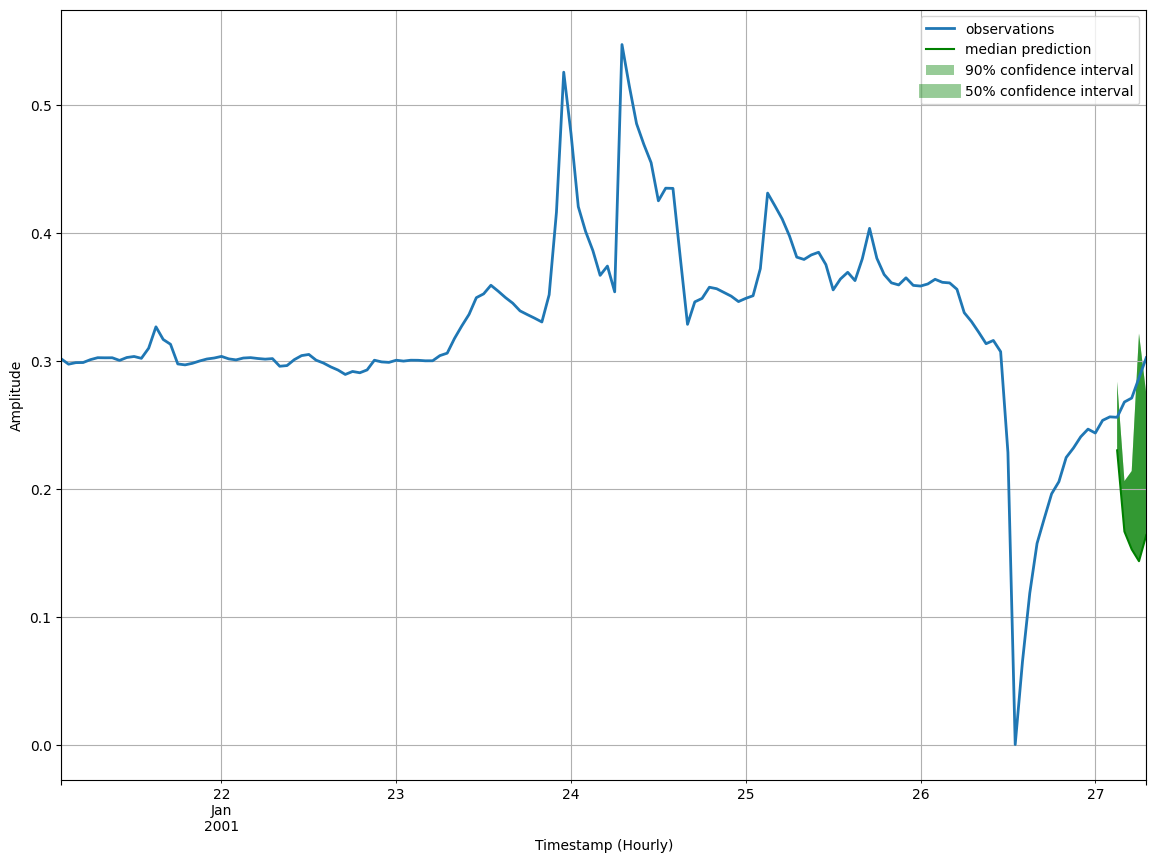

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Performance metrics {'MSE': 0.004847633838653565, 'abs_error': 0.527001142501831, 'abs_target_sum': 1.3828272819519043, 'abs_target_mean': 0.2765654563903809, 'seasonal_error': 0.032401190863715276, 'MASE': 3.2529739090052847, 'MAPE': 0.3748043054661955, 'sMAPE': 0.4784716189242159, 'OWA': nan, 'MSIS': 39.096849327612375, 'QuantileLoss[0.1]': 0.10540023148059846, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.5270011574029922, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.2776441514492035, 'Coverage[0.9]': 0.4, 'RMSE': 0.06962495126499957, 'NRMSE': 0.2517485450775955, 'ND': 0.38110409693244723, 'wQuantileLoss[0.1]': 0.07622082154166261, 'wQuantileLoss[0.5]': 0.381104107708313, 'wQuantileLoss[0.9]': 0.20078006492416034, 'mean_wQuantileLoss': 0.21936833139137865, 'MAE_Coverage': 0.3666666666666667}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 2 (R1144)
----------*****-----------------------**

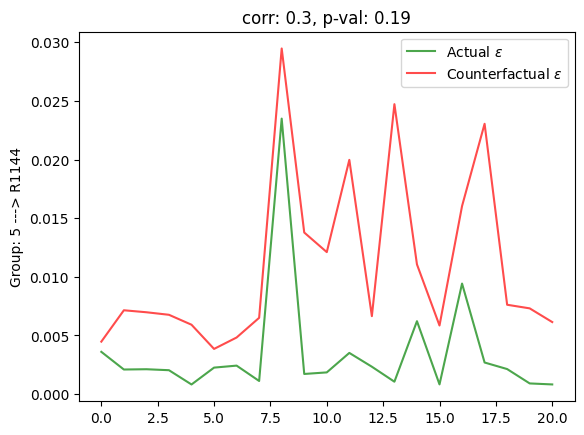

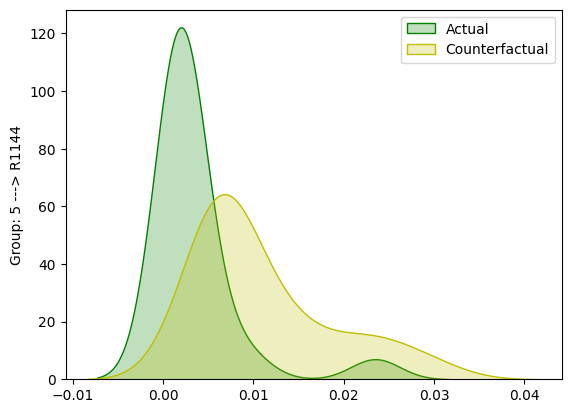

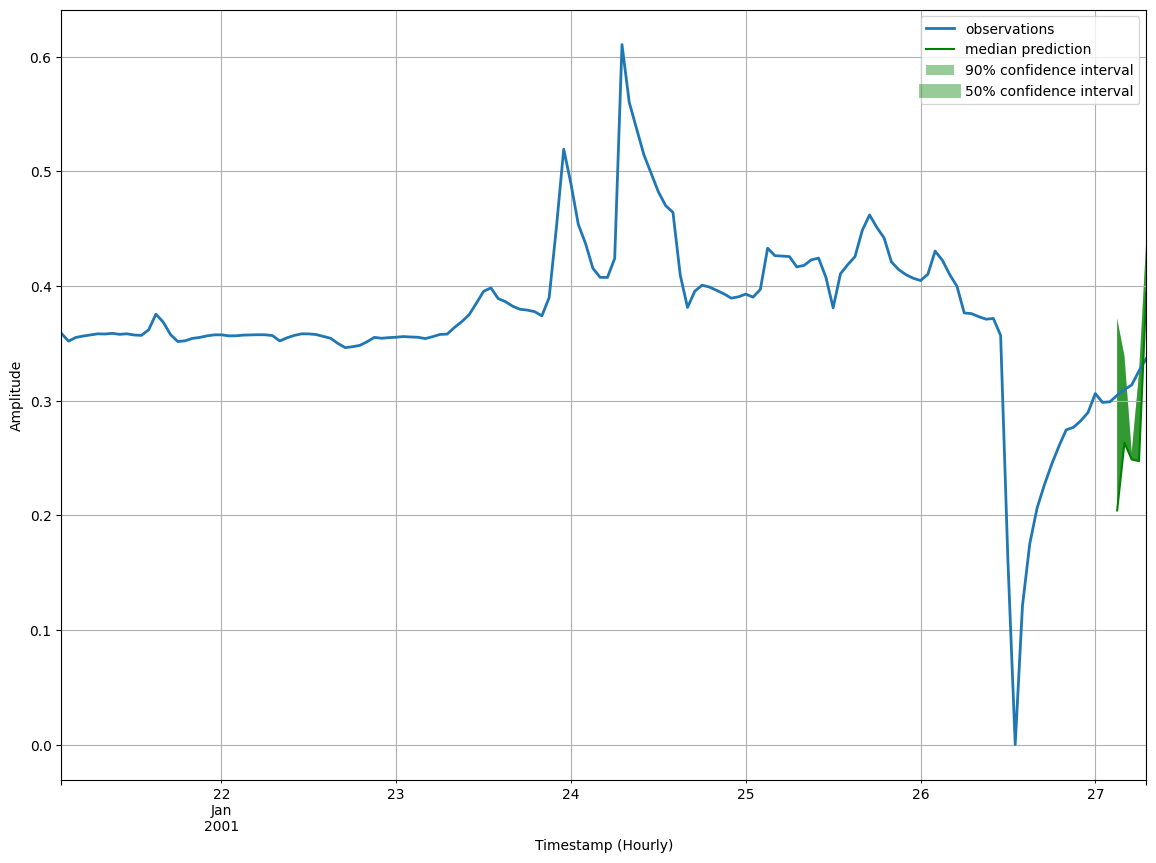

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Performance metrics {'MSE': 0.002462610974907875, 'abs_error': 0.348152756690979, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 2.3292109603310003, 'MAPE': 0.21983928901435396, 'sMAPE': 0.2440238325518326, 'OWA': nan, 'MSIS': 34.37436943314663, 'QuantileLoss[0.1]': 0.16163341999053954, 'Coverage[0.1]': 0.2, 'QuantileLoss[0.5]': 0.348152756690979, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.9]': 0.15091001391410827, 'Coverage[0.9]': 0.6, 'RMSE': 0.04962470125761842, 'NRMSE': 0.15596810020365065, 'ND': 0.21884554532575462, 'wQuantileLoss[0.1]': 0.10160124617968563, 'wQuantileLoss[0.5]': 0.21884554532575462, 'wQuantileLoss[0.9]': 0.09486061407080618, 'mean_wQuantileLoss': 0.13843580185874882, 'MAE_Coverage': 0.23333333333333336}


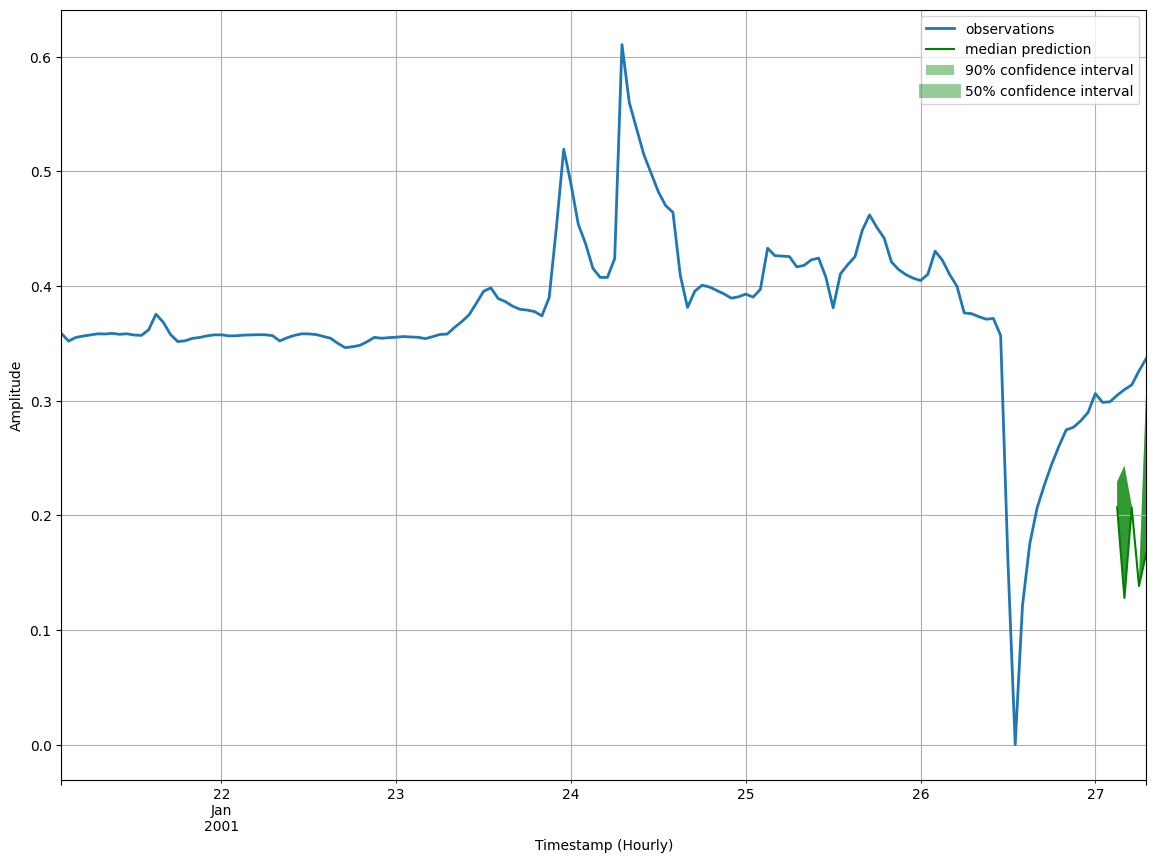

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Performance metrics {'MSE': 0.01559617817401886, 'abs_error': 0.7438048124313354, 'abs_target_sum': 1.5908606052398682, 'abs_target_mean': 0.31817212104797366, 'seasonal_error': 0.029894480373001818, 'MASE': 4.976201647599651, 'MAPE': 0.4656304621118509, 'sMAPE': 0.6211508346715255, 'OWA': nan, 'MSIS': 123.84293379964978, 'QuantileLoss[0.1]': 0.14876095950603485, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.7438047975301743, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.8200290530920029, 'Coverage[0.9]': 0.0, 'RMSE': 0.12488465948233538, 'NRMSE': 0.3925066063959306, 'ND': 0.4675487028727985, 'wQuantileLoss[0.1]': 0.09350973870121376, 'wQuantileLoss[0.5]': 0.4675486935060688, 'wQuantileLoss[0.9]': 0.5154625429726823, 'mean_wQuantileLoss': 0.3588403250599883, 'MAE_Coverage': 0.5}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
T

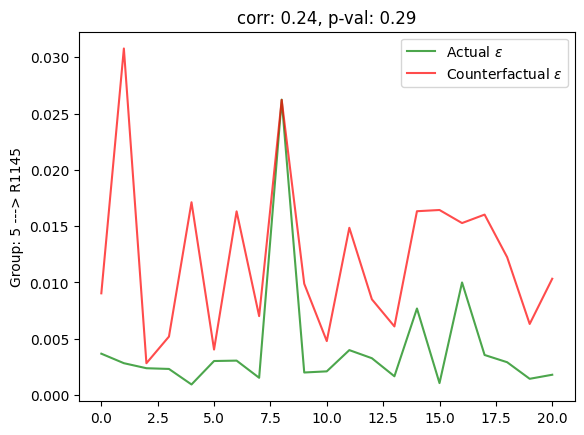

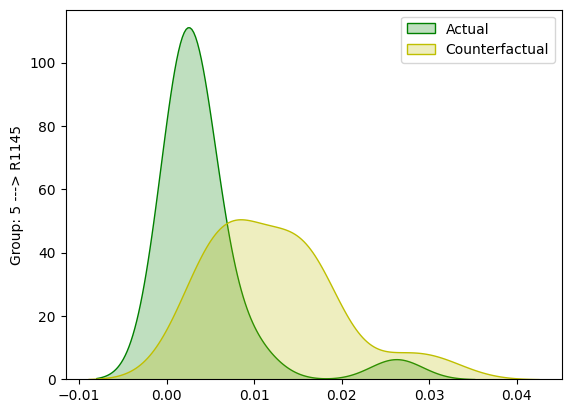

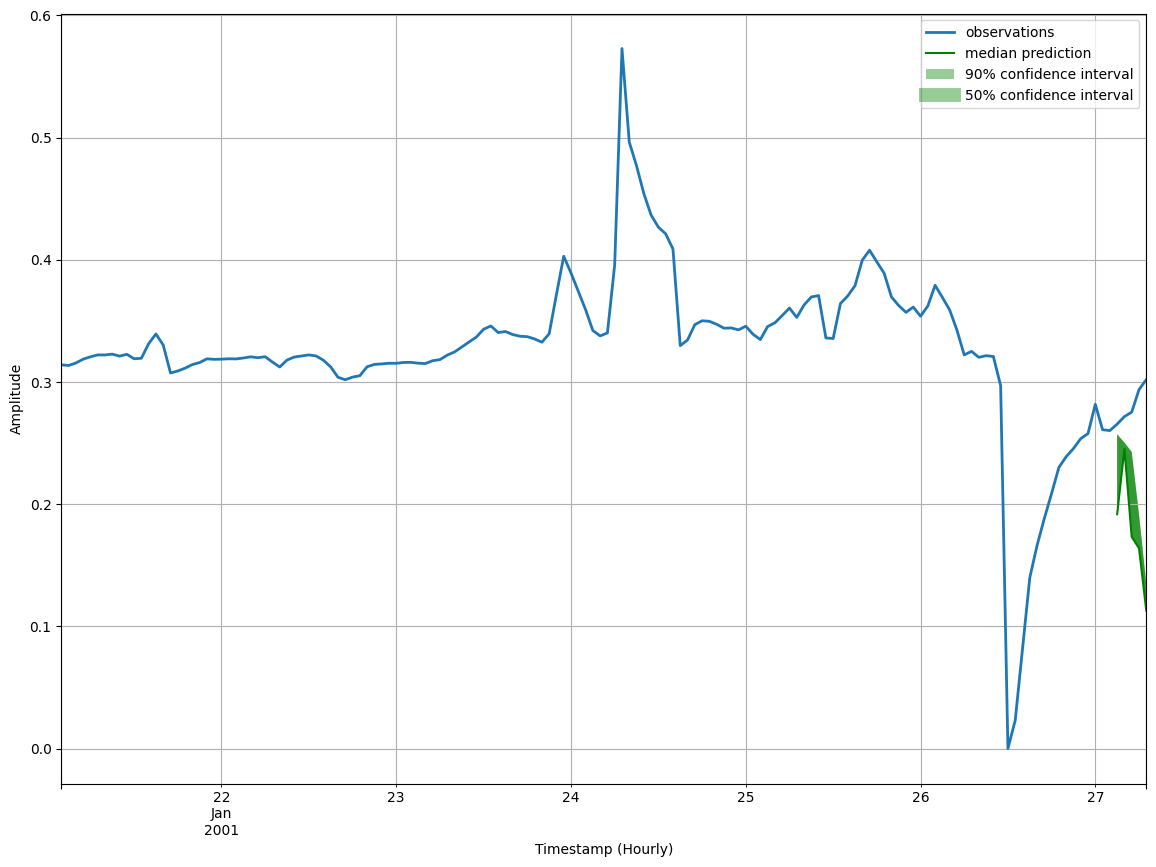

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Performance metrics {'MSE': 0.01039295196533203, 'abs_error': 0.5213298797607422, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 3.5206377610611934, 'MAPE': 0.36292456625632685, 'sMAPE': 0.4719660896454762, 'OWA': nan, 'MSIS': 90.83509992715501, 'QuantileLoss[0.1]': 0.10426598191261291, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.5213299095630646, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.5967402756214142, 'Coverage[0.9]': 0.0, 'RMSE': 0.10194582858230164, 'NRMSE': 0.36197174822846484, 'ND': 0.37020972923553586, 'wQuantileLoss[0.1]': 0.07404195007978599, 'wQuantileLoss[0.5]': 0.37020975039893, 'wQuantileLoss[0.9]': 0.42376058698789876, 'mean_wQuantileLoss': 0.28933742915553823, 'MAE_Coverage': 0.5}


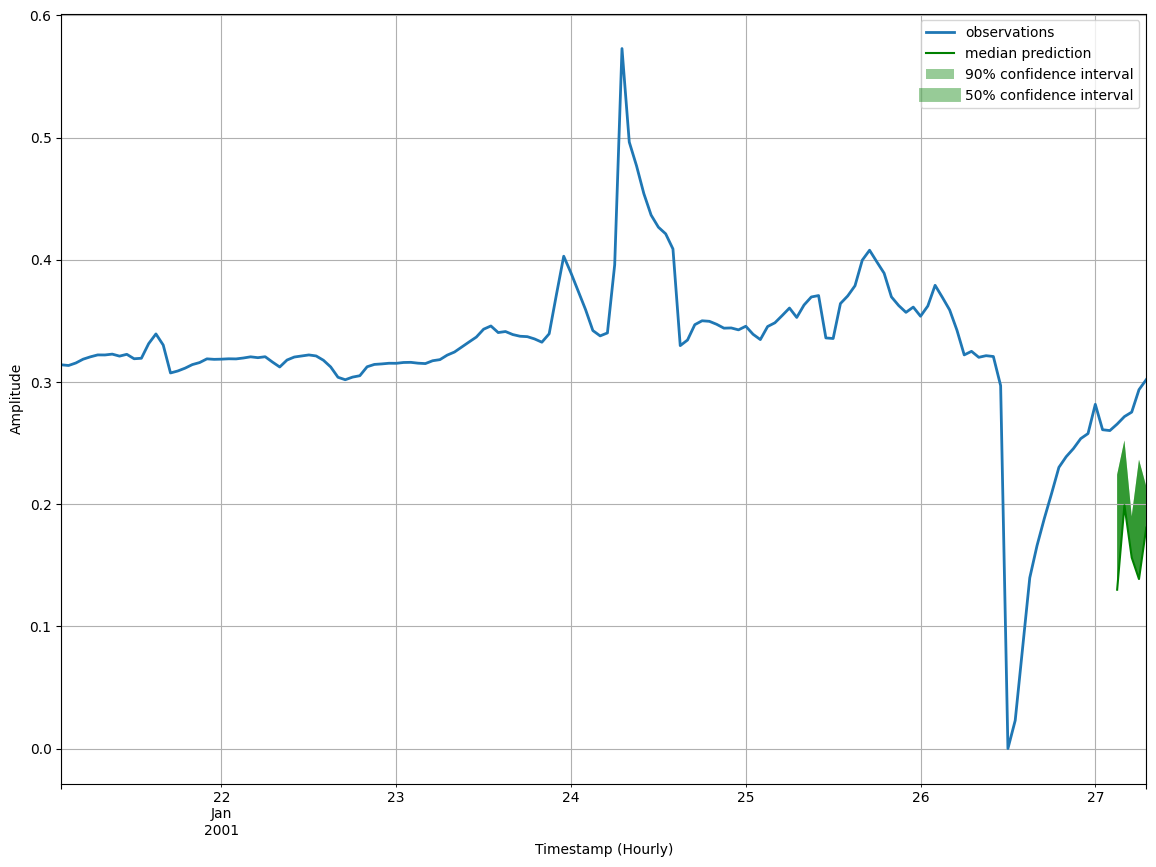

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Performance metrics {'MSE': 0.008507613837718964, 'abs_error': 0.6032607555389404, 'abs_target_sum': 1.4082014560699463, 'abs_target_mean': 0.28164029121398926, 'seasonal_error': 0.029615650069242144, 'MASE': 4.073932222514119, 'MAPE': 0.42775143345945266, 'sMAPE': 0.5527658781751378, 'OWA': nan, 'MSIS': 80.7433250421533, 'QuantileLoss[0.1]': 0.12065215110778807, 'Coverage[0.1]': 0.0, 'QuantileLoss[0.5]': 0.6032607555389404, 'Coverage[0.5]': 0.0, 'QuantileLoss[0.9]': 0.5239878237247466, 'Coverage[0.9]': 0.0, 'RMSE': 0.09223672716287674, 'NRMSE': 0.32749833756135277, 'ND': 0.4283909471465396, 'wQuantileLoss[0.1]': 0.0856781894293079, 'wQuantileLoss[0.5]': 0.4283909471465396, 'wQuantileLoss[0.9]': 0.3720972034691035, 'mean_wQuantileLoss': 0.2953887800149837, 'MAE_Coverage': 0.5}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
T

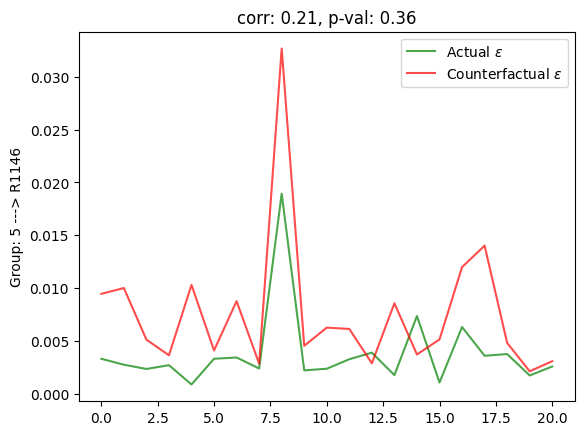

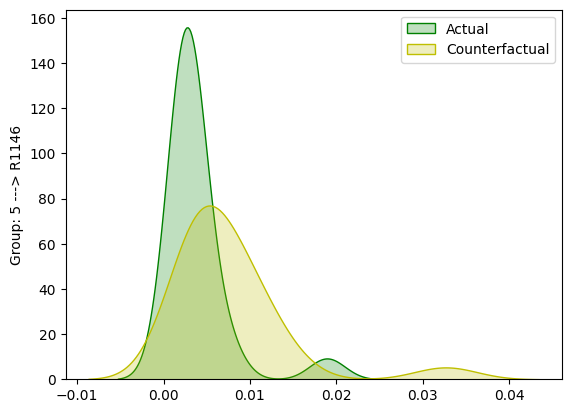

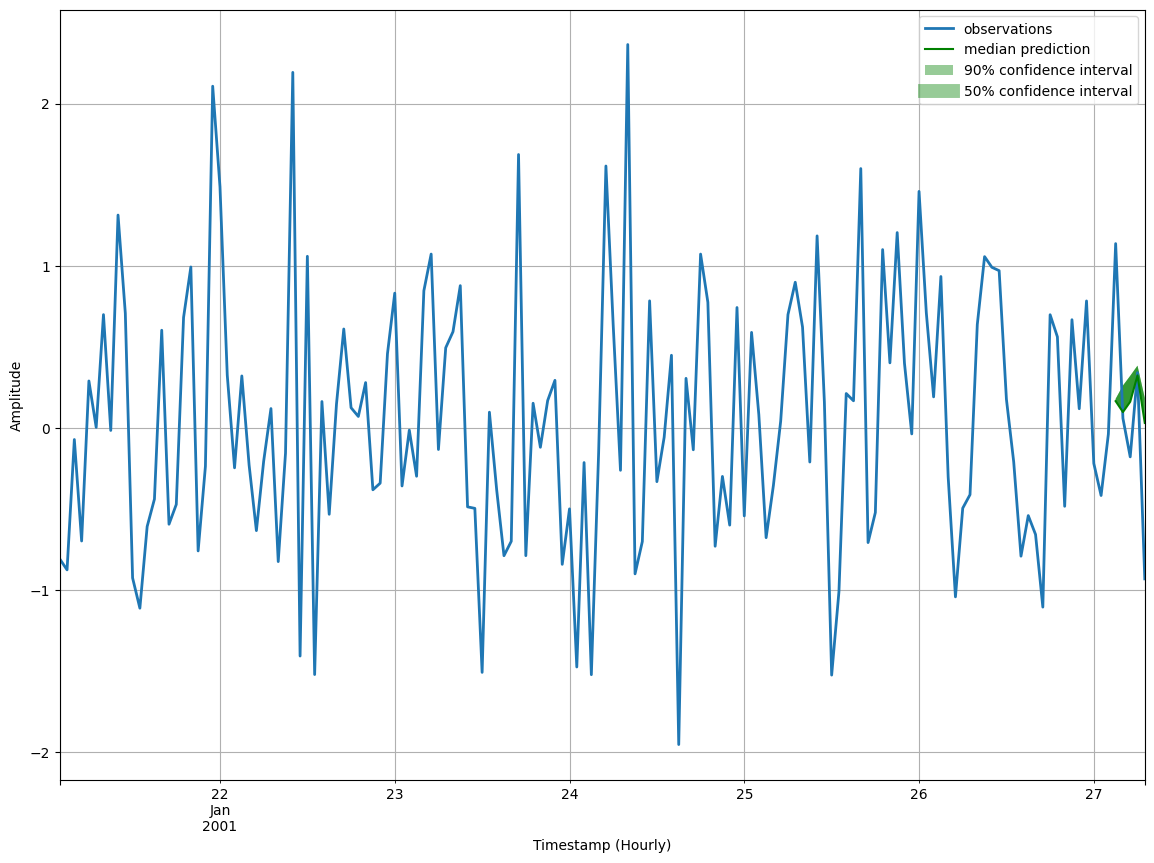

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Performance metrics {'MSE': 0.4403557777404785, 'abs_error': 2.330082893371582, 'abs_target_sum': 2.646075963973999, 'abs_target_mean': 0.5292151927947998, 'seasonal_error': 0.9246527892721574, 'MASE': 0.503990886180252, 'MAPE': 0.899886139551843, 'sMAPE': 1.2101801784400927, 'OWA': nan, 'MSIS': 20.00667836798823, 'QuantileLoss[0.1]': 2.6115019619464874, 'Coverage[0.1]': 0.6, 'QuantileLoss[0.5]': 2.330083042383194, 'Coverage[0.5]': 0.6, 'QuantileLoss[0.9]': 2.096087595820427, 'Coverage[0.9]': 0.8, 'RMSE': 0.6635930814441019, 'NRMSE': 1.2539191816086173, 'ND': 0.8805804992356138, 'wQuantileLoss[0.1]': 0.9869338588543064, 'wQuantileLoss[0.5]': 0.880580555549799, 'wQuantileLoss[0.9]': 0.7921494410434181, 'mean_wQuantileLoss': 0.8865546184825078, 'MAE_Coverage': 0.2333333333333333}


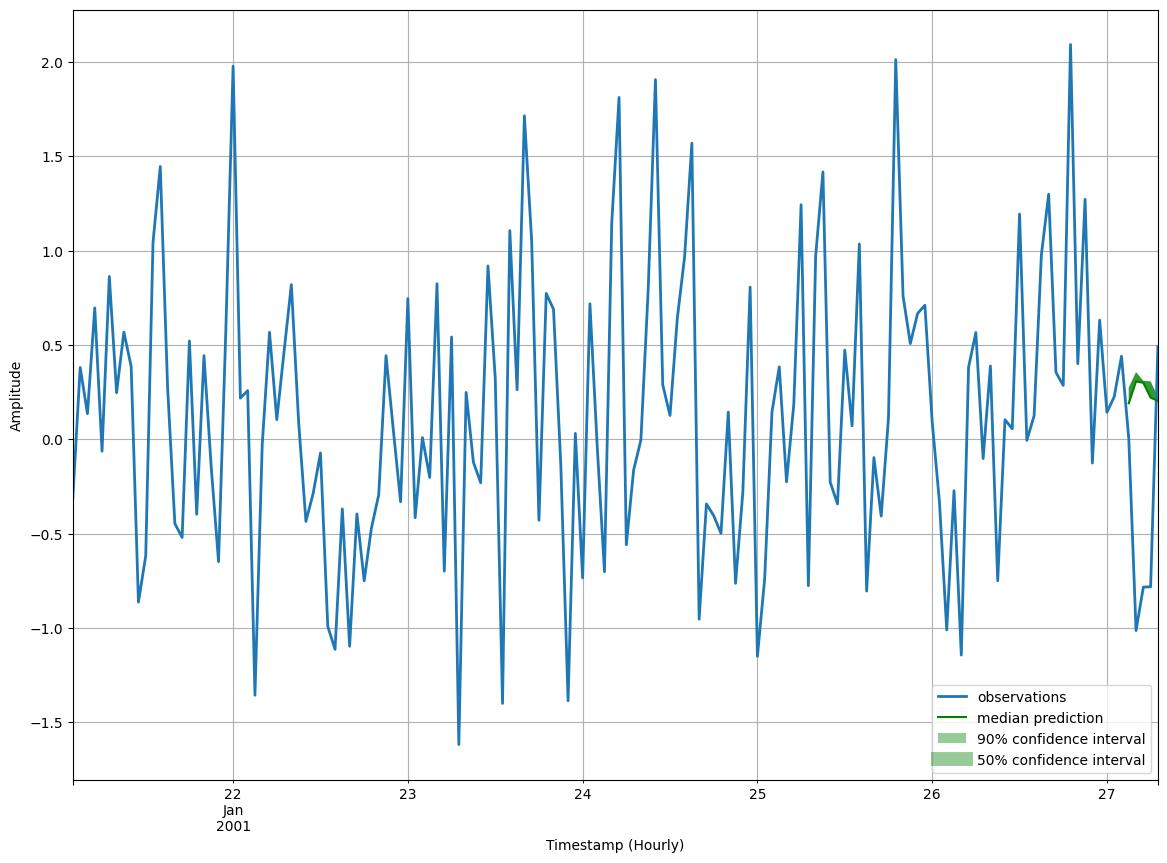

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Performance metrics {'MSE': 0.8430352210998535, 'abs_error': 3.880458354949951, 'abs_target_sum': 3.072563886642456, 'abs_target_mean': 0.6145127773284912, 'seasonal_error': 0.9237615725414902, 'MASE': 0.8401428399481649, 'MAPE': 9.519710016253715, 'sMAPE': 1.747138950922605, 'OWA': nan, 'MSIS': 33.48668166796634, 'QuantileLoss[0.1]': 6.525113475322724, 'Coverage[0.1]': 0.8, 'QuantileLoss[0.5]': 3.8804582953453064, 'Coverage[0.5]': 0.8, 'QuantileLoss[0.9]': 1.2456020414829252, 'Coverage[0.9]': 0.8, 'RMSE': 0.9181694947556543, 'NRMSE': 1.4941422353287241, 'ND': 1.262938216458152, 'wQuantileLoss[0.1]': 2.1236705618033676, 'wQuantileLoss[0.5]': 1.2629381970591593, 'wQuantileLoss[0.9]': 0.40539500151583724, 'mean_wQuantileLoss': 1.2640012534594547, 'MAE_Coverage': 0.3666666666666667}
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 5 (R1147)
----------*****-----------------------*****-----------

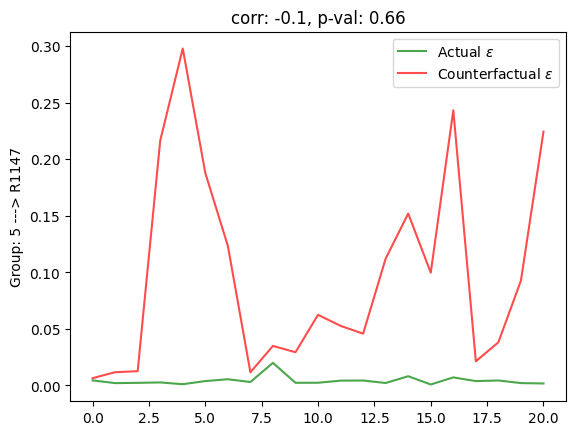

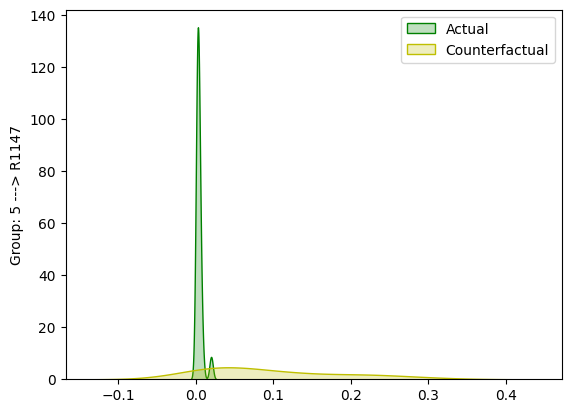

Separated matrices:

Causal Graph 1:
[[1 0 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]]

Causal Graph 2:
[[1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]]

Causal Graph 3:
[[1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]]

Causal Graph 4:
[[1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]]

Causal Graph 5:
[[1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]]

Causal Graph 6:
[[1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]]

Causal Graph 7:
[[1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]]

Causal Graph 8:
[[1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]]

Causal Graph 9:
[[1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]]

Causal Graph 10:
[[1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 1 1]
 [1 1 0 1 0]
 [1 1 1 1 1]]
--------------------------------------------------------
Actual Causal Graph: 
 [[0 1 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]
Cau

{'TPR': 0.75,
 'TNR': 0.14285714285714285,
 'FPR': 0.8571428571428571,
 'FNR': 0.25,
 'Accuracy': 0.24,
 'Precision': 0.14285714285714285,
 'Recall': 0.75,
 'Fscore': 0.24,
 'SHD': 19}

In [345]:
# Function for estimating causal impact among variables
method_type = 'Full'
group_size_list = [value[0] for value in pars['groups_size'].values()]
# ground_truth = gcdmi.get_ground_truth(ground_truth, group_size_list)
metrics, predicted_graph, predicted_graph_t1 = groupCause(original_data, knockoffs, model_path, pars, ground_truth, method_type)
metrics

#### Computation Time

In [ ]:
# # Calculate difference
# elapsed_time = end_time - start_time
# # Print elapsed time
# print("Computation time: ", round(elapsed_time/60), "mins")